# Conditional GAN (cGAN)

This notebook demonstrates the implementation of a Conditional Generative Adversarial Network (cGAN) for targeted data generation. Unlike standard GANs, a cGAN leverages additional information, such as class labels or text descriptions, to control the output of the Generator. 

## How cGAN Differs from Regular GAN

### Conditioning Mechanism
- **Regular GAN**: Generates data purely based on random noise without explicit control.
- **cGAN**: Uses conditions (e.g., class labels) alongside random noise to generate data tailored to the given condition.

### Inputs to Models
- **Generator in Regular GAN**: Only takes random noise $z$.
- **Generator in cGAN**: Takes both random noise $z$ and condition $c$.
- **Discriminator in Regular GAN**: Only evaluates the realness of the data.
- **Discriminator in cGAN**: Evaluates both the realness of the data and its alignment with the given condition.

### Control over Data Generation
- **Regular GAN**: Generates random outputs without control.
- **cGAN**: Enables targeted generation by explicitly specifying the condition.

### Applications
cGANs are especially useful in scenarios requiring controlled generation, such as:
- Generating specific digits from MNIST.
- Creating images based on textual descriptions (e.g., \"a sunset over the ocean\").
- Colorizing grayscale images with predefined palettes.

## Notebook Structure

1. **Data Preparation**: Load the dataset, preprocess it, and extract conditions.
2. **Model Definition**:
   - **Generator**: Takes noise and conditions to generate data.
   - **Discriminator**: Evaluates data authenticity and its compliance with conditions.
3. **Training Process**:
   - Alternate between training the Generator and the Discriminator.
   - Monitor losses for both models to ensure balanced training.
4. **Visualization**: Display generated images for specific conditions to assess the performance of the cGAN.


In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision
import matplotlib.pyplot as plt
import os

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Preparation
Load the dataset, preprocess it, and extract conditions.

In [2]:
# Hyperparameters
latent_dim = 100  # Size of the latent space
n_classes = 10    # Number of classes in MNIST
img_size = 28     # Size of the image (28x28 for MNIST)
channels = 1      # Number of channels (grayscale = 1)
batch_size = 64   # Batch size
epochs = 50       # Number of training epochs

# Data loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize images to [-1, 1]
])

dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 479kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.41MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.26MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Model Definition
   - **Generator**: Takes noise and conditions to generate data.
   - **Discriminator**: Evaluates data authenticity and its compliance with conditions.

In [ ]:


# Define the Conditional Generator
class ConditionalGenerator(nn.Module):
    def __init__(self, latent_dim, n_classes, img_size, channels):
        super(ConditionalGenerator, self).__init__()
        self.label_embedding = nn.Embedding(n_classes, n_classes)

        self.model = nn.Sequential(
            nn.Linear(latent_dim + n_classes, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, img_size * img_size * channels),
            nn.Tanh()
        )

    def forward(self, z, labels):
        # Embed labels and concatenate with noise
        c = self.label_embedding(labels)
        x = torch.cat([z, c], dim=1)
        img = self.model(x)
        return img.view(img.size(0), channels, img_size, img_size)

In [4]:

# Define the Conditional Discriminator
class ConditionalDiscriminator(nn.Module):
    def __init__(self, n_classes, img_size, channels):
        super(ConditionalDiscriminator, self).__init__()
        self.label_embedding = nn.Embedding(n_classes, n_classes)

        self.model = nn.Sequential(
            nn.Linear(img_size * img_size * channels + n_classes, 1024),  # Увеличиваем размер слоя
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        # Embed labels and concatenate with flattened image
        img_flat = img.view(img.size(0), -1)
        c = self.label_embedding(labels)
        x = torch.cat([img_flat, c], dim=1)
        validity = self.model(x)
        return validity

In [5]:
# Initialize models
generator = ConditionalGenerator(latent_dim, n_classes, img_size, channels).to(device)
discriminator = ConditionalDiscriminator(n_classes, img_size, channels).to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function
adversarial_loss = nn.BCELoss()


In [6]:
# Function to visualize generated images for each class
def visualize_generated_images(generator, latent_dim, n_classes, device, epoch, samples_per_class=4):
    generator.eval()
    fig, axes = plt.subplots(n_classes, samples_per_class, figsize=(samples_per_class * 2, n_classes * 2))

    with torch.no_grad():
        for class_index in range(n_classes):
            # Generate random noise and corresponding class labels
            z = torch.randn(samples_per_class, latent_dim).to(device)
            labels = torch.full((samples_per_class,), class_index, dtype=torch.long).to(device)
            gen_imgs = generator(z, labels)
            gen_imgs = (gen_imgs + 1) / 2  # Rescale to [0, 1]

            for i in range(samples_per_class):
                img = gen_imgs[i].permute(1, 2, 0).cpu().numpy()
                axes[class_index, i].imshow(img.squeeze(), cmap='gray')
                axes[class_index, i].axis('off')

    plt.tight_layout()
    plt.savefig(f'generated_images_epoch_{epoch}.png')
    plt.show()

## **Training Process**
   - Alternate between training the Generator and the Discriminator.
   - Monitor losses for both models to ensure balanced training.

Epoch [1/50] Batch [0/938] Loss D: 1.3543, Loss G: 0.6901
Epoch [1/50] Batch [100/938] Loss D: 1.6813, Loss G: 0.7107
Epoch [1/50] Batch [200/938] Loss D: 1.1824, Loss G: 1.5261
Epoch [1/50] Batch [300/938] Loss D: 1.0447, Loss G: 1.2642
Epoch [1/50] Batch [400/938] Loss D: 1.0098, Loss G: 1.4425
Epoch [1/50] Batch [500/938] Loss D: 1.0161, Loss G: 0.8372
Epoch [1/50] Batch [600/938] Loss D: 1.0271, Loss G: 1.0444
Epoch [1/50] Batch [700/938] Loss D: 1.5405, Loss G: 0.4815
Epoch [1/50] Batch [800/938] Loss D: 1.0606, Loss G: 1.4226
Epoch [1/50] Batch [900/938] Loss D: 0.9159, Loss G: 0.8040


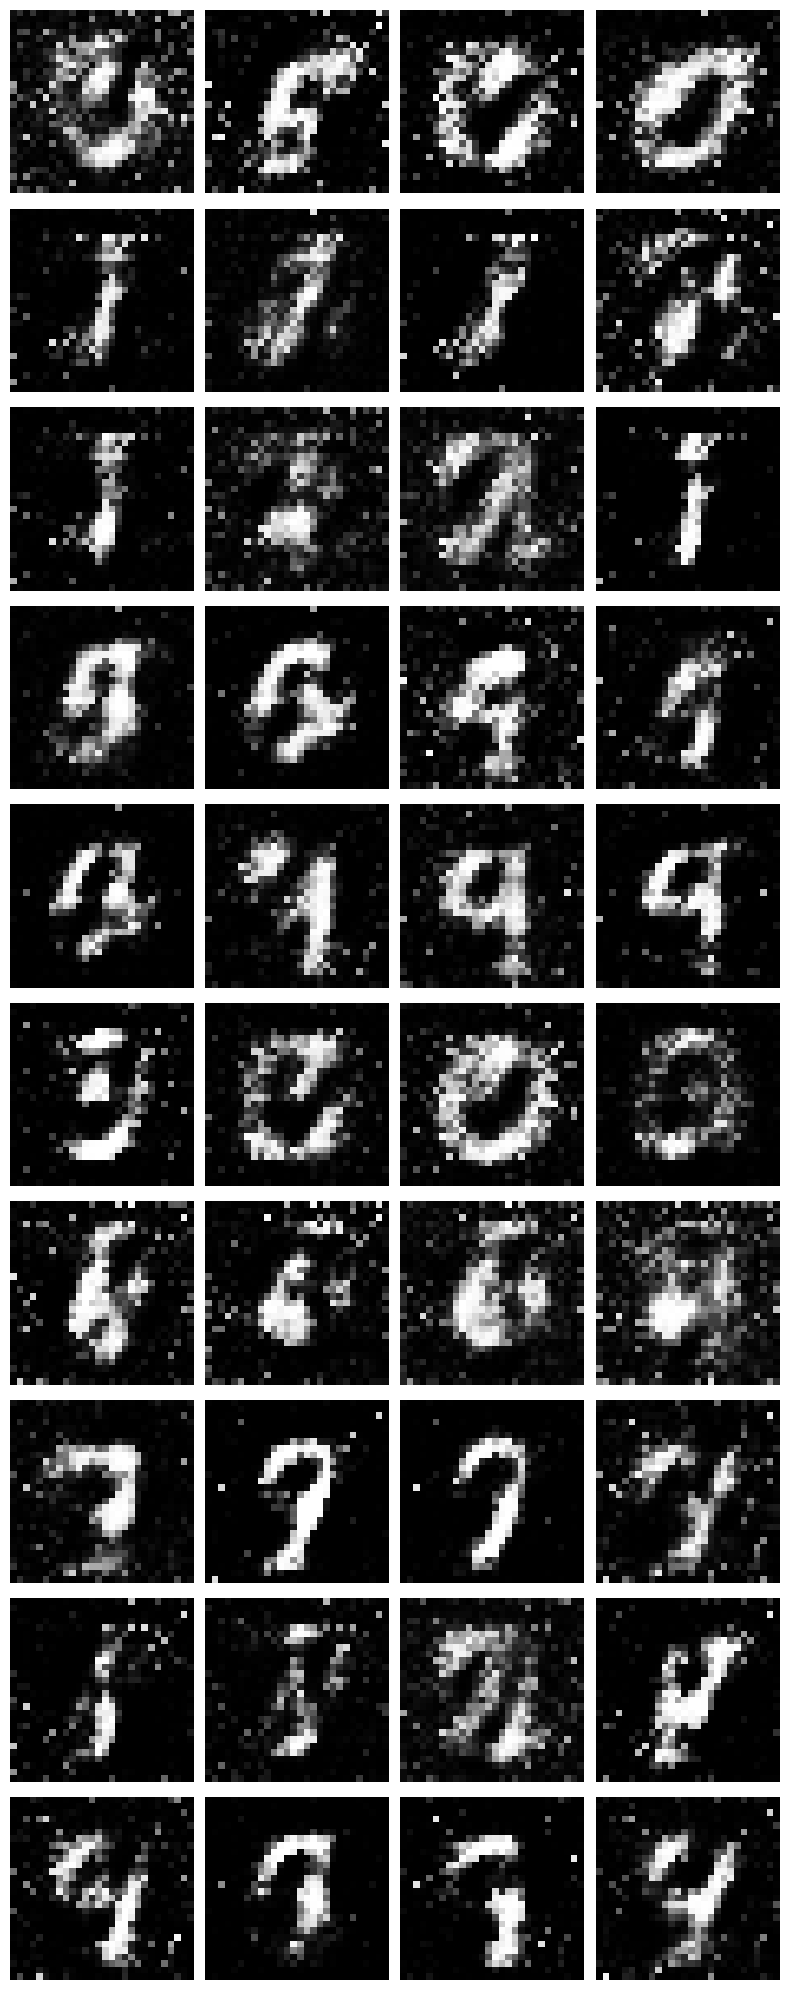

Epoch [2/50] Batch [0/938] Loss D: 1.3266, Loss G: 1.2914
Epoch [2/50] Batch [100/938] Loss D: 1.1329, Loss G: 0.8928
Epoch [2/50] Batch [200/938] Loss D: 1.0761, Loss G: 1.0755
Epoch [2/50] Batch [300/938] Loss D: 1.0338, Loss G: 1.3254
Epoch [2/50] Batch [400/938] Loss D: 1.1954, Loss G: 1.4584
Epoch [2/50] Batch [500/938] Loss D: 1.0606, Loss G: 1.1330
Epoch [2/50] Batch [600/938] Loss D: 1.2053, Loss G: 2.3442
Epoch [2/50] Batch [700/938] Loss D: 1.0292, Loss G: 1.3725
Epoch [2/50] Batch [800/938] Loss D: 0.8746, Loss G: 1.0575
Epoch [2/50] Batch [900/938] Loss D: 1.1007, Loss G: 2.0378


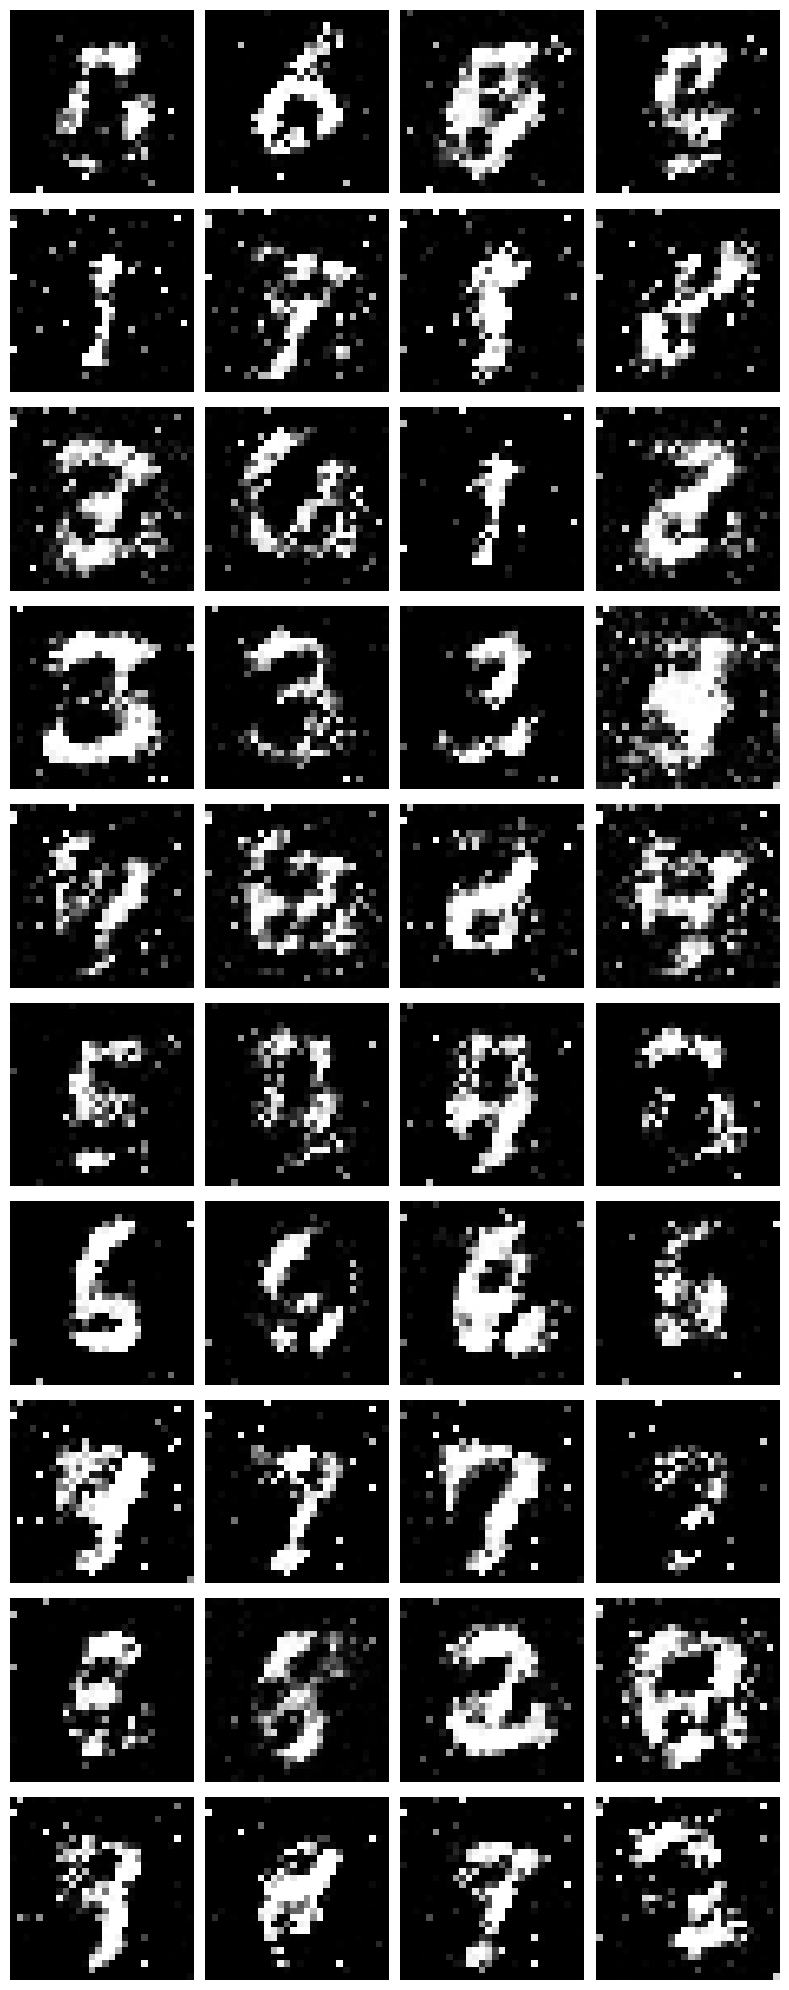

Epoch [3/50] Batch [0/938] Loss D: 0.8822, Loss G: 2.2429
Epoch [3/50] Batch [100/938] Loss D: 1.0340, Loss G: 0.9863
Epoch [3/50] Batch [200/938] Loss D: 0.8386, Loss G: 1.5416
Epoch [3/50] Batch [300/938] Loss D: 0.9841, Loss G: 1.3710
Epoch [3/50] Batch [400/938] Loss D: 0.9683, Loss G: 0.8635
Epoch [3/50] Batch [500/938] Loss D: 1.1881, Loss G: 1.7332
Epoch [3/50] Batch [600/938] Loss D: 0.8353, Loss G: 1.2615
Epoch [3/50] Batch [700/938] Loss D: 1.1597, Loss G: 1.1407
Epoch [3/50] Batch [800/938] Loss D: 1.1843, Loss G: 1.5040
Epoch [3/50] Batch [900/938] Loss D: 1.2891, Loss G: 1.3877


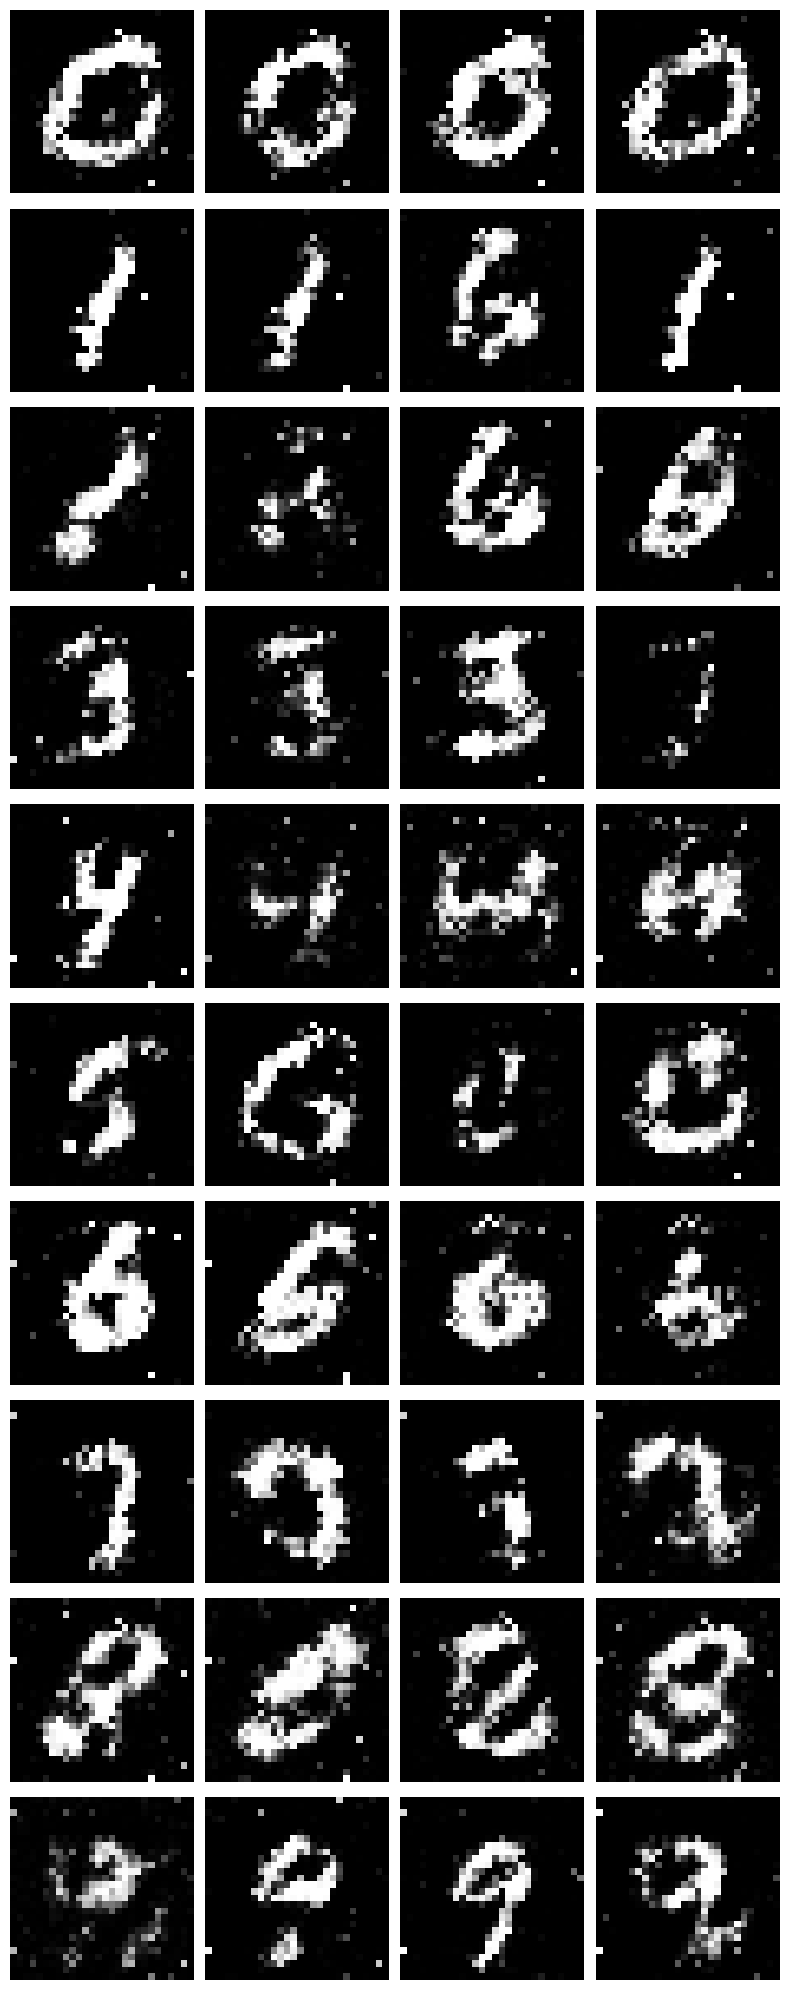

Epoch [4/50] Batch [0/938] Loss D: 1.0808, Loss G: 1.0109
Epoch [4/50] Batch [100/938] Loss D: 1.0441, Loss G: 1.0224
Epoch [4/50] Batch [200/938] Loss D: 1.0670, Loss G: 1.0557
Epoch [4/50] Batch [300/938] Loss D: 1.2483, Loss G: 0.9078
Epoch [4/50] Batch [400/938] Loss D: 1.1983, Loss G: 0.7889
Epoch [4/50] Batch [500/938] Loss D: 1.1147, Loss G: 0.8651
Epoch [4/50] Batch [600/938] Loss D: 1.0383, Loss G: 0.8620
Epoch [4/50] Batch [700/938] Loss D: 1.3506, Loss G: 1.0887
Epoch [4/50] Batch [800/938] Loss D: 1.2268, Loss G: 1.0786
Epoch [4/50] Batch [900/938] Loss D: 1.1217, Loss G: 0.8956


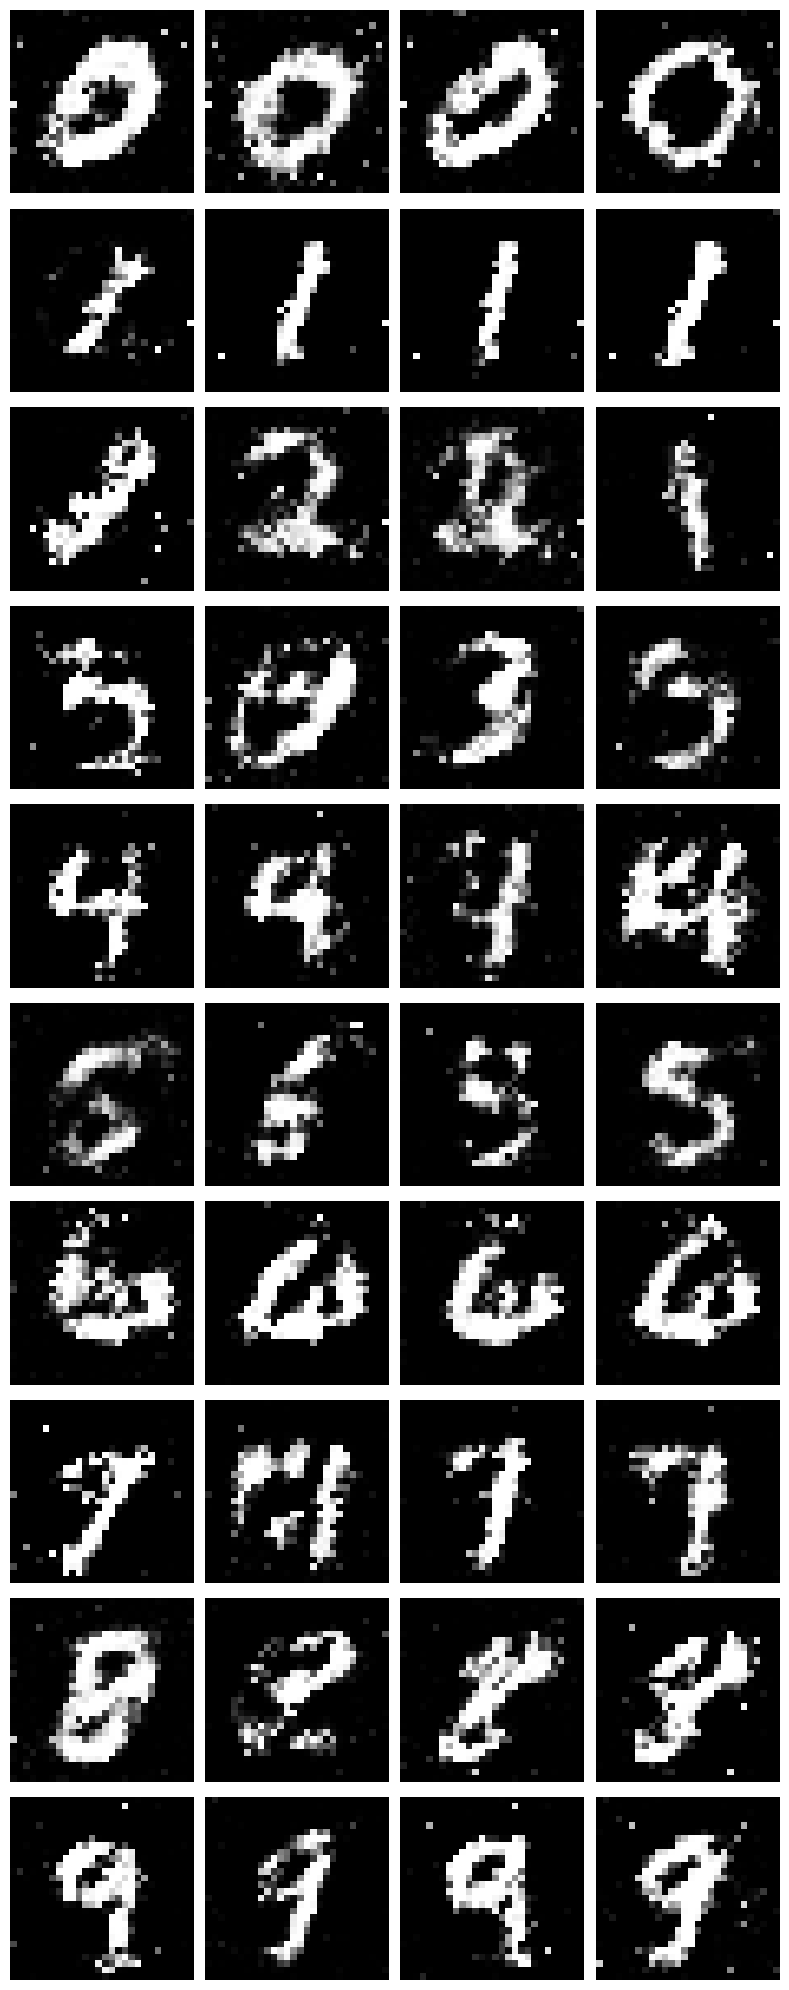

Epoch [5/50] Batch [0/938] Loss D: 1.1575, Loss G: 1.0066
Epoch [5/50] Batch [100/938] Loss D: 1.2255, Loss G: 1.0974
Epoch [5/50] Batch [200/938] Loss D: 1.2889, Loss G: 0.9295
Epoch [5/50] Batch [300/938] Loss D: 1.2442, Loss G: 1.0155
Epoch [5/50] Batch [400/938] Loss D: 1.2468, Loss G: 0.7445
Epoch [5/50] Batch [500/938] Loss D: 1.3349, Loss G: 0.8305
Epoch [5/50] Batch [600/938] Loss D: 1.2764, Loss G: 0.8215
Epoch [5/50] Batch [700/938] Loss D: 1.2828, Loss G: 0.7801
Epoch [5/50] Batch [800/938] Loss D: 1.2552, Loss G: 0.8498
Epoch [5/50] Batch [900/938] Loss D: 1.1817, Loss G: 0.9801


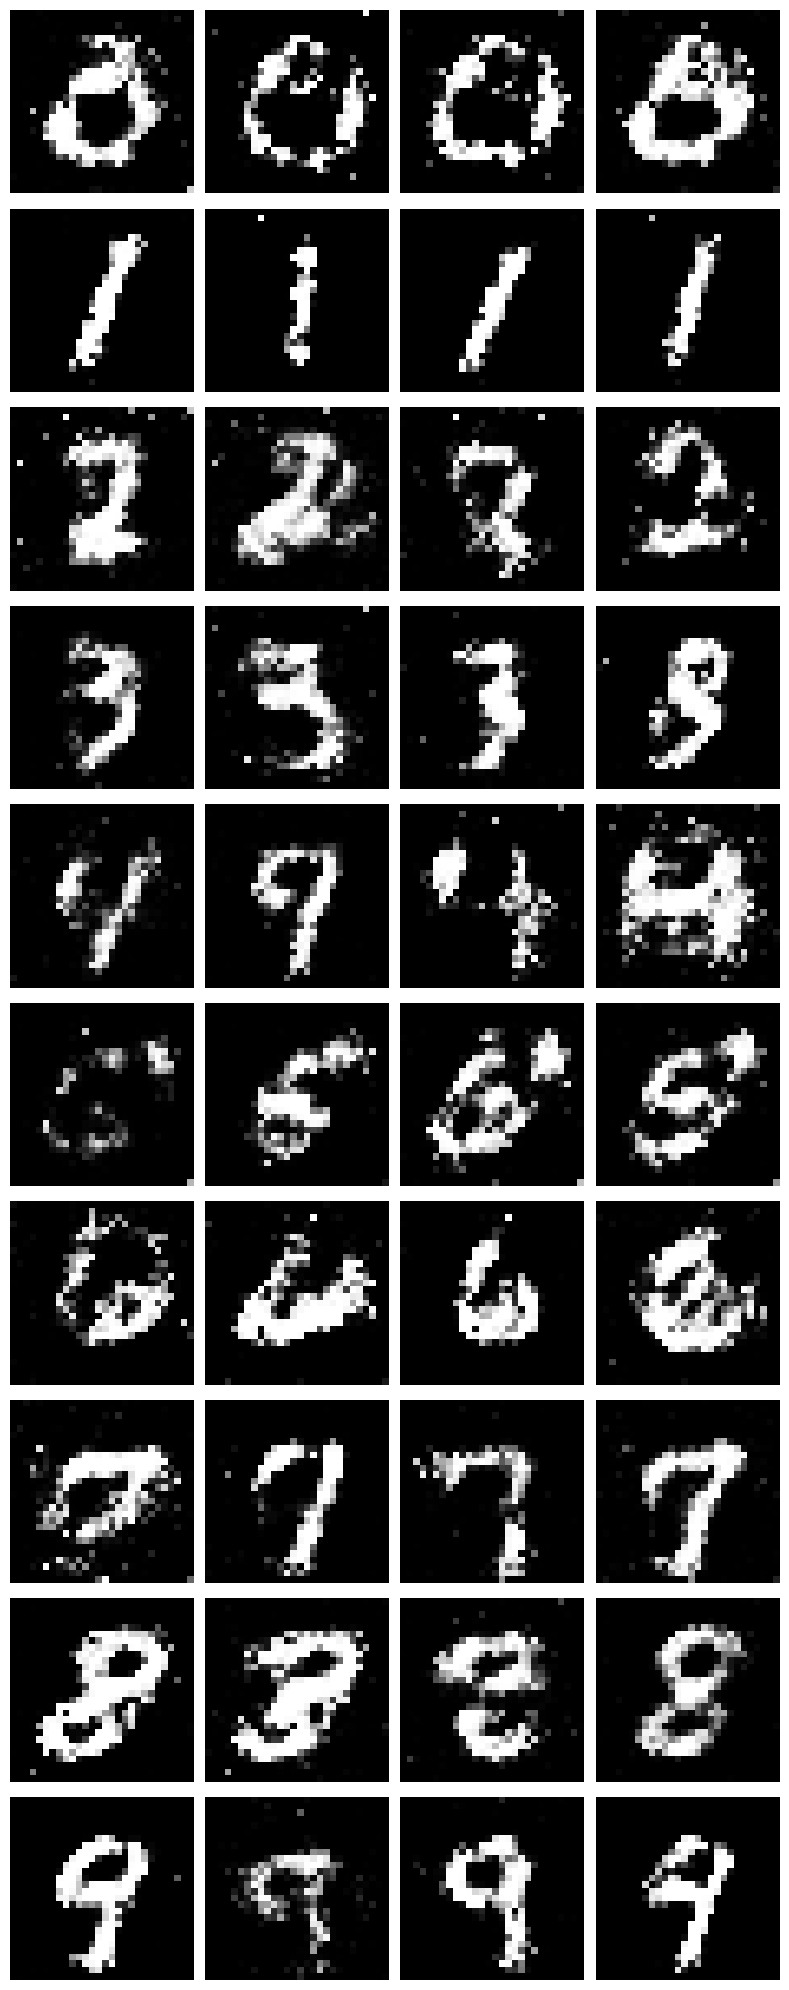

Epoch [6/50] Batch [0/938] Loss D: 1.3623, Loss G: 0.9479
Epoch [6/50] Batch [100/938] Loss D: 1.2171, Loss G: 0.8138
Epoch [6/50] Batch [200/938] Loss D: 1.2541, Loss G: 1.0129
Epoch [6/50] Batch [300/938] Loss D: 1.3490, Loss G: 0.9297
Epoch [6/50] Batch [400/938] Loss D: 1.3644, Loss G: 0.9021
Epoch [6/50] Batch [500/938] Loss D: 1.3078, Loss G: 1.0742
Epoch [6/50] Batch [600/938] Loss D: 1.2771, Loss G: 0.8955
Epoch [6/50] Batch [700/938] Loss D: 1.2661, Loss G: 0.8867
Epoch [6/50] Batch [800/938] Loss D: 1.2894, Loss G: 0.8606
Epoch [6/50] Batch [900/938] Loss D: 1.3855, Loss G: 0.7287


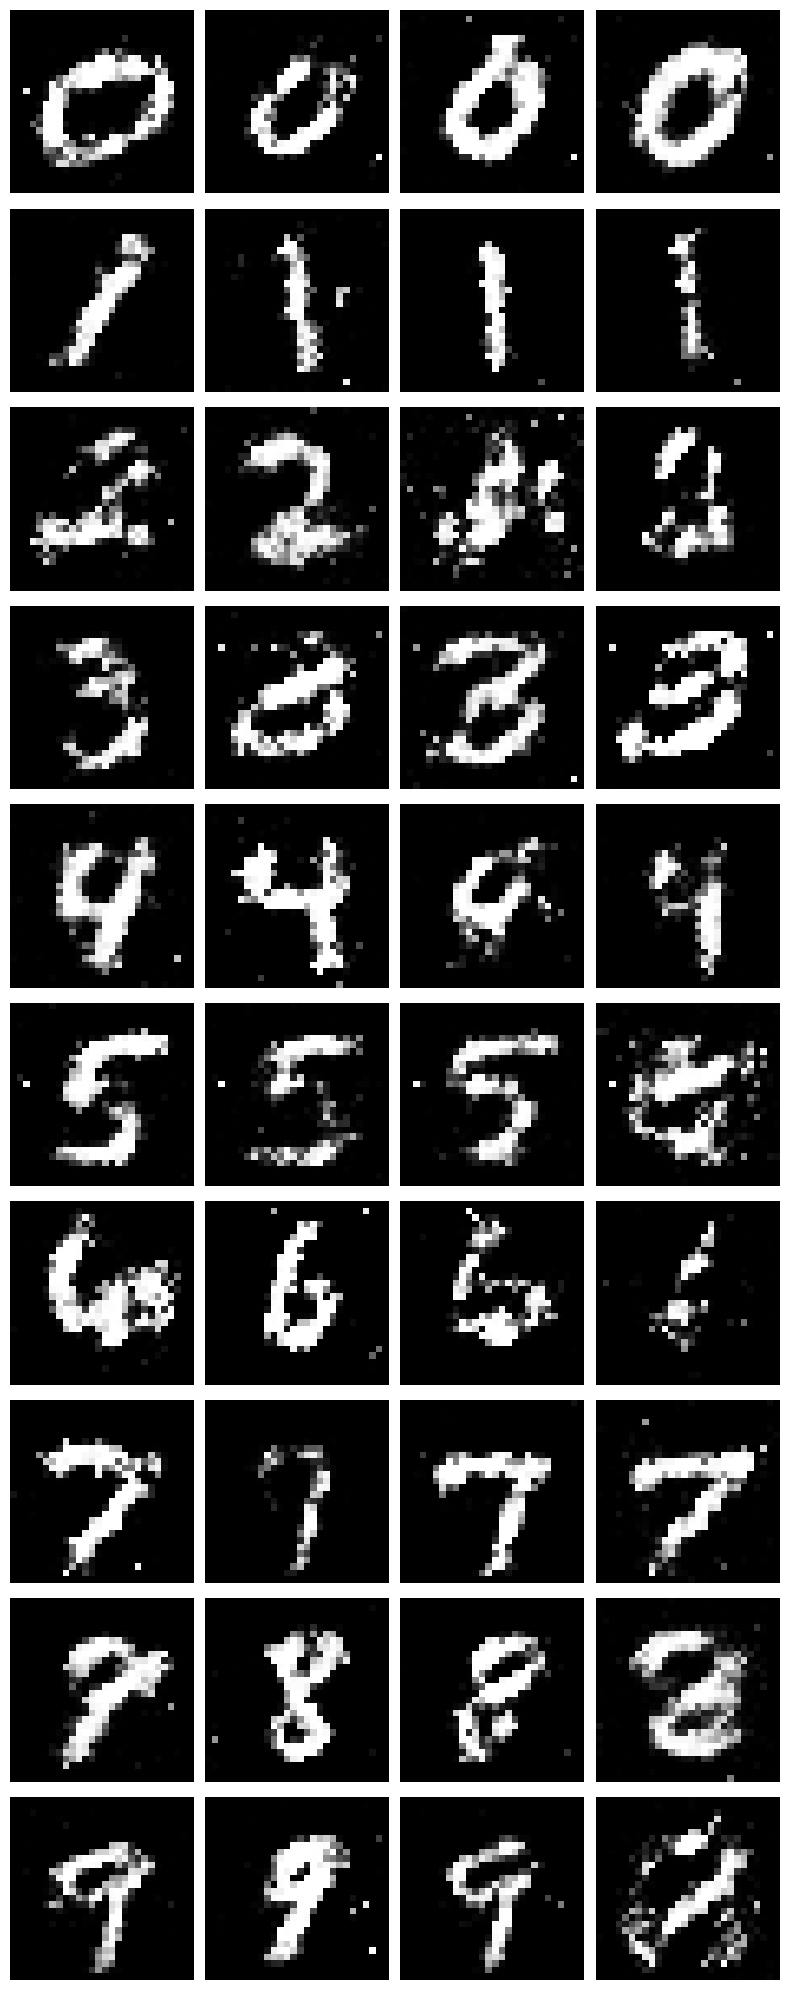

Epoch [7/50] Batch [0/938] Loss D: 1.2178, Loss G: 0.8311
Epoch [7/50] Batch [100/938] Loss D: 1.3027, Loss G: 0.9388
Epoch [7/50] Batch [200/938] Loss D: 1.2463, Loss G: 0.8325
Epoch [7/50] Batch [300/938] Loss D: 1.2719, Loss G: 0.8221
Epoch [7/50] Batch [400/938] Loss D: 1.3368, Loss G: 0.8886
Epoch [7/50] Batch [500/938] Loss D: 1.2156, Loss G: 0.7996
Epoch [7/50] Batch [600/938] Loss D: 1.2591, Loss G: 0.7795
Epoch [7/50] Batch [700/938] Loss D: 1.3112, Loss G: 0.8237
Epoch [7/50] Batch [800/938] Loss D: 1.2437, Loss G: 0.8127
Epoch [7/50] Batch [900/938] Loss D: 1.2799, Loss G: 0.9149


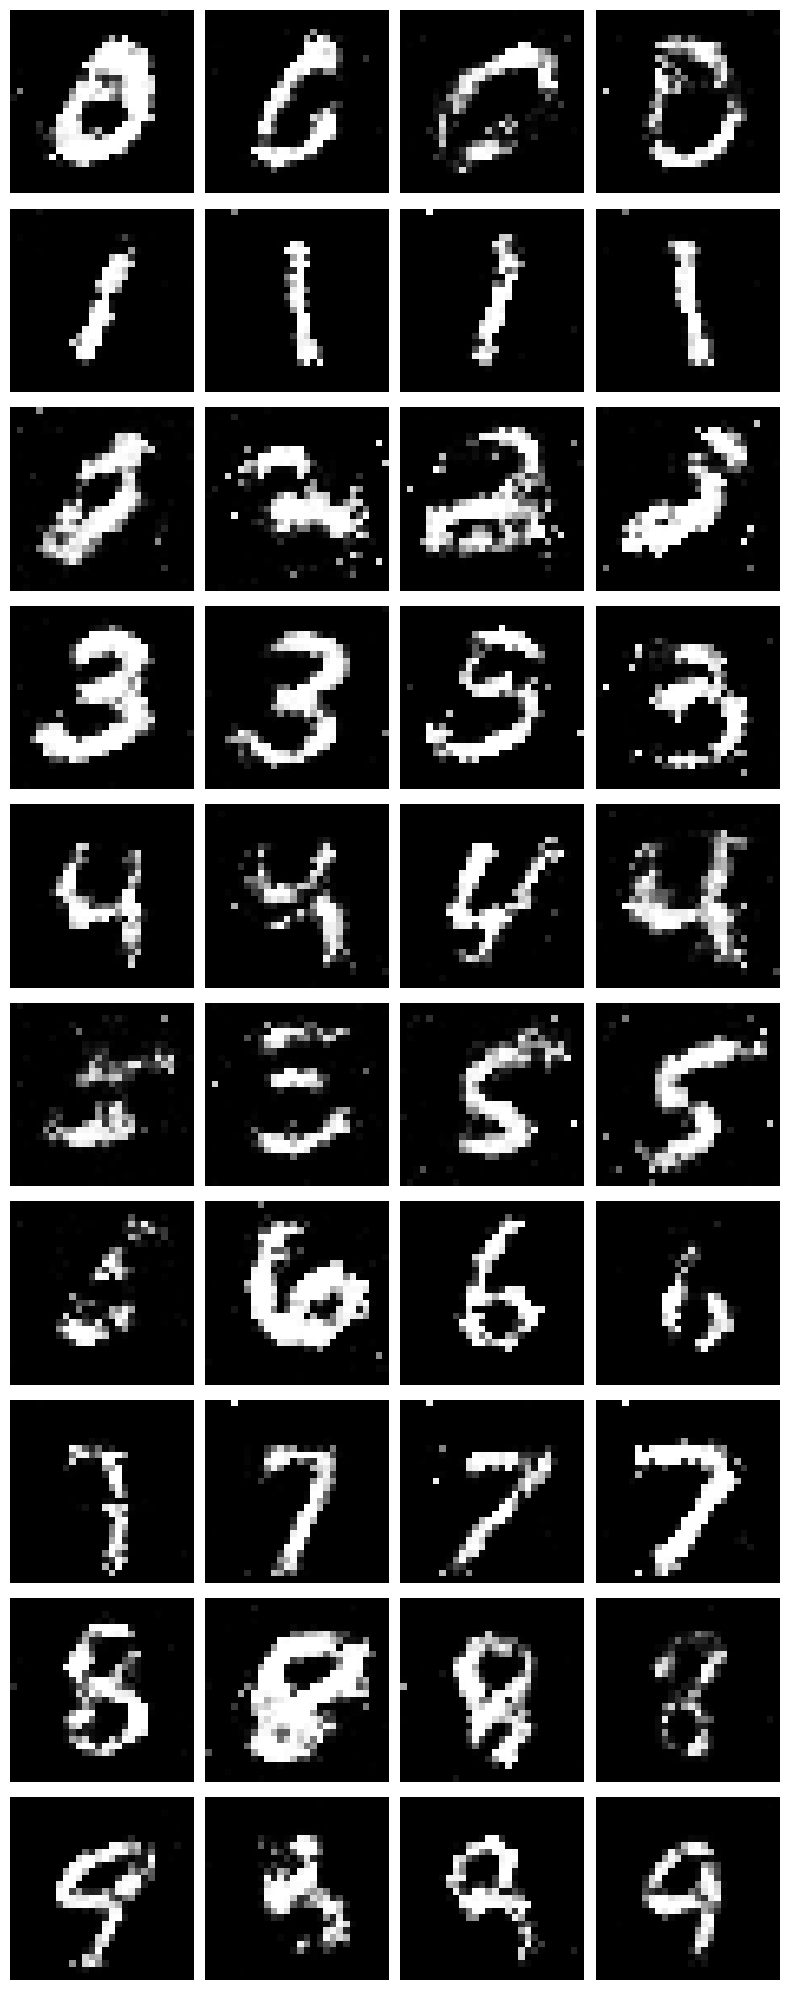

Epoch [8/50] Batch [0/938] Loss D: 1.2760, Loss G: 0.9067
Epoch [8/50] Batch [100/938] Loss D: 1.3454, Loss G: 0.7026
Epoch [8/50] Batch [200/938] Loss D: 1.3370, Loss G: 0.8059
Epoch [8/50] Batch [300/938] Loss D: 1.3308, Loss G: 0.8207
Epoch [8/50] Batch [400/938] Loss D: 1.2521, Loss G: 0.7501
Epoch [8/50] Batch [500/938] Loss D: 1.3992, Loss G: 0.7439
Epoch [8/50] Batch [600/938] Loss D: 1.3795, Loss G: 0.7180
Epoch [8/50] Batch [700/938] Loss D: 1.3604, Loss G: 0.7988
Epoch [8/50] Batch [800/938] Loss D: 1.3029, Loss G: 0.7852
Epoch [8/50] Batch [900/938] Loss D: 1.3607, Loss G: 0.7032


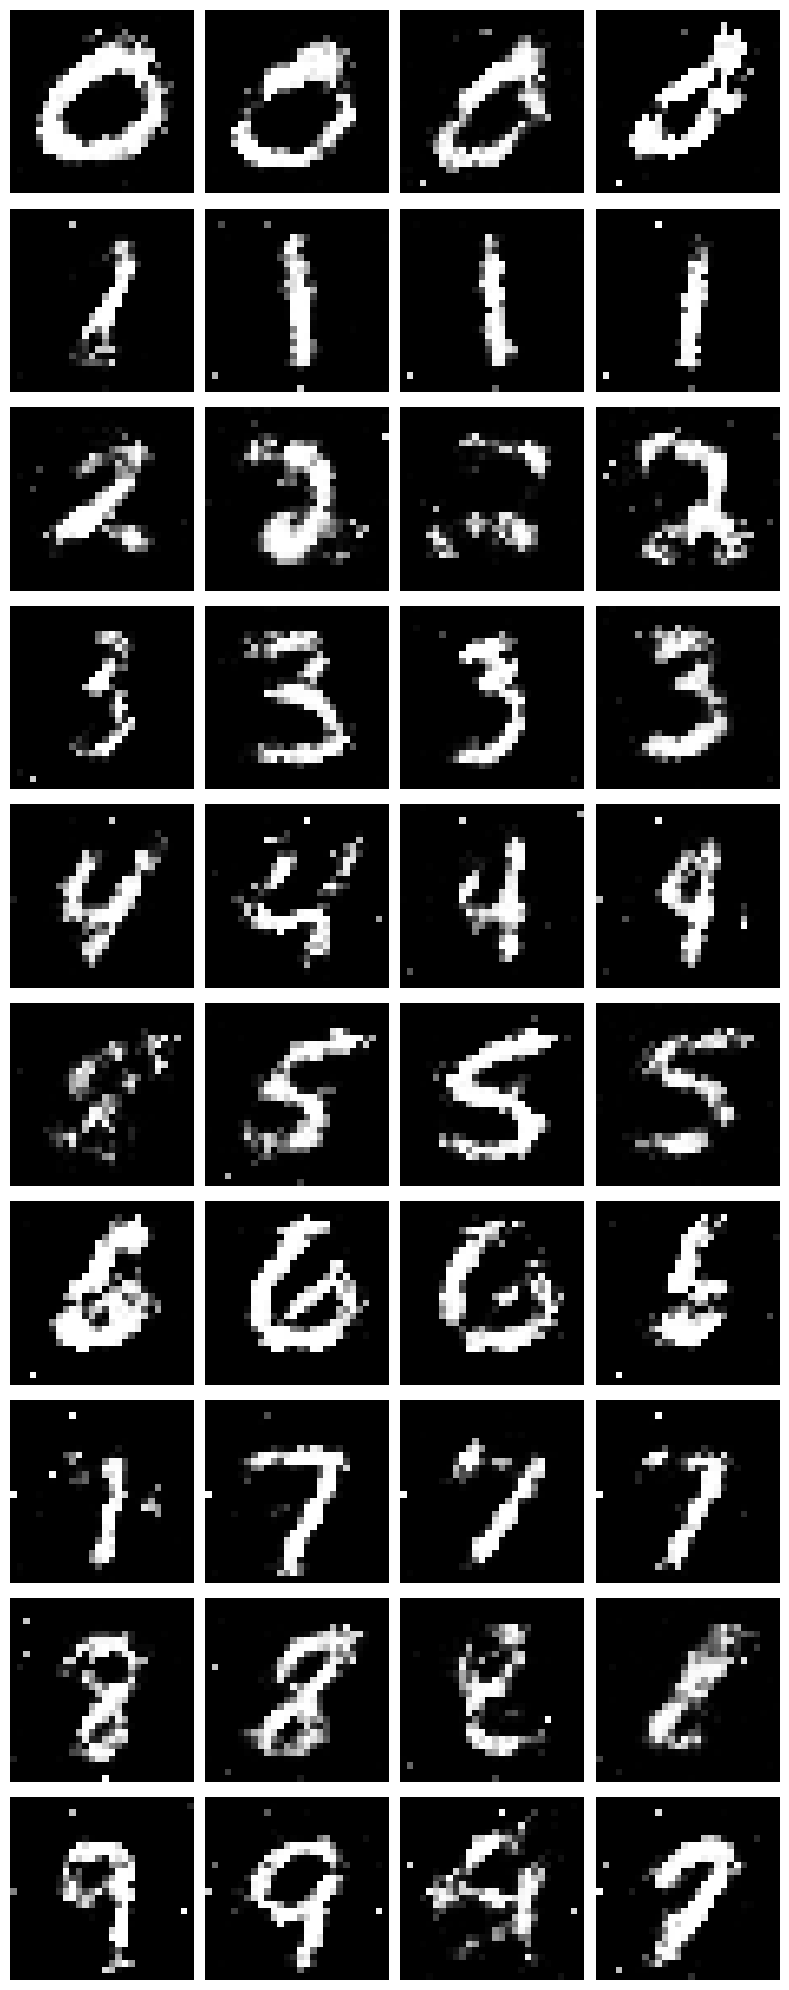

Epoch [9/50] Batch [0/938] Loss D: 1.3361, Loss G: 0.9294
Epoch [9/50] Batch [100/938] Loss D: 1.3098, Loss G: 0.8031
Epoch [9/50] Batch [200/938] Loss D: 1.3222, Loss G: 0.7213
Epoch [9/50] Batch [300/938] Loss D: 1.4050, Loss G: 0.7489
Epoch [9/50] Batch [400/938] Loss D: 1.3187, Loss G: 0.8762
Epoch [9/50] Batch [500/938] Loss D: 1.3720, Loss G: 0.9074
Epoch [9/50] Batch [600/938] Loss D: 1.3098, Loss G: 0.8627
Epoch [9/50] Batch [700/938] Loss D: 1.3376, Loss G: 0.7804
Epoch [9/50] Batch [800/938] Loss D: 1.3376, Loss G: 0.8018
Epoch [9/50] Batch [900/938] Loss D: 1.3274, Loss G: 0.7536


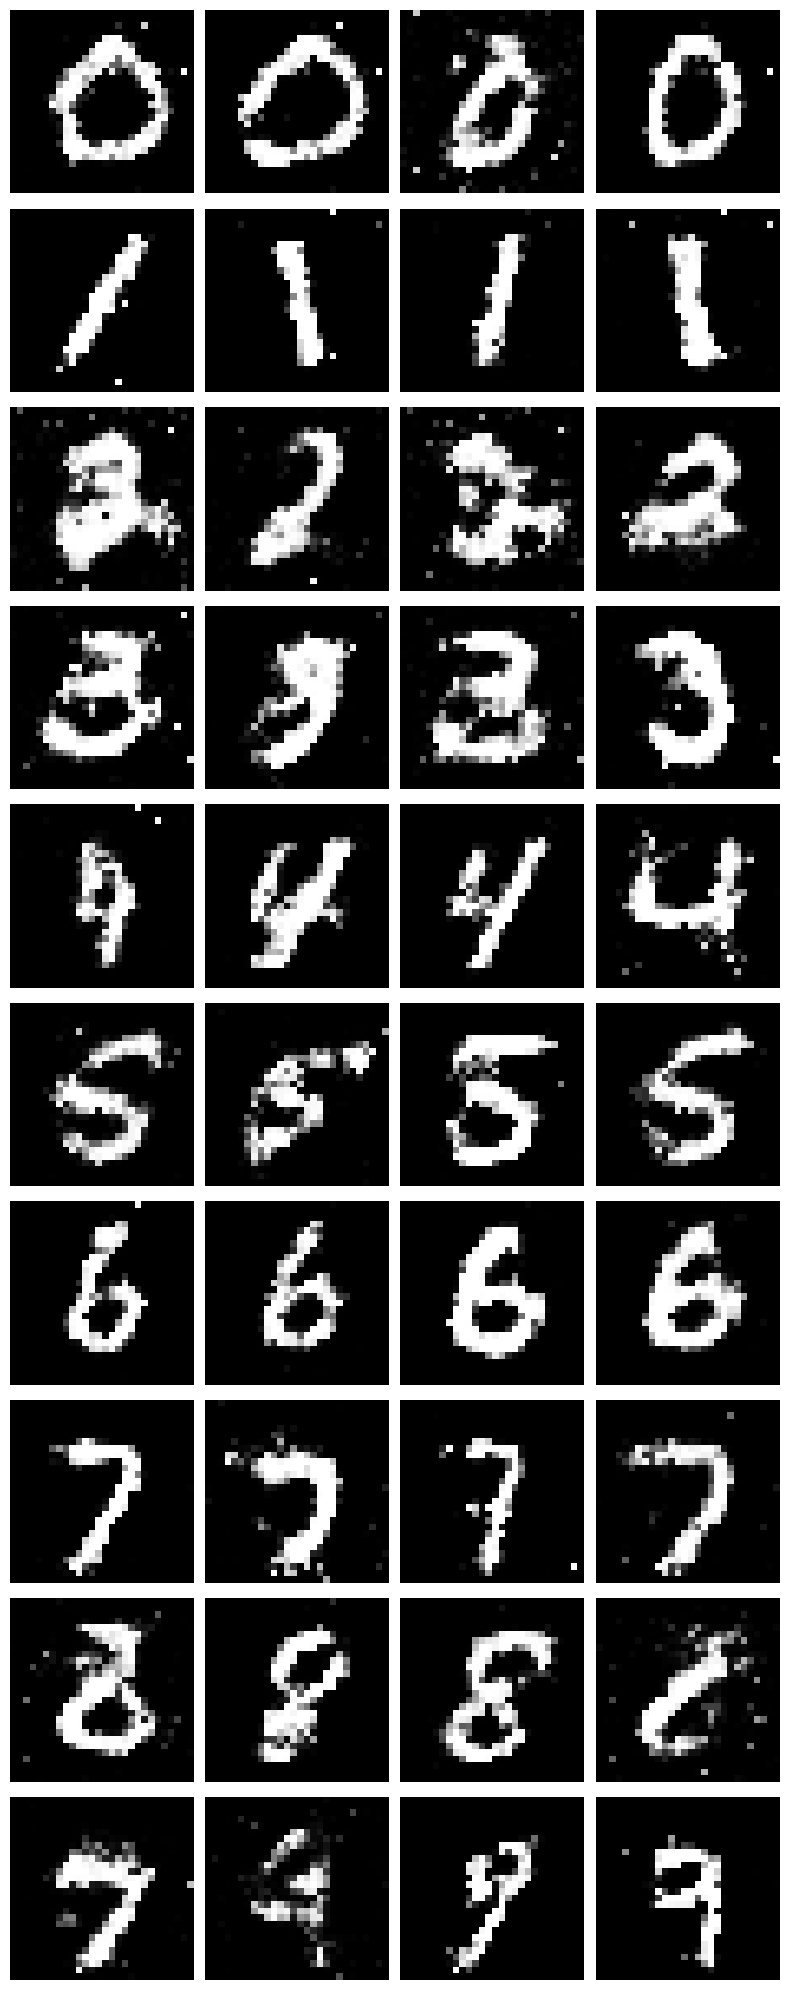

Epoch [10/50] Batch [0/938] Loss D: 1.4096, Loss G: 0.8077
Epoch [10/50] Batch [100/938] Loss D: 1.3017, Loss G: 0.7438
Epoch [10/50] Batch [200/938] Loss D: 1.3727, Loss G: 0.8795
Epoch [10/50] Batch [300/938] Loss D: 1.2754, Loss G: 0.6614
Epoch [10/50] Batch [400/938] Loss D: 1.3431, Loss G: 0.7081
Epoch [10/50] Batch [500/938] Loss D: 1.3399, Loss G: 0.7227
Epoch [10/50] Batch [600/938] Loss D: 1.4143, Loss G: 0.9173
Epoch [10/50] Batch [700/938] Loss D: 1.3751, Loss G: 0.8029
Epoch [10/50] Batch [800/938] Loss D: 1.3571, Loss G: 0.8303
Epoch [10/50] Batch [900/938] Loss D: 1.4176, Loss G: 0.8945


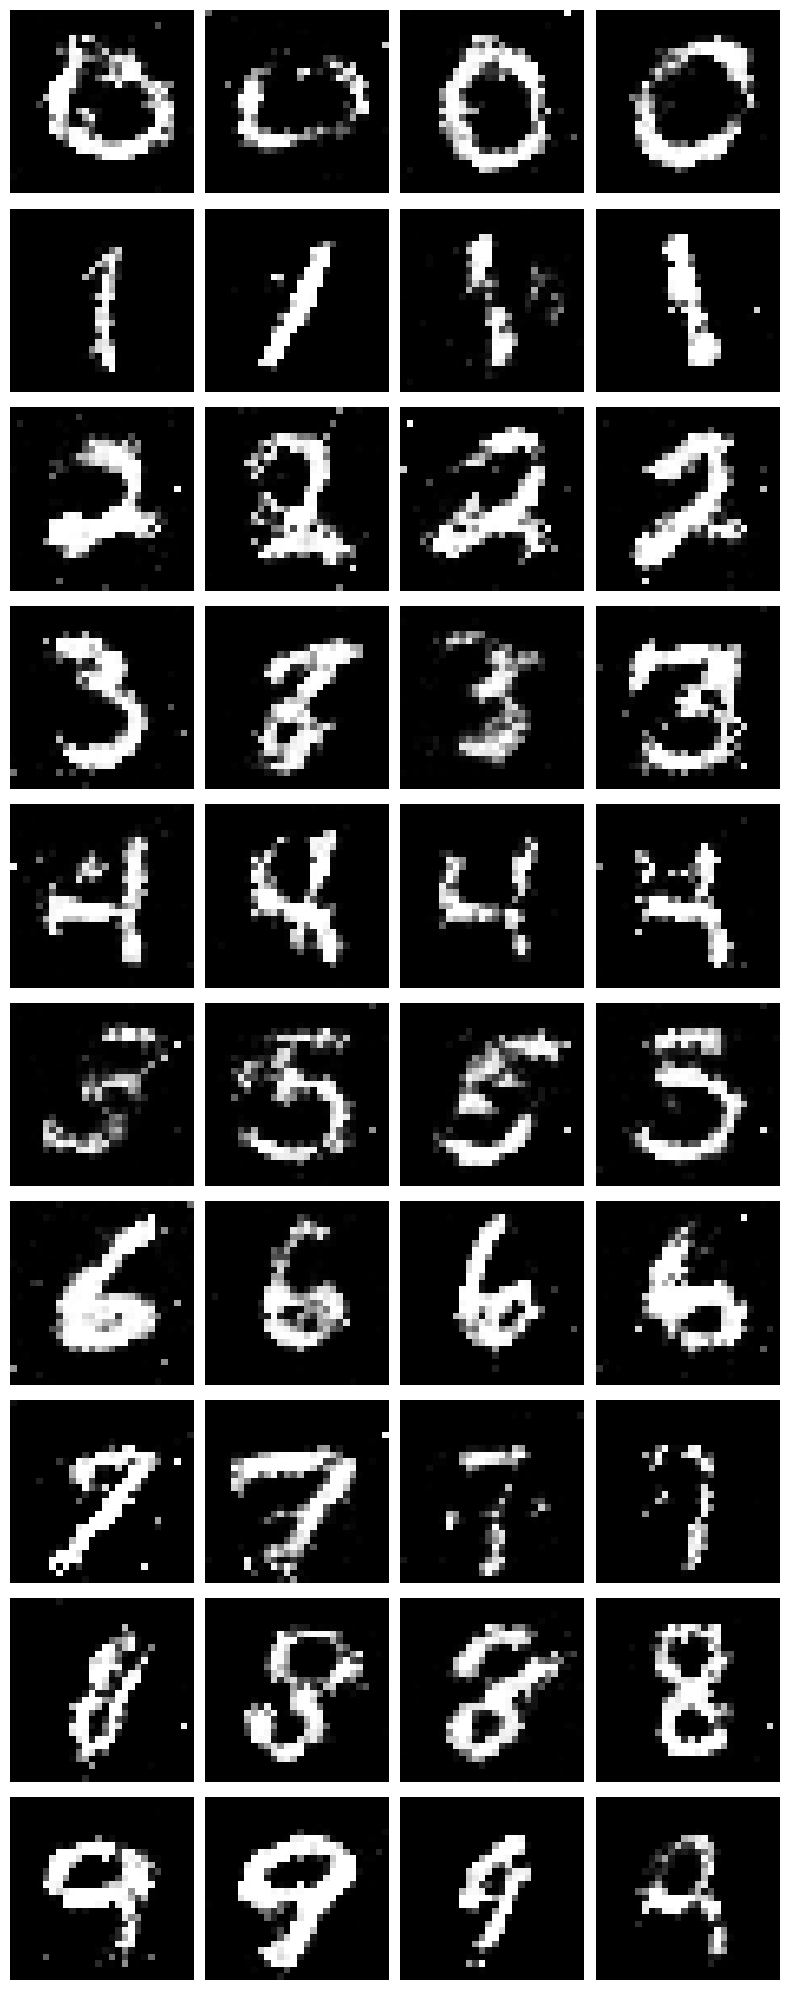

Epoch [11/50] Batch [0/938] Loss D: 1.3603, Loss G: 0.7095
Epoch [11/50] Batch [100/938] Loss D: 1.3545, Loss G: 0.8159
Epoch [11/50] Batch [200/938] Loss D: 1.2970, Loss G: 0.6882
Epoch [11/50] Batch [300/938] Loss D: 1.3354, Loss G: 0.8225
Epoch [11/50] Batch [400/938] Loss D: 1.2659, Loss G: 0.7451
Epoch [11/50] Batch [500/938] Loss D: 1.2993, Loss G: 0.7903
Epoch [11/50] Batch [600/938] Loss D: 1.3723, Loss G: 0.9501
Epoch [11/50] Batch [700/938] Loss D: 1.3328, Loss G: 0.7675
Epoch [11/50] Batch [800/938] Loss D: 1.3007, Loss G: 0.7670
Epoch [11/50] Batch [900/938] Loss D: 1.2788, Loss G: 0.7775


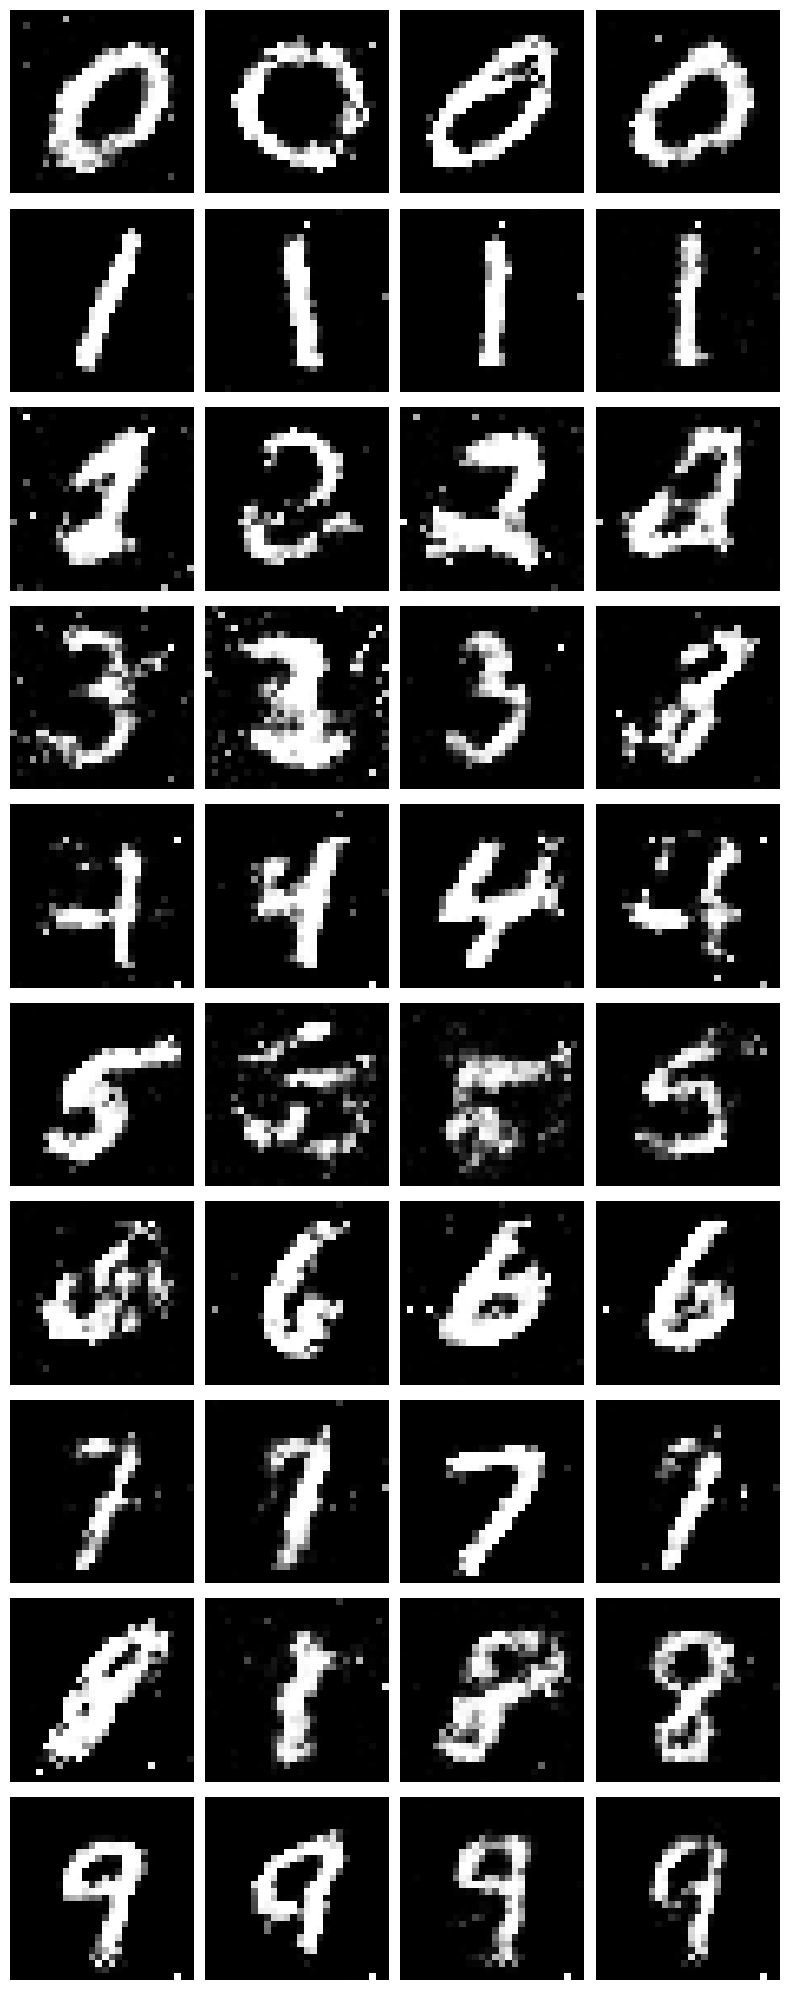

Epoch [12/50] Batch [0/938] Loss D: 1.3373, Loss G: 0.8202
Epoch [12/50] Batch [100/938] Loss D: 1.3696, Loss G: 0.7600
Epoch [12/50] Batch [200/938] Loss D: 1.4081, Loss G: 0.8718
Epoch [12/50] Batch [300/938] Loss D: 1.3921, Loss G: 0.8552
Epoch [12/50] Batch [400/938] Loss D: 1.3605, Loss G: 0.6349
Epoch [12/50] Batch [500/938] Loss D: 1.3234, Loss G: 0.8134
Epoch [12/50] Batch [600/938] Loss D: 1.3292, Loss G: 0.7567
Epoch [12/50] Batch [700/938] Loss D: 1.3435, Loss G: 0.8435
Epoch [12/50] Batch [800/938] Loss D: 1.3443, Loss G: 0.7761
Epoch [12/50] Batch [900/938] Loss D: 1.3879, Loss G: 0.9258


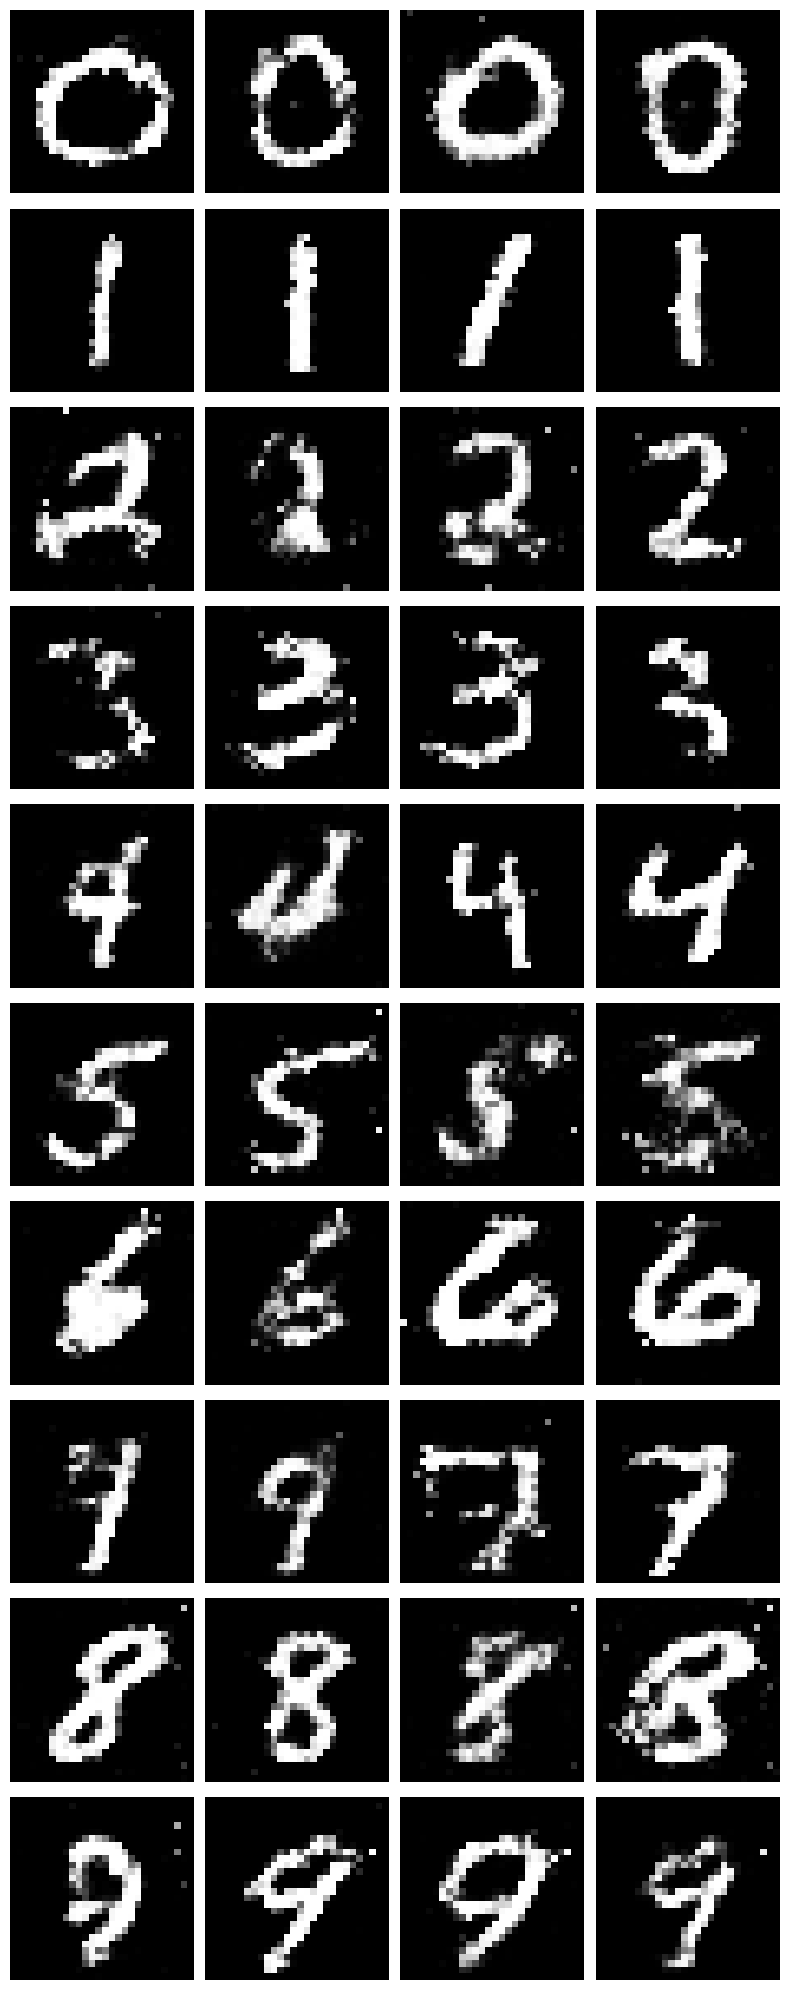

Epoch [13/50] Batch [0/938] Loss D: 1.2905, Loss G: 0.7796
Epoch [13/50] Batch [100/938] Loss D: 1.4312, Loss G: 0.7797
Epoch [13/50] Batch [200/938] Loss D: 1.3133, Loss G: 0.7827
Epoch [13/50] Batch [300/938] Loss D: 1.3468, Loss G: 0.6883
Epoch [13/50] Batch [400/938] Loss D: 1.3092, Loss G: 0.8536
Epoch [13/50] Batch [500/938] Loss D: 1.3819, Loss G: 0.8680
Epoch [13/50] Batch [600/938] Loss D: 1.3785, Loss G: 0.7697
Epoch [13/50] Batch [700/938] Loss D: 1.3472, Loss G: 0.7869
Epoch [13/50] Batch [800/938] Loss D: 1.3328, Loss G: 0.7595
Epoch [13/50] Batch [900/938] Loss D: 1.3800, Loss G: 0.7423


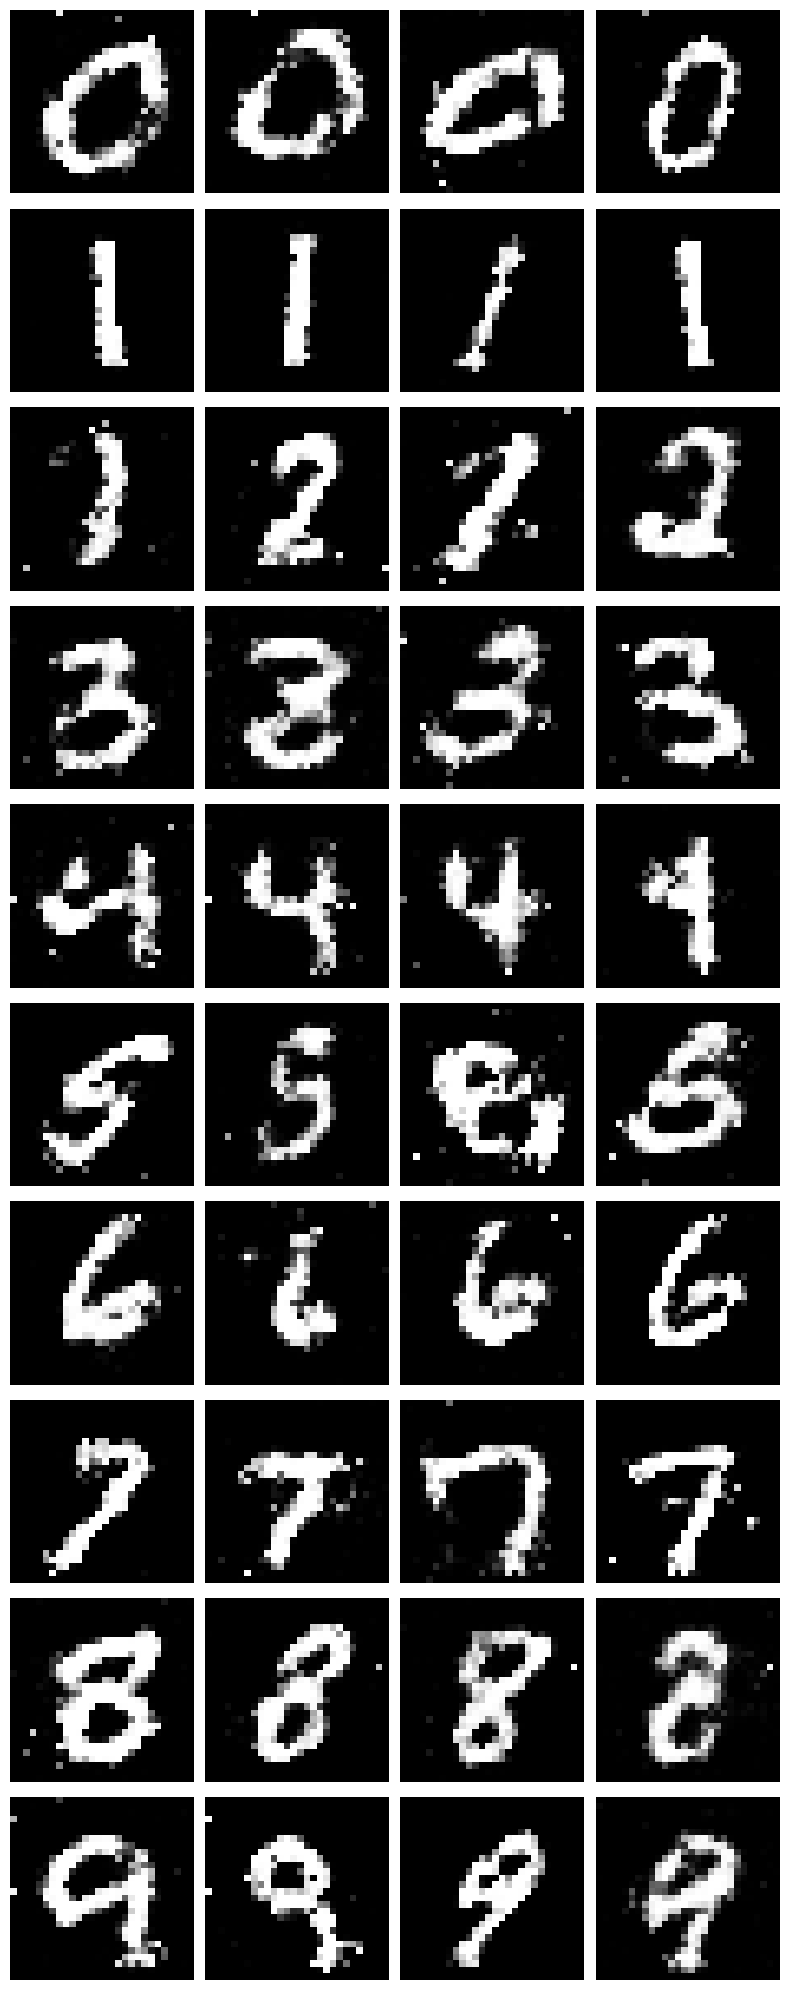

Epoch [14/50] Batch [0/938] Loss D: 1.3272, Loss G: 0.8116
Epoch [14/50] Batch [100/938] Loss D: 1.3205, Loss G: 0.7200
Epoch [14/50] Batch [200/938] Loss D: 1.3711, Loss G: 0.8264
Epoch [14/50] Batch [300/938] Loss D: 1.4011, Loss G: 0.8696
Epoch [14/50] Batch [400/938] Loss D: 1.3387, Loss G: 0.7256
Epoch [14/50] Batch [500/938] Loss D: 1.3510, Loss G: 0.8523
Epoch [14/50] Batch [600/938] Loss D: 1.3918, Loss G: 0.7758
Epoch [14/50] Batch [700/938] Loss D: 1.3691, Loss G: 0.8360
Epoch [14/50] Batch [800/938] Loss D: 1.3755, Loss G: 0.7813
Epoch [14/50] Batch [900/938] Loss D: 1.3526, Loss G: 0.7509


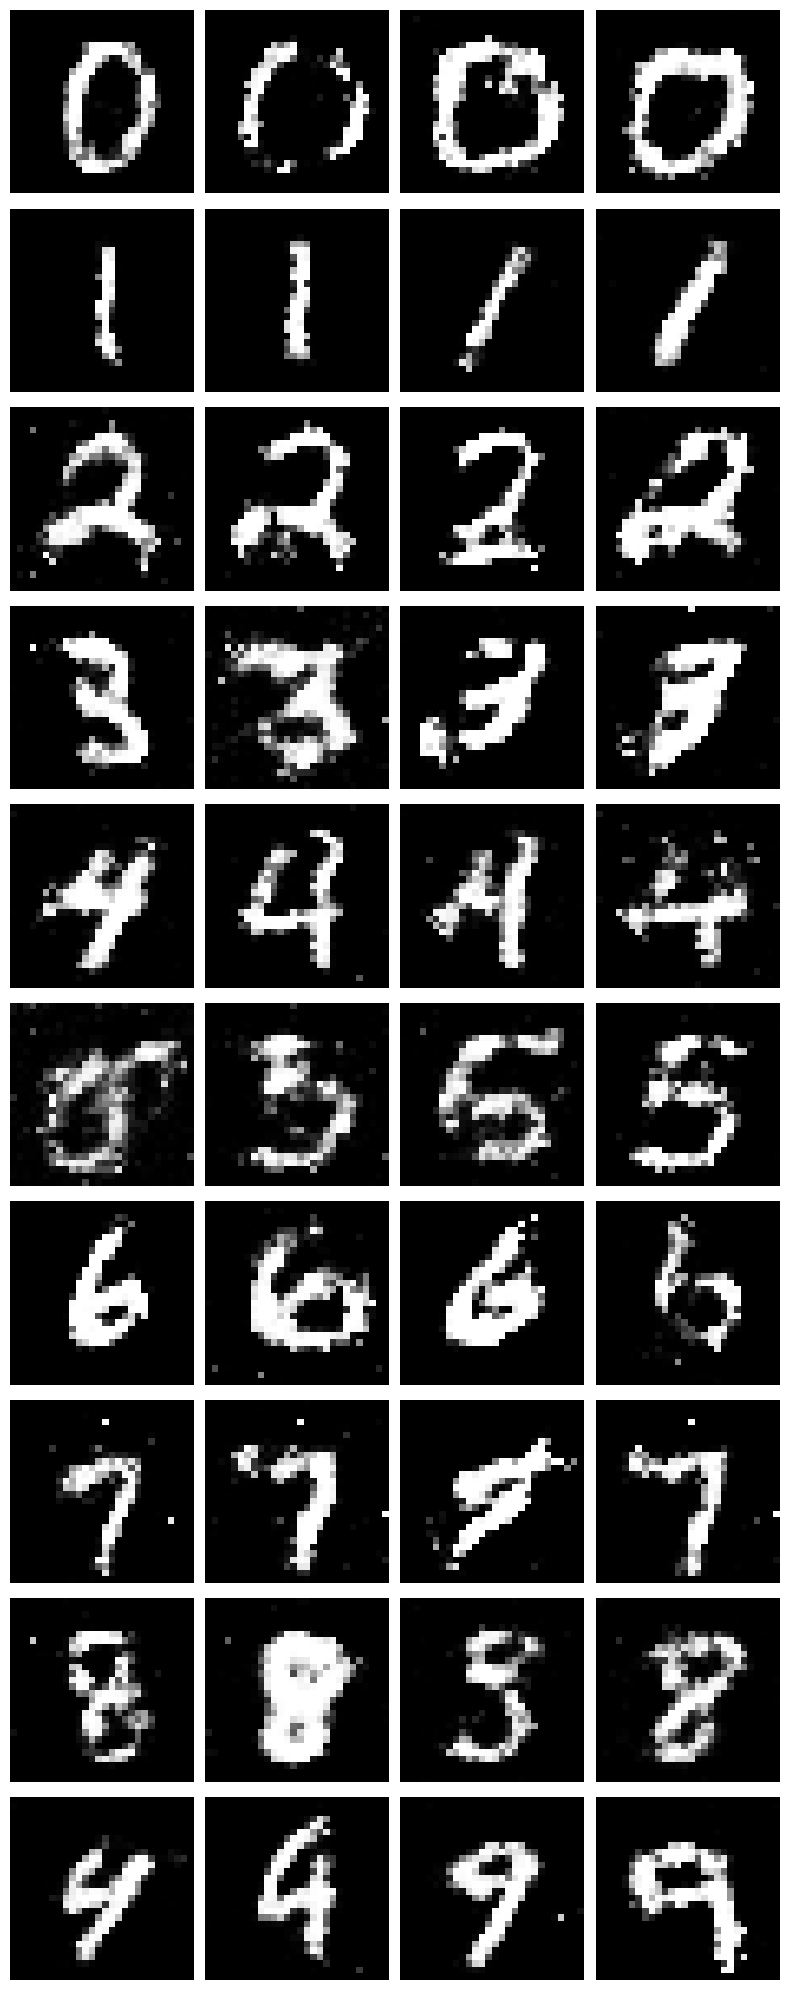

Epoch [15/50] Batch [0/938] Loss D: 1.3545, Loss G: 0.7674
Epoch [15/50] Batch [100/938] Loss D: 1.3963, Loss G: 0.8273
Epoch [15/50] Batch [200/938] Loss D: 1.3754, Loss G: 0.8228
Epoch [15/50] Batch [300/938] Loss D: 1.3208, Loss G: 0.7086
Epoch [15/50] Batch [400/938] Loss D: 1.3680, Loss G: 0.7944
Epoch [15/50] Batch [500/938] Loss D: 1.3737, Loss G: 0.7080
Epoch [15/50] Batch [600/938] Loss D: 1.3441, Loss G: 0.7755
Epoch [15/50] Batch [700/938] Loss D: 1.3867, Loss G: 0.8029
Epoch [15/50] Batch [800/938] Loss D: 1.3721, Loss G: 0.7901
Epoch [15/50] Batch [900/938] Loss D: 1.3301, Loss G: 0.7911


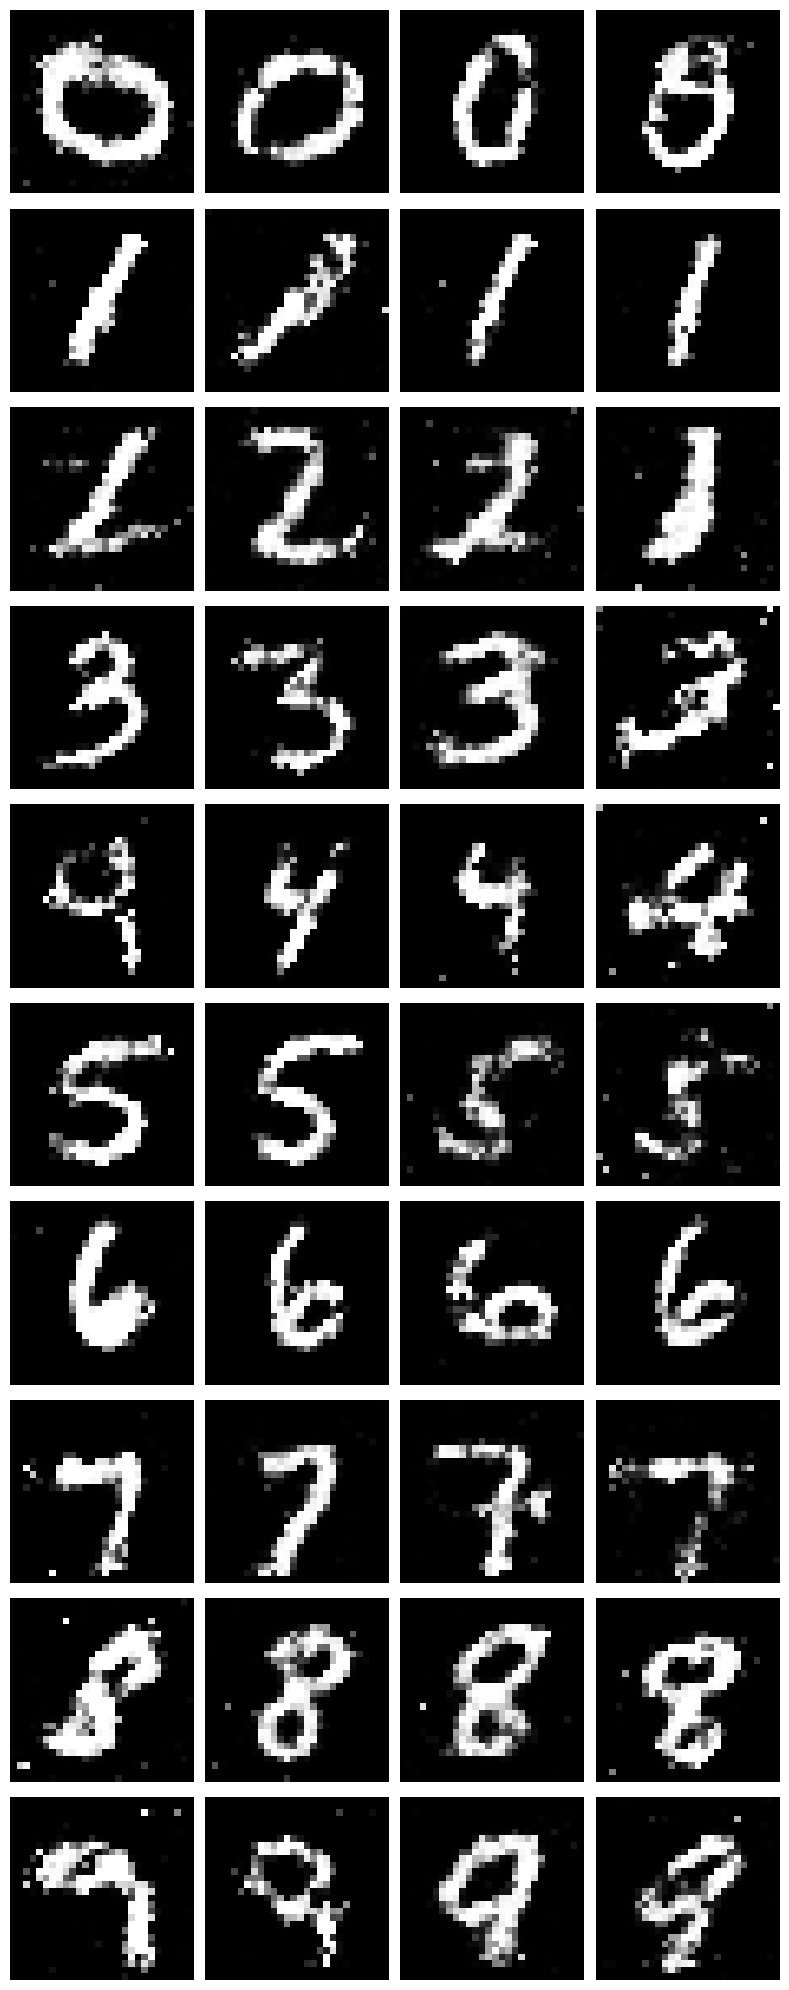

Epoch [16/50] Batch [0/938] Loss D: 1.4428, Loss G: 0.7682
Epoch [16/50] Batch [100/938] Loss D: 1.2721, Loss G: 0.7743
Epoch [16/50] Batch [200/938] Loss D: 1.3918, Loss G: 0.8025
Epoch [16/50] Batch [300/938] Loss D: 1.3497, Loss G: 0.7417
Epoch [16/50] Batch [400/938] Loss D: 1.3291, Loss G: 0.7280
Epoch [16/50] Batch [500/938] Loss D: 1.3272, Loss G: 0.8070
Epoch [16/50] Batch [600/938] Loss D: 1.4007, Loss G: 0.8470
Epoch [16/50] Batch [700/938] Loss D: 1.4768, Loss G: 0.8776
Epoch [16/50] Batch [800/938] Loss D: 1.3067, Loss G: 0.6867
Epoch [16/50] Batch [900/938] Loss D: 1.3457, Loss G: 0.6685


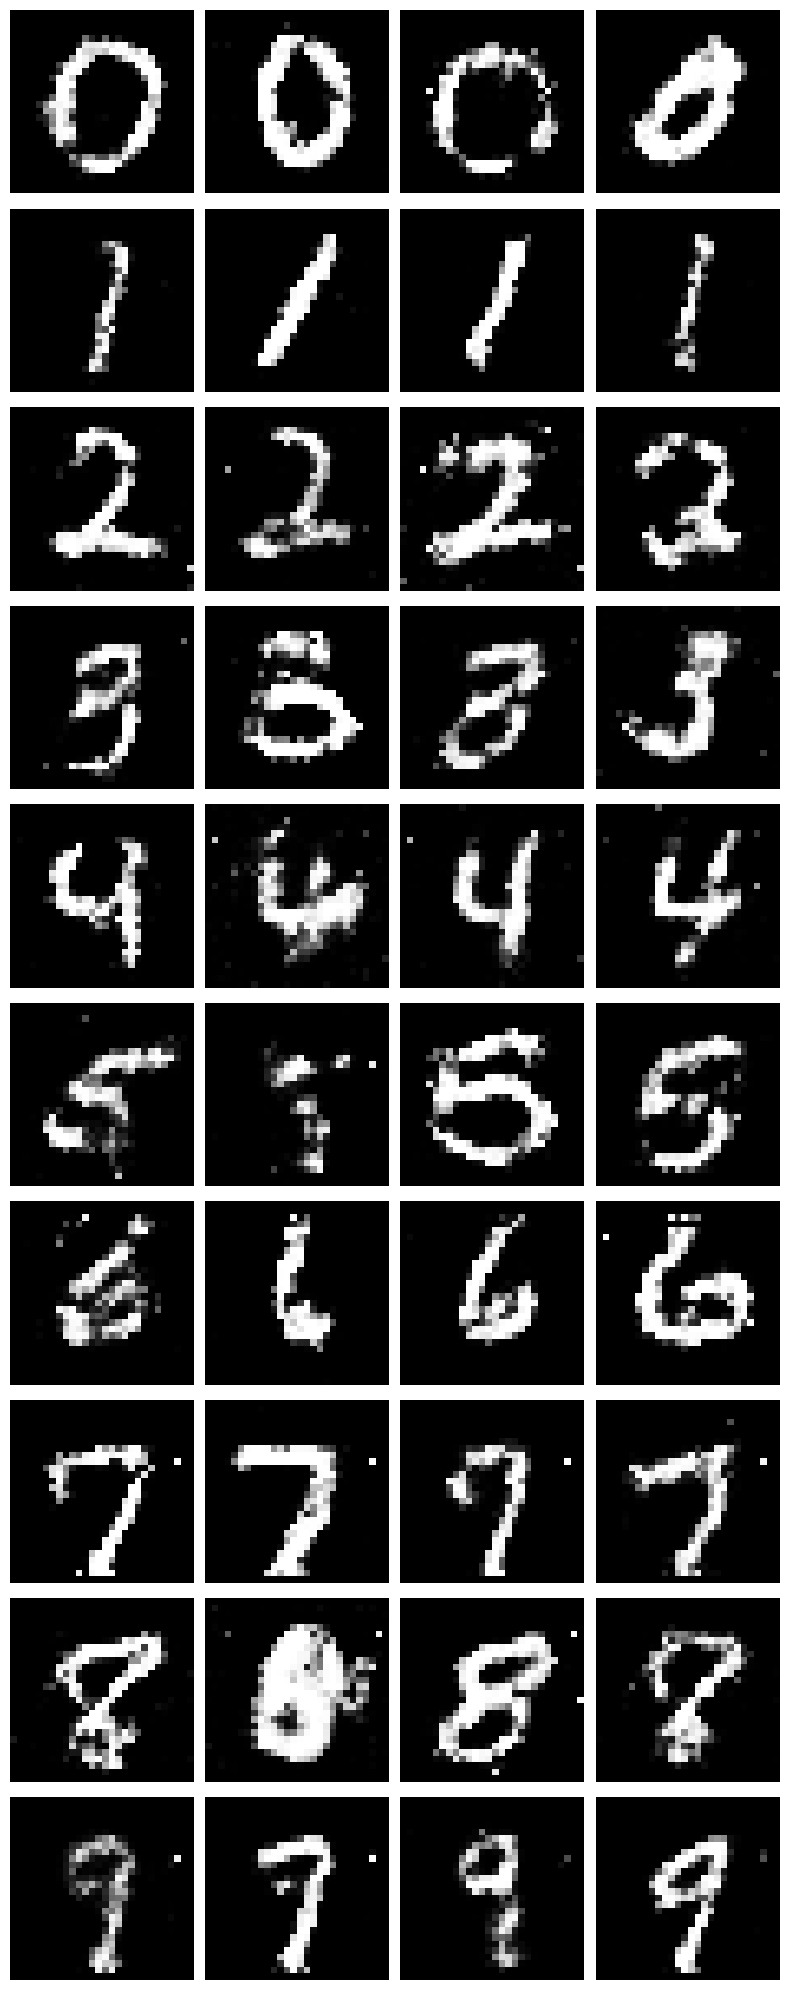

Epoch [17/50] Batch [0/938] Loss D: 1.3230, Loss G: 0.8134
Epoch [17/50] Batch [100/938] Loss D: 1.3517, Loss G: 0.7552
Epoch [17/50] Batch [200/938] Loss D: 1.3314, Loss G: 0.7365
Epoch [17/50] Batch [300/938] Loss D: 1.3256, Loss G: 0.7463
Epoch [17/50] Batch [400/938] Loss D: 1.3976, Loss G: 0.7605
Epoch [17/50] Batch [500/938] Loss D: 1.3413, Loss G: 0.6680
Epoch [17/50] Batch [600/938] Loss D: 1.3840, Loss G: 0.8079
Epoch [17/50] Batch [700/938] Loss D: 1.3811, Loss G: 0.7259
Epoch [17/50] Batch [800/938] Loss D: 1.4189, Loss G: 0.7606
Epoch [17/50] Batch [900/938] Loss D: 1.4813, Loss G: 0.8029


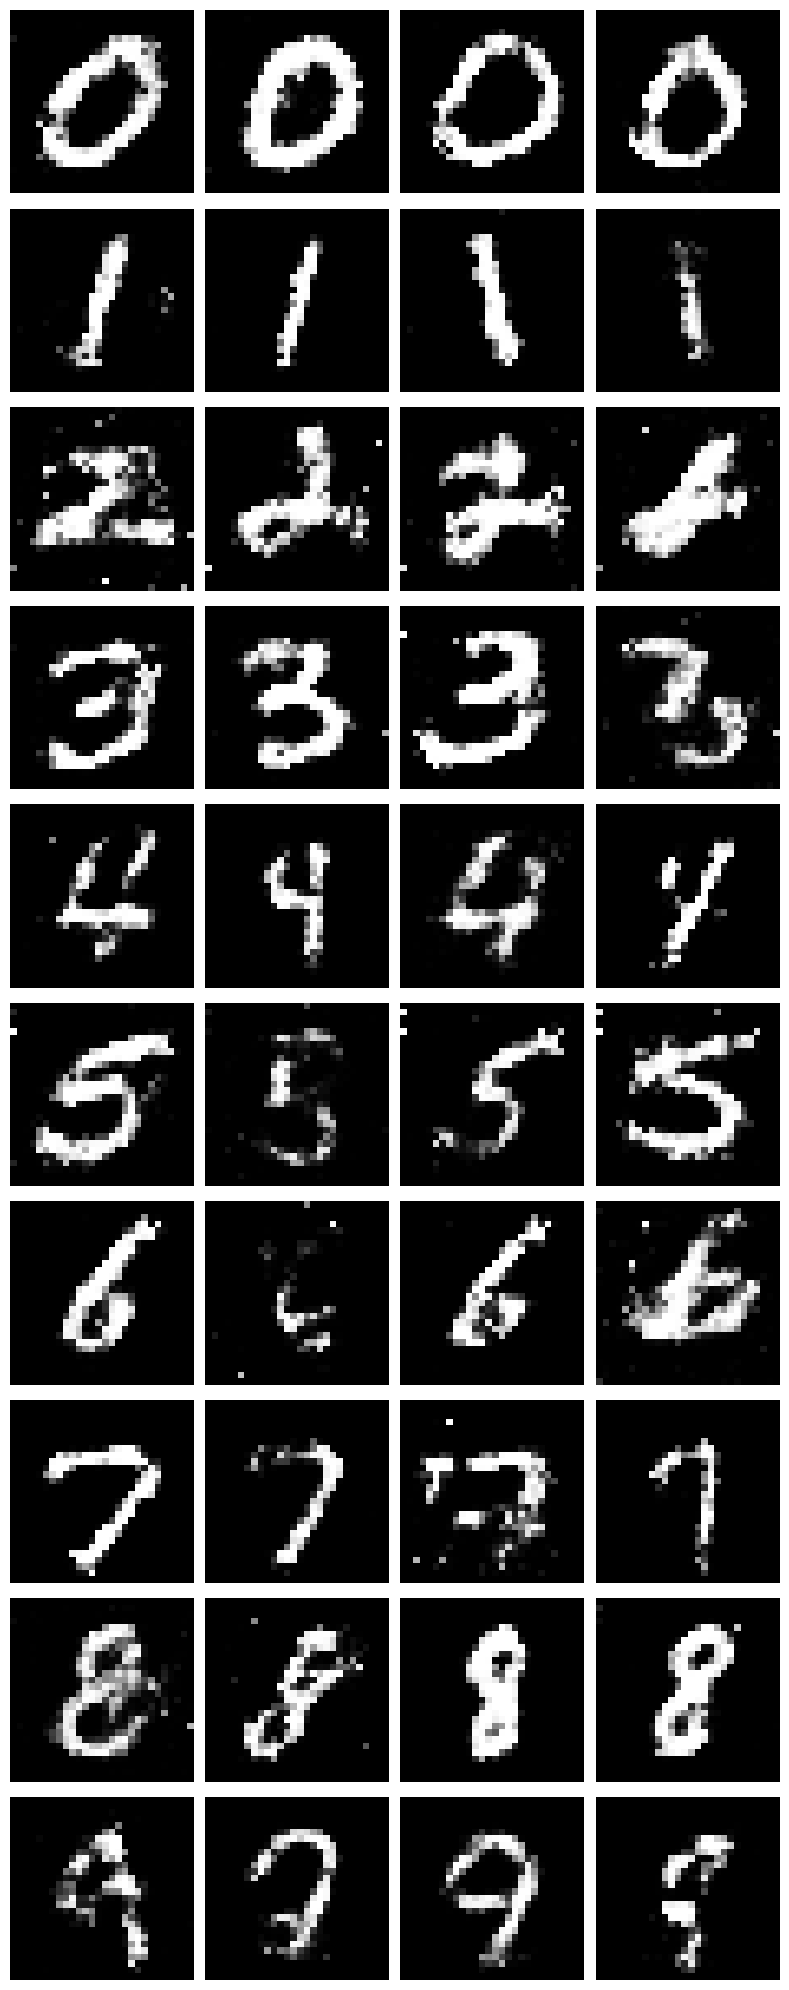

Epoch [18/50] Batch [0/938] Loss D: 1.3676, Loss G: 0.7574
Epoch [18/50] Batch [100/938] Loss D: 1.3259, Loss G: 0.7451
Epoch [18/50] Batch [200/938] Loss D: 1.3585, Loss G: 0.7603
Epoch [18/50] Batch [300/938] Loss D: 1.4238, Loss G: 0.7458
Epoch [18/50] Batch [400/938] Loss D: 1.3832, Loss G: 0.7280
Epoch [18/50] Batch [500/938] Loss D: 1.3438, Loss G: 0.7448
Epoch [18/50] Batch [600/938] Loss D: 1.4034, Loss G: 0.7375
Epoch [18/50] Batch [700/938] Loss D: 1.4207, Loss G: 0.7440
Epoch [18/50] Batch [800/938] Loss D: 1.3463, Loss G: 0.7911
Epoch [18/50] Batch [900/938] Loss D: 1.3382, Loss G: 0.7066


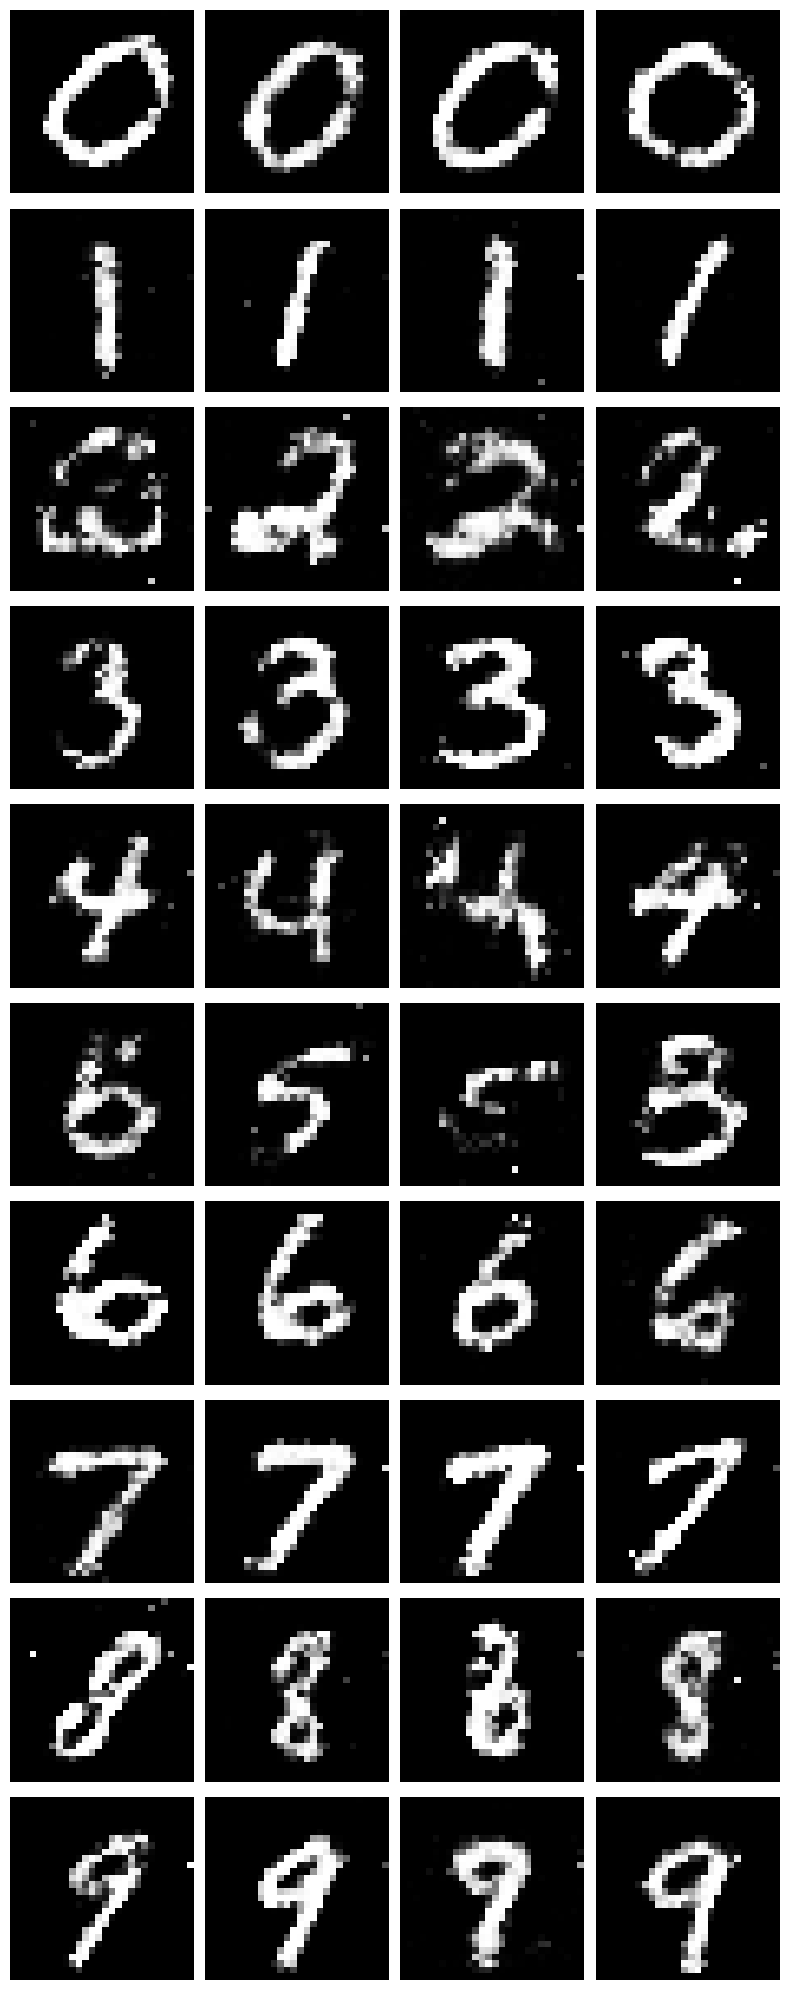

Epoch [19/50] Batch [0/938] Loss D: 1.3675, Loss G: 0.7294
Epoch [19/50] Batch [100/938] Loss D: 1.3893, Loss G: 0.7493
Epoch [19/50] Batch [200/938] Loss D: 1.3880, Loss G: 0.8749
Epoch [19/50] Batch [300/938] Loss D: 1.3256, Loss G: 0.7542
Epoch [19/50] Batch [400/938] Loss D: 1.3548, Loss G: 0.7211
Epoch [19/50] Batch [500/938] Loss D: 1.3397, Loss G: 0.7337
Epoch [19/50] Batch [600/938] Loss D: 1.3756, Loss G: 0.7077
Epoch [19/50] Batch [700/938] Loss D: 1.3894, Loss G: 0.6795
Epoch [19/50] Batch [800/938] Loss D: 1.3474, Loss G: 0.7307
Epoch [19/50] Batch [900/938] Loss D: 1.3534, Loss G: 0.7173


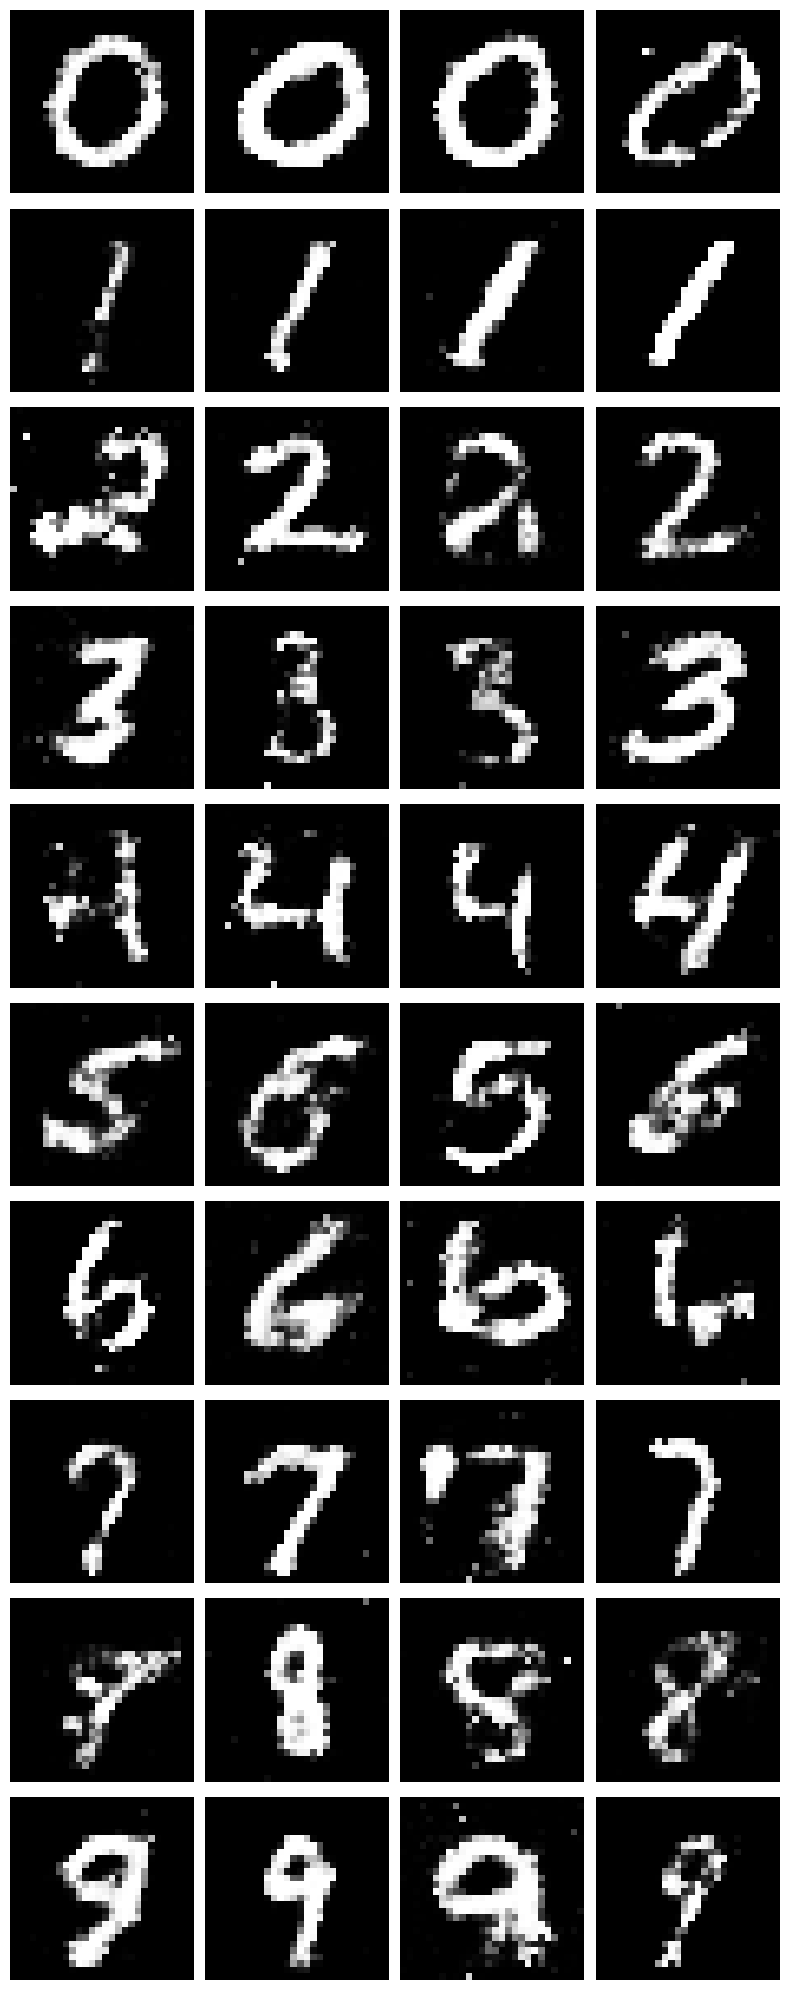

Epoch [20/50] Batch [0/938] Loss D: 1.3468, Loss G: 0.7127
Epoch [20/50] Batch [100/938] Loss D: 1.4241, Loss G: 0.7305
Epoch [20/50] Batch [200/938] Loss D: 1.4020, Loss G: 0.7585
Epoch [20/50] Batch [300/938] Loss D: 1.3373, Loss G: 0.7450
Epoch [20/50] Batch [400/938] Loss D: 1.3241, Loss G: 0.7833
Epoch [20/50] Batch [500/938] Loss D: 1.3545, Loss G: 0.7344
Epoch [20/50] Batch [600/938] Loss D: 1.3600, Loss G: 0.7994
Epoch [20/50] Batch [700/938] Loss D: 1.3424, Loss G: 0.7190
Epoch [20/50] Batch [800/938] Loss D: 1.3798, Loss G: 0.7637
Epoch [20/50] Batch [900/938] Loss D: 1.4180, Loss G: 0.8066


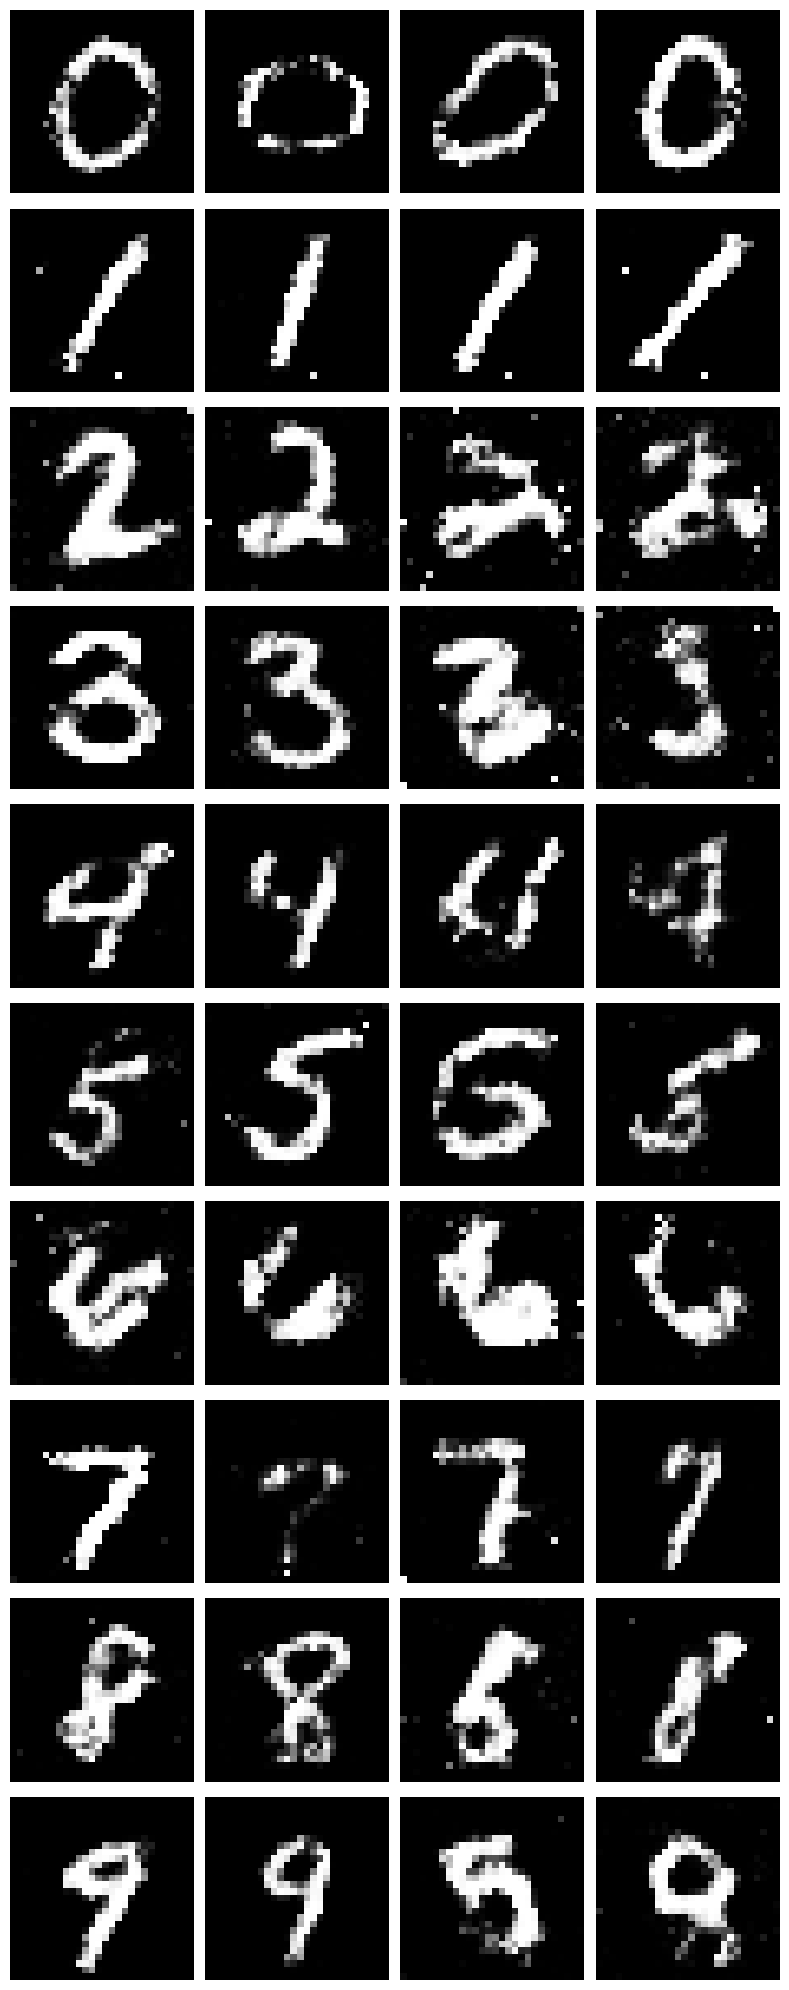

Epoch [21/50] Batch [0/938] Loss D: 1.3681, Loss G: 0.7726
Epoch [21/50] Batch [100/938] Loss D: 1.3539, Loss G: 0.8223
Epoch [21/50] Batch [200/938] Loss D: 1.3095, Loss G: 0.8103
Epoch [21/50] Batch [300/938] Loss D: 1.3471, Loss G: 0.7217
Epoch [21/50] Batch [400/938] Loss D: 1.3533, Loss G: 0.7501
Epoch [21/50] Batch [500/938] Loss D: 1.3091, Loss G: 0.7114
Epoch [21/50] Batch [600/938] Loss D: 1.3563, Loss G: 0.6829
Epoch [21/50] Batch [700/938] Loss D: 1.3214, Loss G: 0.7322
Epoch [21/50] Batch [800/938] Loss D: 1.4248, Loss G: 0.7398
Epoch [21/50] Batch [900/938] Loss D: 1.3738, Loss G: 0.6971


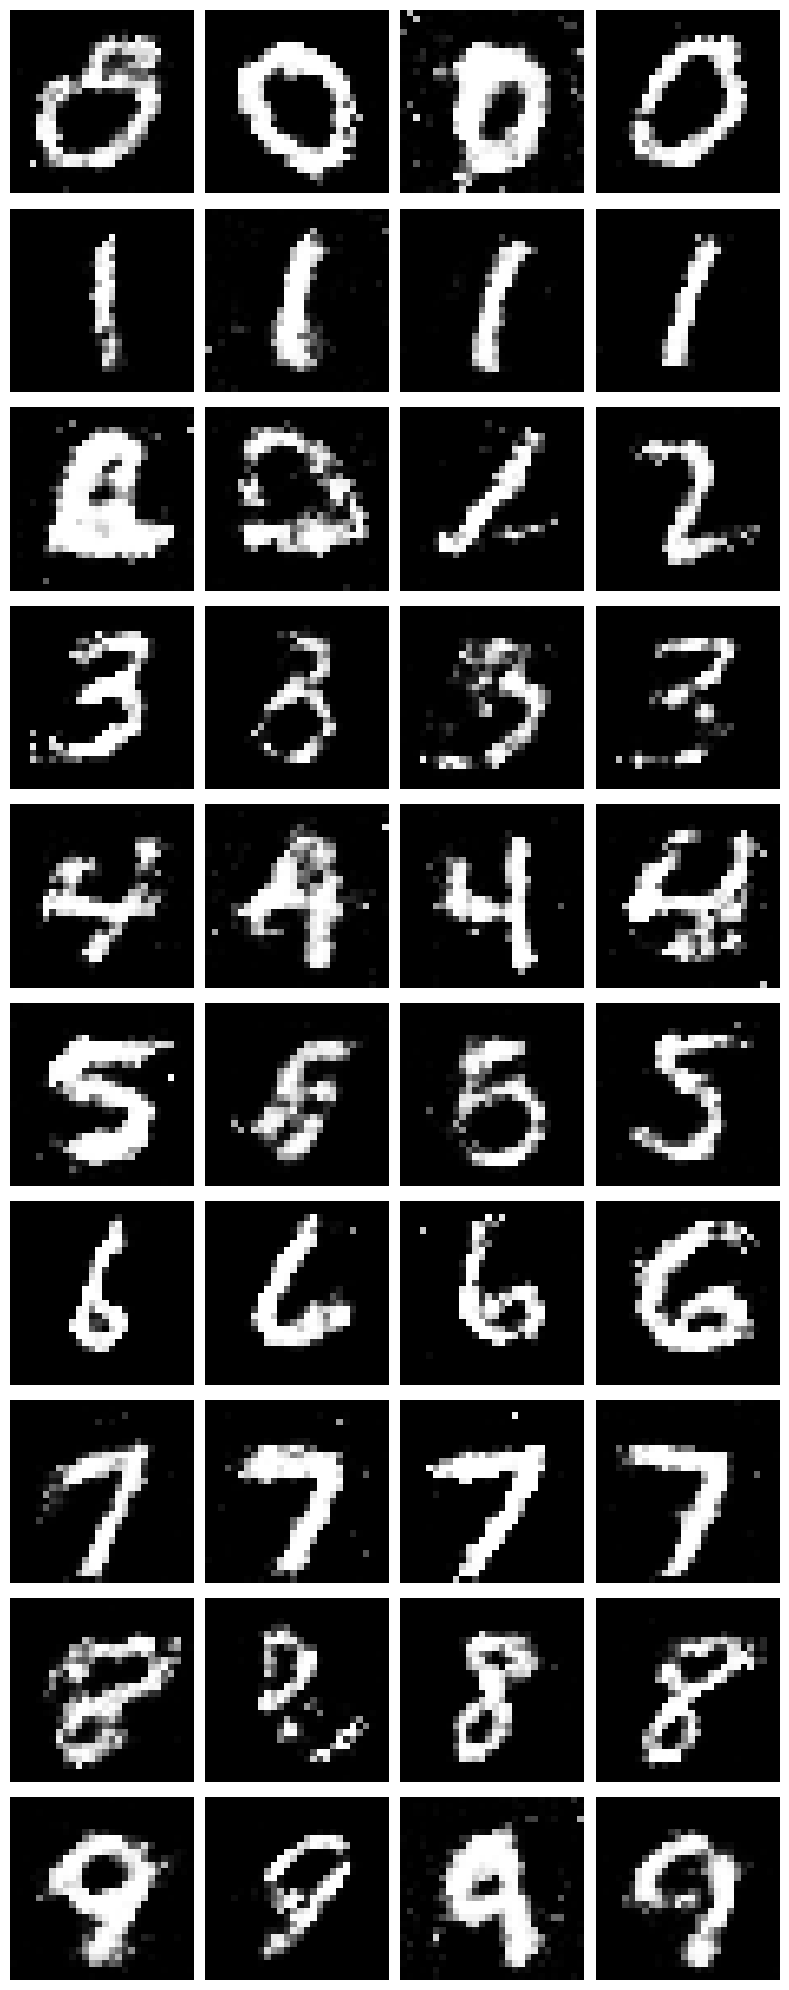

Epoch [22/50] Batch [0/938] Loss D: 1.3405, Loss G: 0.7128
Epoch [22/50] Batch [100/938] Loss D: 1.3530, Loss G: 0.7502
Epoch [22/50] Batch [200/938] Loss D: 1.3696, Loss G: 0.7673
Epoch [22/50] Batch [300/938] Loss D: 1.3793, Loss G: 0.7039
Epoch [22/50] Batch [400/938] Loss D: 1.3555, Loss G: 0.7686
Epoch [22/50] Batch [500/938] Loss D: 1.3153, Loss G: 0.7618
Epoch [22/50] Batch [600/938] Loss D: 1.3764, Loss G: 0.7629
Epoch [22/50] Batch [700/938] Loss D: 1.3655, Loss G: 0.7275
Epoch [22/50] Batch [800/938] Loss D: 1.3906, Loss G: 0.7046
Epoch [22/50] Batch [900/938] Loss D: 1.3613, Loss G: 0.6482


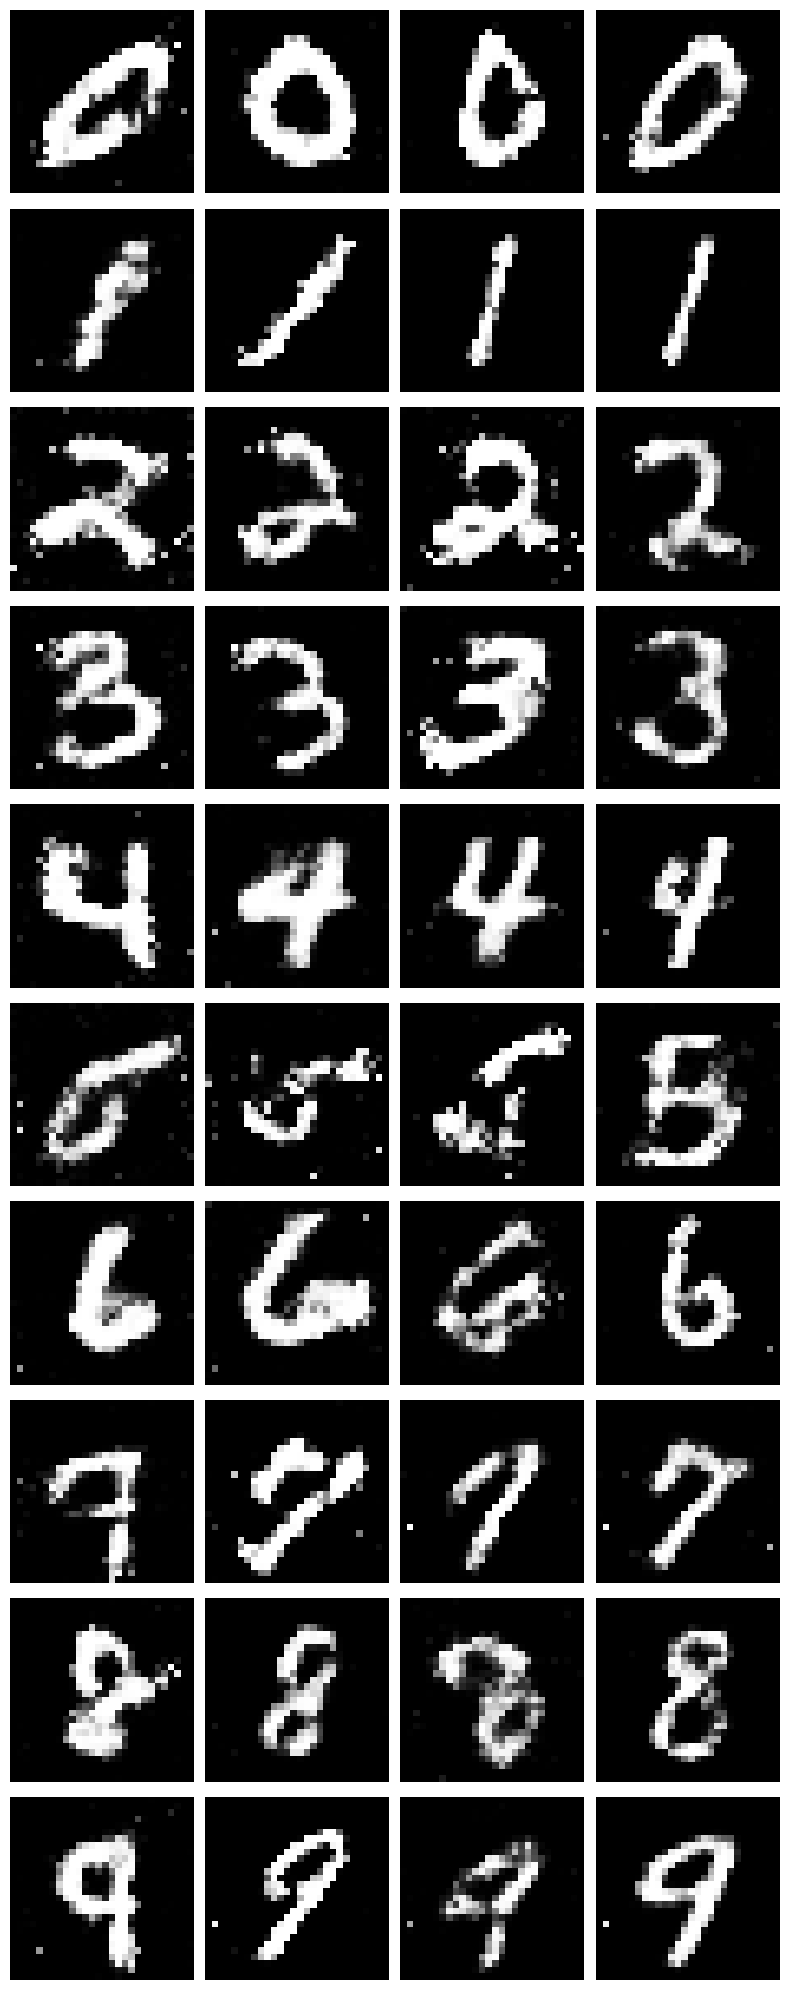

Epoch [23/50] Batch [0/938] Loss D: 1.3326, Loss G: 0.6578
Epoch [23/50] Batch [100/938] Loss D: 1.3893, Loss G: 0.6962
Epoch [23/50] Batch [200/938] Loss D: 1.3977, Loss G: 0.7305
Epoch [23/50] Batch [300/938] Loss D: 1.4045, Loss G: 0.7110
Epoch [23/50] Batch [400/938] Loss D: 1.3550, Loss G: 0.7431
Epoch [23/50] Batch [500/938] Loss D: 1.3651, Loss G: 0.7729
Epoch [23/50] Batch [600/938] Loss D: 1.3417, Loss G: 0.7293
Epoch [23/50] Batch [700/938] Loss D: 1.3897, Loss G: 0.6820
Epoch [23/50] Batch [800/938] Loss D: 1.3983, Loss G: 0.7394
Epoch [23/50] Batch [900/938] Loss D: 1.3067, Loss G: 0.7072


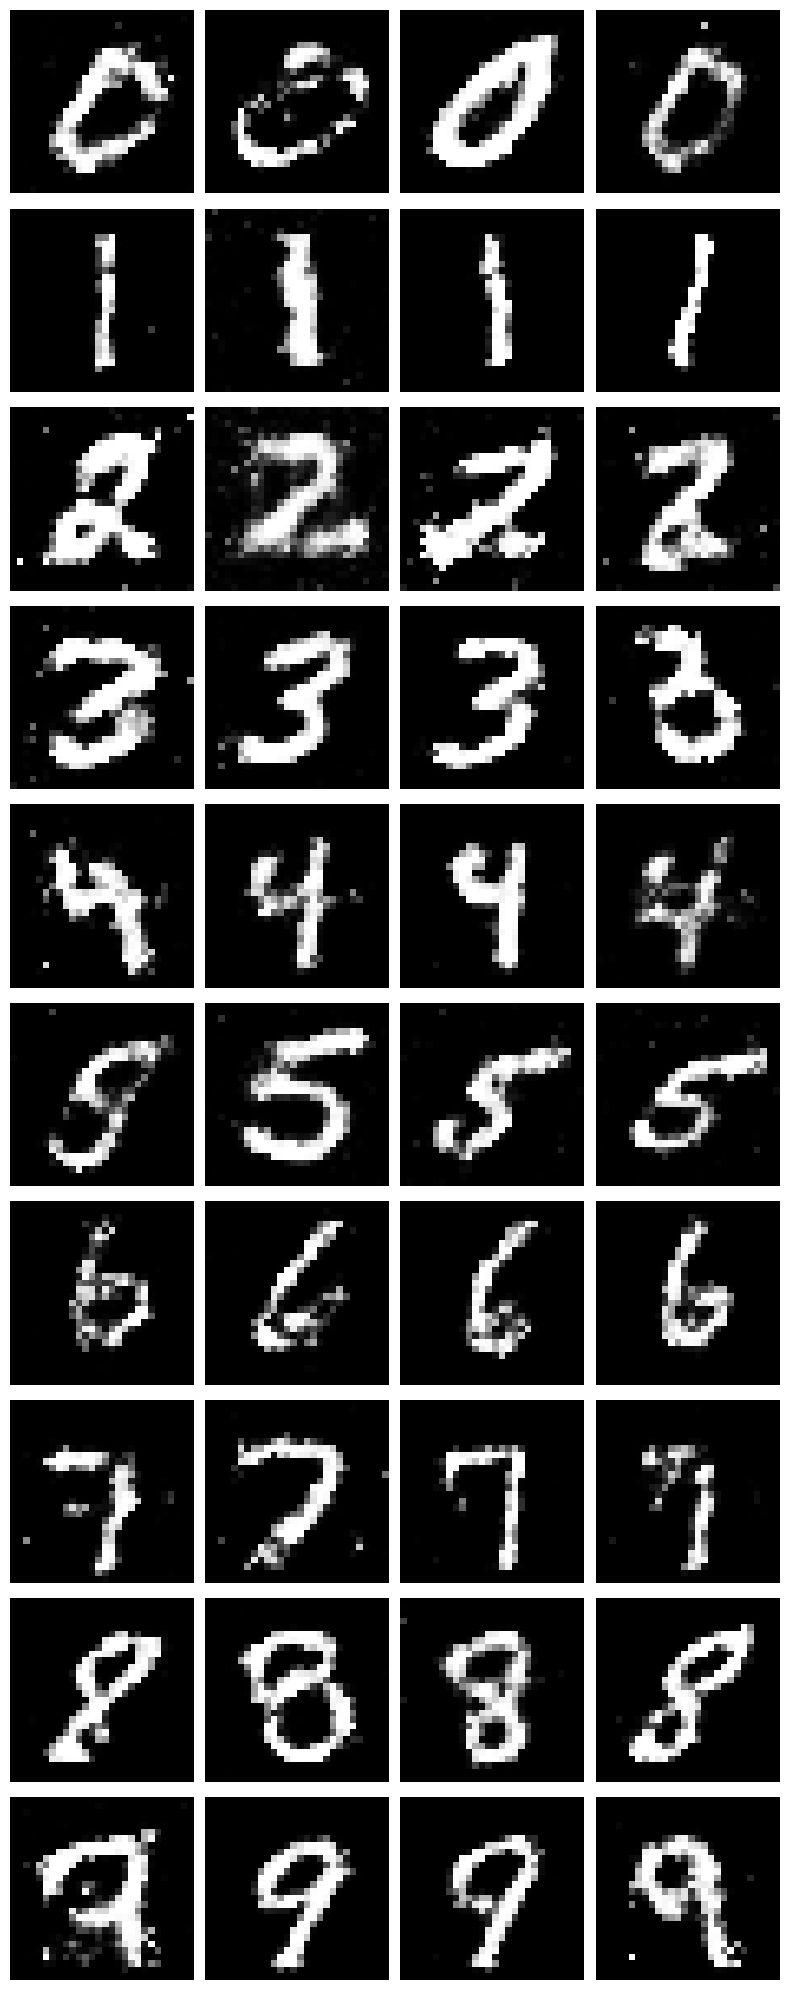

Epoch [24/50] Batch [0/938] Loss D: 1.3815, Loss G: 0.7556
Epoch [24/50] Batch [100/938] Loss D: 1.3470, Loss G: 0.7329
Epoch [24/50] Batch [200/938] Loss D: 1.3178, Loss G: 0.7372
Epoch [24/50] Batch [300/938] Loss D: 1.3617, Loss G: 0.6949
Epoch [24/50] Batch [400/938] Loss D: 1.3221, Loss G: 0.7496
Epoch [24/50] Batch [500/938] Loss D: 1.4151, Loss G: 0.7684
Epoch [24/50] Batch [600/938] Loss D: 1.3718, Loss G: 0.7681
Epoch [24/50] Batch [700/938] Loss D: 1.4024, Loss G: 0.7576
Epoch [24/50] Batch [800/938] Loss D: 1.4019, Loss G: 0.7305
Epoch [24/50] Batch [900/938] Loss D: 1.3856, Loss G: 0.8048


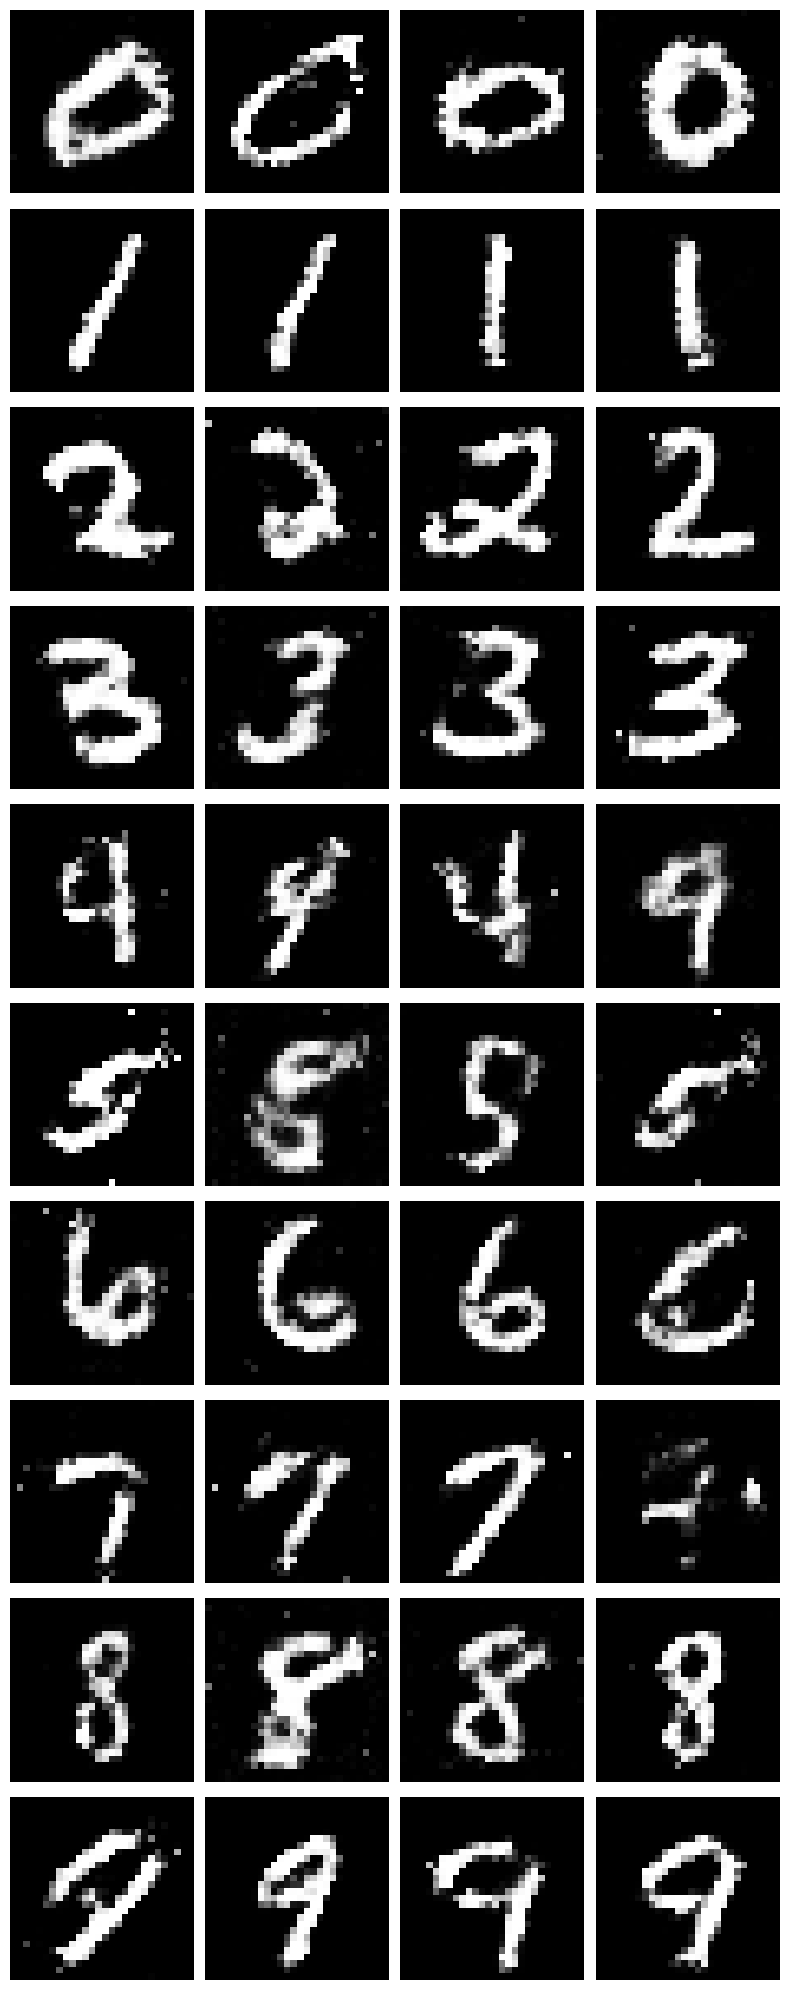

Epoch [25/50] Batch [0/938] Loss D: 1.4173, Loss G: 0.6749
Epoch [25/50] Batch [100/938] Loss D: 1.3717, Loss G: 0.7318
Epoch [25/50] Batch [200/938] Loss D: 1.3127, Loss G: 0.7641
Epoch [25/50] Batch [300/938] Loss D: 1.3824, Loss G: 0.6934
Epoch [25/50] Batch [400/938] Loss D: 1.3850, Loss G: 0.6879
Epoch [25/50] Batch [500/938] Loss D: 1.3768, Loss G: 0.7122
Epoch [25/50] Batch [600/938] Loss D: 1.3940, Loss G: 0.7604
Epoch [25/50] Batch [700/938] Loss D: 1.3629, Loss G: 0.7368
Epoch [25/50] Batch [800/938] Loss D: 1.3638, Loss G: 0.7372
Epoch [25/50] Batch [900/938] Loss D: 1.3547, Loss G: 0.7151


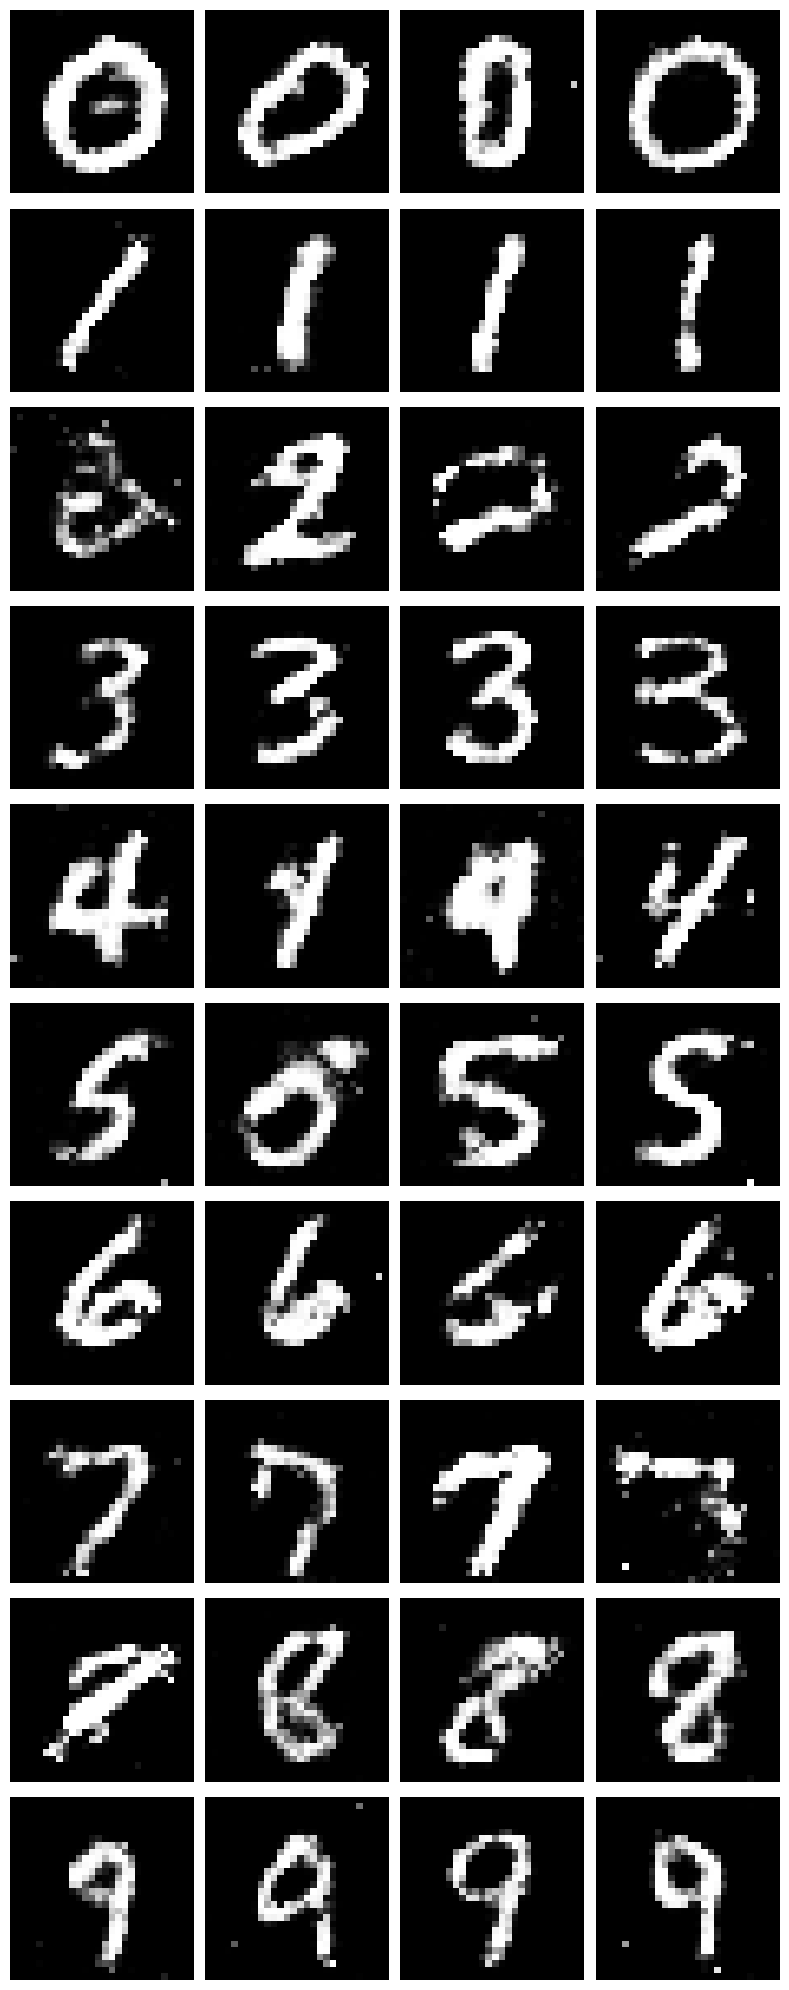

Epoch [26/50] Batch [0/938] Loss D: 1.4002, Loss G: 0.7641
Epoch [26/50] Batch [100/938] Loss D: 1.3860, Loss G: 0.7128
Epoch [26/50] Batch [200/938] Loss D: 1.3598, Loss G: 0.6755
Epoch [26/50] Batch [300/938] Loss D: 1.4074, Loss G: 0.7390
Epoch [26/50] Batch [400/938] Loss D: 1.3523, Loss G: 0.7055
Epoch [26/50] Batch [500/938] Loss D: 1.3691, Loss G: 0.7890
Epoch [26/50] Batch [600/938] Loss D: 1.4042, Loss G: 0.7633
Epoch [26/50] Batch [700/938] Loss D: 1.3705, Loss G: 0.7359
Epoch [26/50] Batch [800/938] Loss D: 1.3679, Loss G: 0.7034
Epoch [26/50] Batch [900/938] Loss D: 1.3818, Loss G: 0.6814


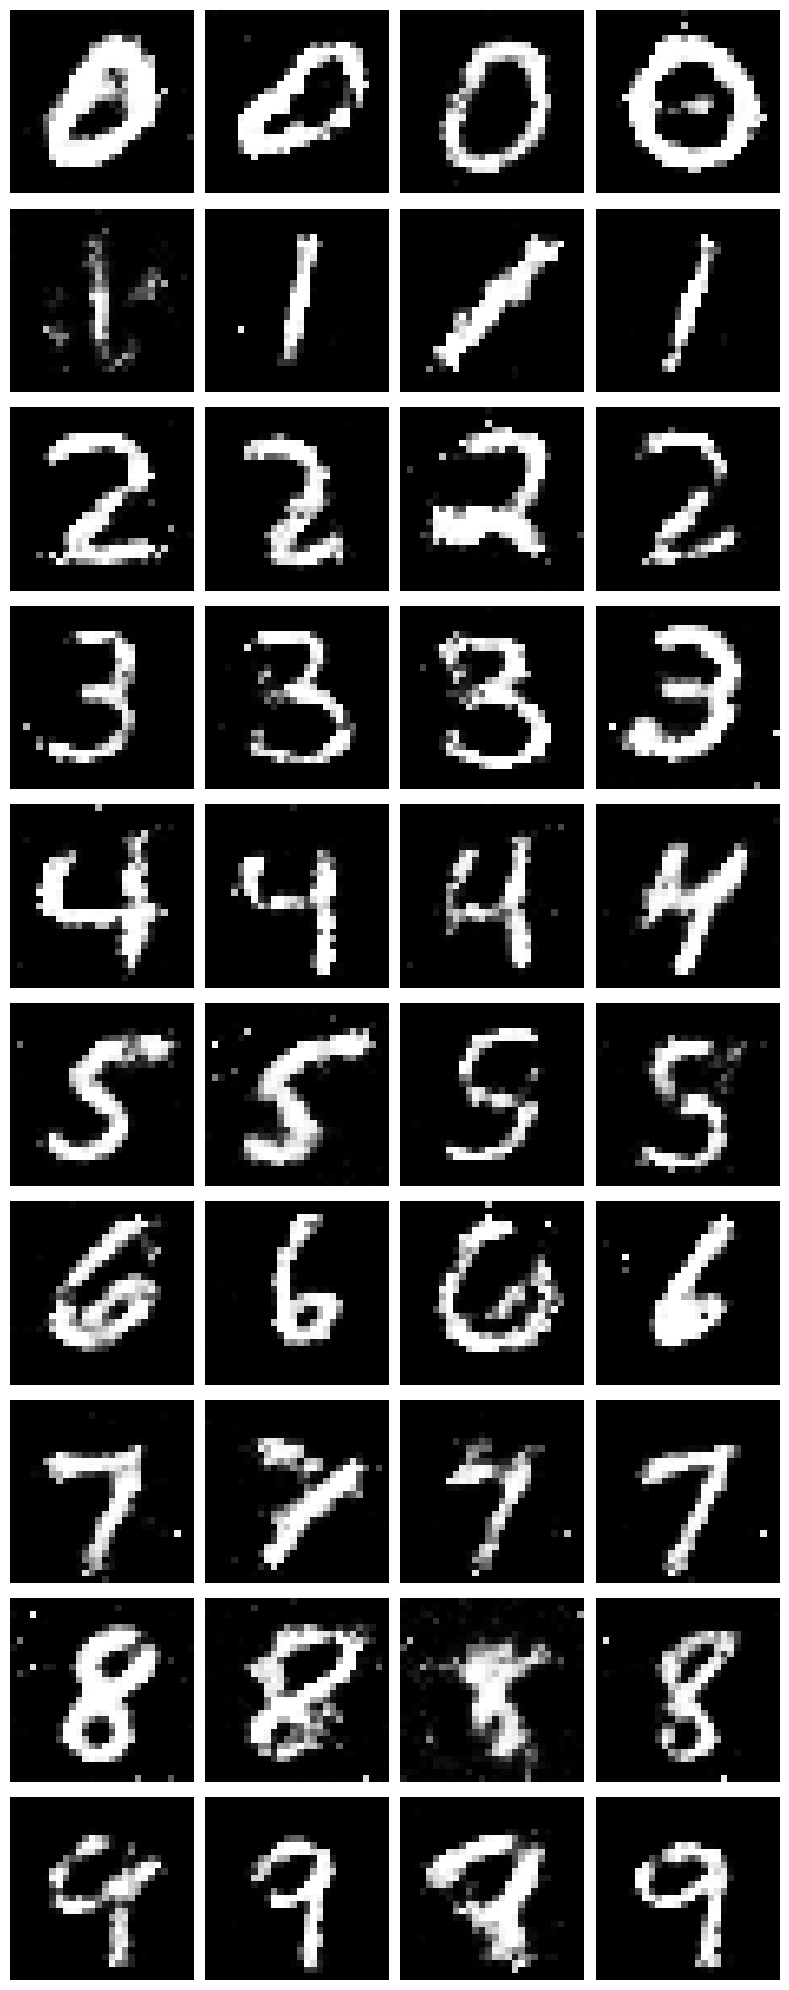

Epoch [27/50] Batch [0/938] Loss D: 1.3238, Loss G: 0.7704
Epoch [27/50] Batch [100/938] Loss D: 1.3376, Loss G: 0.7352
Epoch [27/50] Batch [200/938] Loss D: 1.3721, Loss G: 0.7953
Epoch [27/50] Batch [300/938] Loss D: 1.4266, Loss G: 0.7436
Epoch [27/50] Batch [400/938] Loss D: 1.3924, Loss G: 0.8100
Epoch [27/50] Batch [500/938] Loss D: 1.4160, Loss G: 0.6658
Epoch [27/50] Batch [600/938] Loss D: 1.3600, Loss G: 0.7252
Epoch [27/50] Batch [700/938] Loss D: 1.3781, Loss G: 0.7107
Epoch [27/50] Batch [800/938] Loss D: 1.2868, Loss G: 0.7484
Epoch [27/50] Batch [900/938] Loss D: 1.3152, Loss G: 0.7120


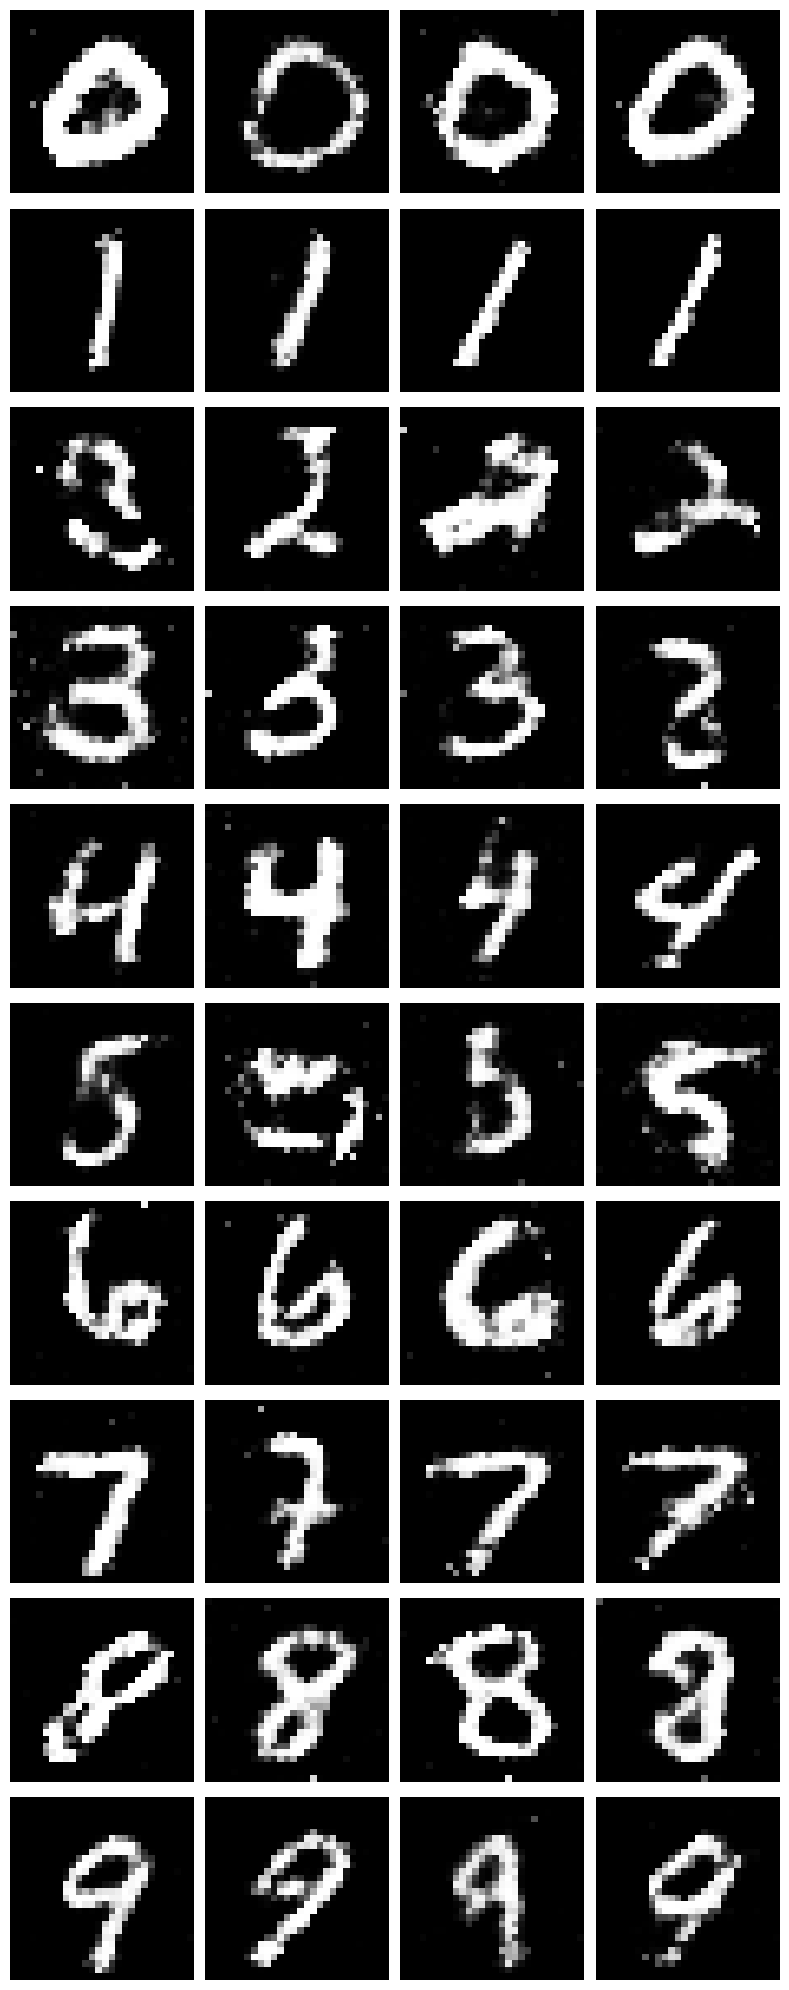

Epoch [28/50] Batch [0/938] Loss D: 1.3684, Loss G: 0.6961
Epoch [28/50] Batch [100/938] Loss D: 1.3572, Loss G: 0.7331
Epoch [28/50] Batch [200/938] Loss D: 1.3944, Loss G: 0.7186
Epoch [28/50] Batch [300/938] Loss D: 1.3446, Loss G: 0.7299
Epoch [28/50] Batch [400/938] Loss D: 1.3882, Loss G: 0.7584
Epoch [28/50] Batch [500/938] Loss D: 1.4255, Loss G: 0.8103
Epoch [28/50] Batch [600/938] Loss D: 1.3704, Loss G: 0.7871
Epoch [28/50] Batch [700/938] Loss D: 1.3567, Loss G: 0.7061
Epoch [28/50] Batch [800/938] Loss D: 1.3231, Loss G: 0.6847
Epoch [28/50] Batch [900/938] Loss D: 1.3747, Loss G: 0.7968


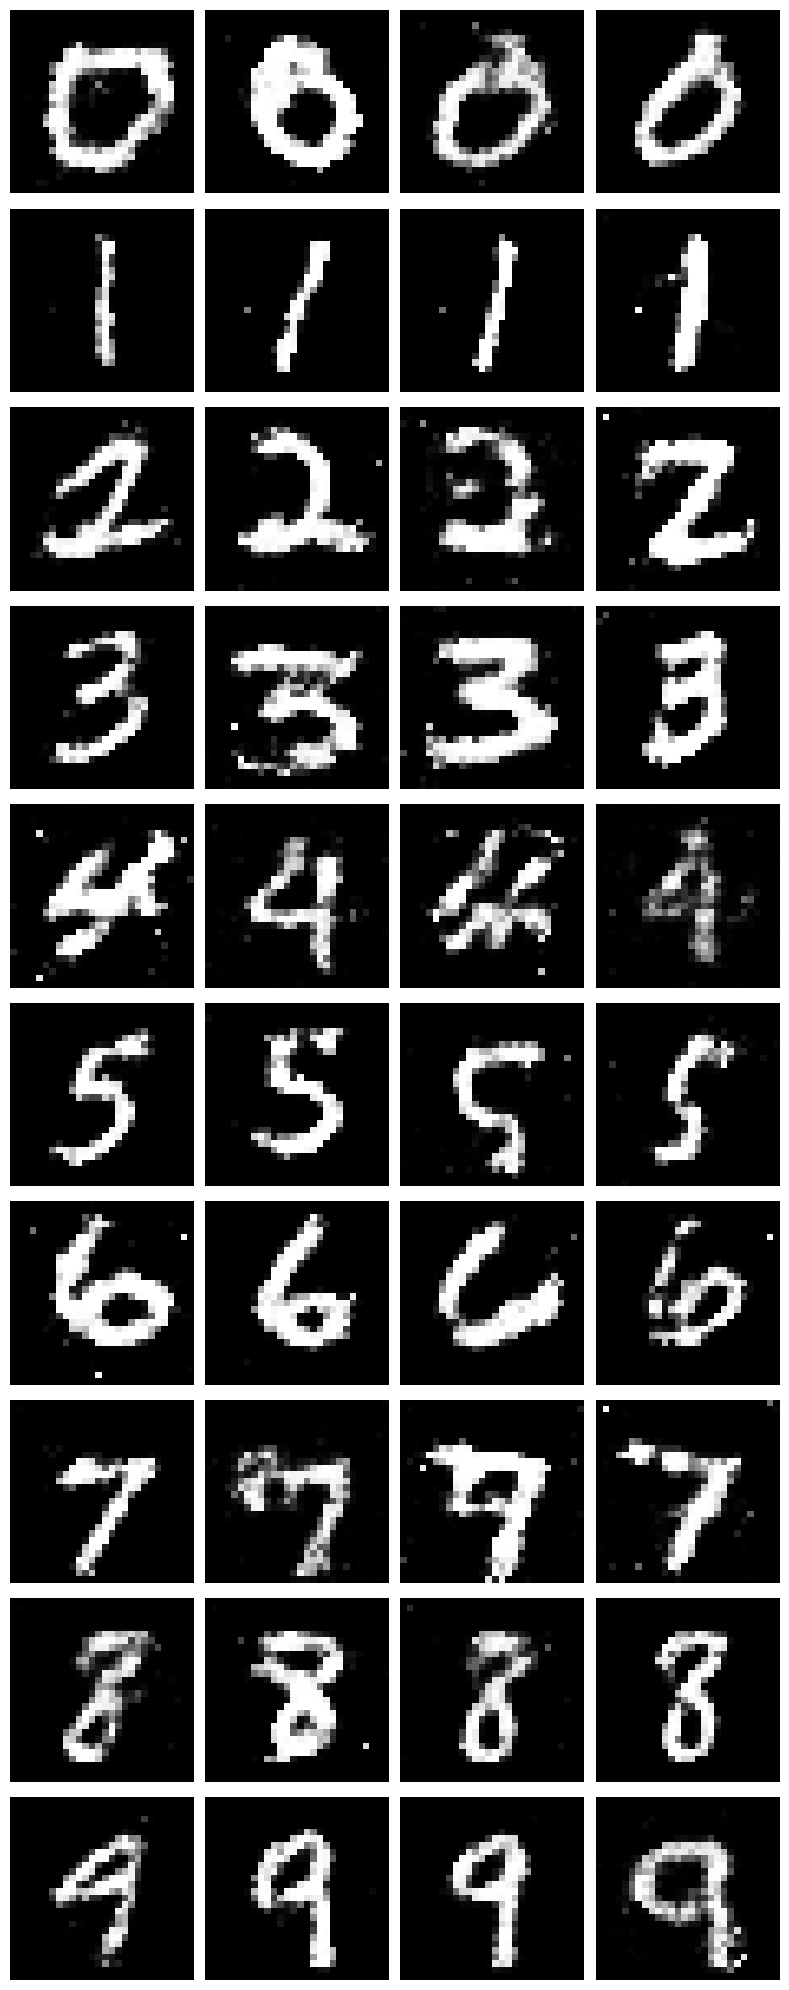

Epoch [29/50] Batch [0/938] Loss D: 1.3517, Loss G: 0.7267
Epoch [29/50] Batch [100/938] Loss D: 1.3468, Loss G: 0.6732
Epoch [29/50] Batch [200/938] Loss D: 1.3270, Loss G: 0.6712
Epoch [29/50] Batch [300/938] Loss D: 1.3711, Loss G: 0.7210
Epoch [29/50] Batch [400/938] Loss D: 1.3625, Loss G: 0.7424
Epoch [29/50] Batch [500/938] Loss D: 1.3275, Loss G: 0.7193
Epoch [29/50] Batch [600/938] Loss D: 1.3726, Loss G: 0.8120
Epoch [29/50] Batch [700/938] Loss D: 1.3490, Loss G: 0.8431
Epoch [29/50] Batch [800/938] Loss D: 1.3760, Loss G: 0.7537
Epoch [29/50] Batch [900/938] Loss D: 1.3526, Loss G: 0.7674


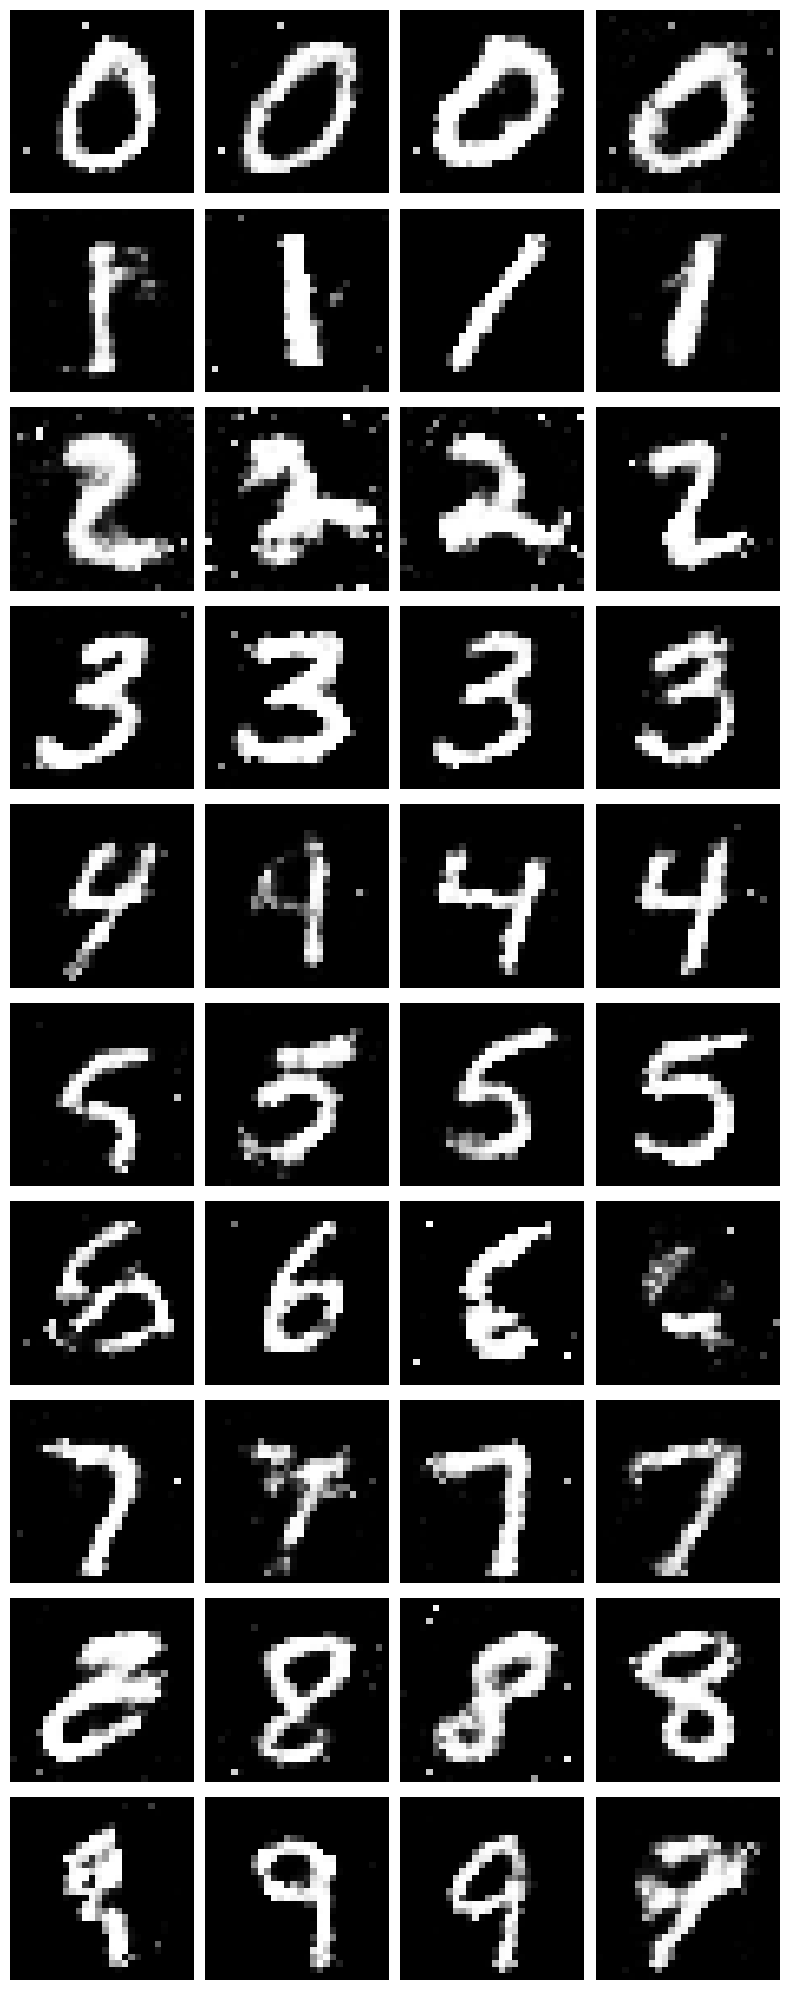

Epoch [30/50] Batch [0/938] Loss D: 1.3592, Loss G: 0.7323
Epoch [30/50] Batch [100/938] Loss D: 1.3772, Loss G: 0.7640
Epoch [30/50] Batch [200/938] Loss D: 1.3922, Loss G: 0.7477
Epoch [30/50] Batch [300/938] Loss D: 1.3770, Loss G: 0.7299
Epoch [30/50] Batch [400/938] Loss D: 1.3310, Loss G: 0.6963
Epoch [30/50] Batch [500/938] Loss D: 1.3658, Loss G: 0.6865
Epoch [30/50] Batch [600/938] Loss D: 1.3521, Loss G: 0.7538
Epoch [30/50] Batch [700/938] Loss D: 1.3752, Loss G: 0.7826
Epoch [30/50] Batch [800/938] Loss D: 1.3383, Loss G: 0.7386
Epoch [30/50] Batch [900/938] Loss D: 1.3908, Loss G: 0.7441


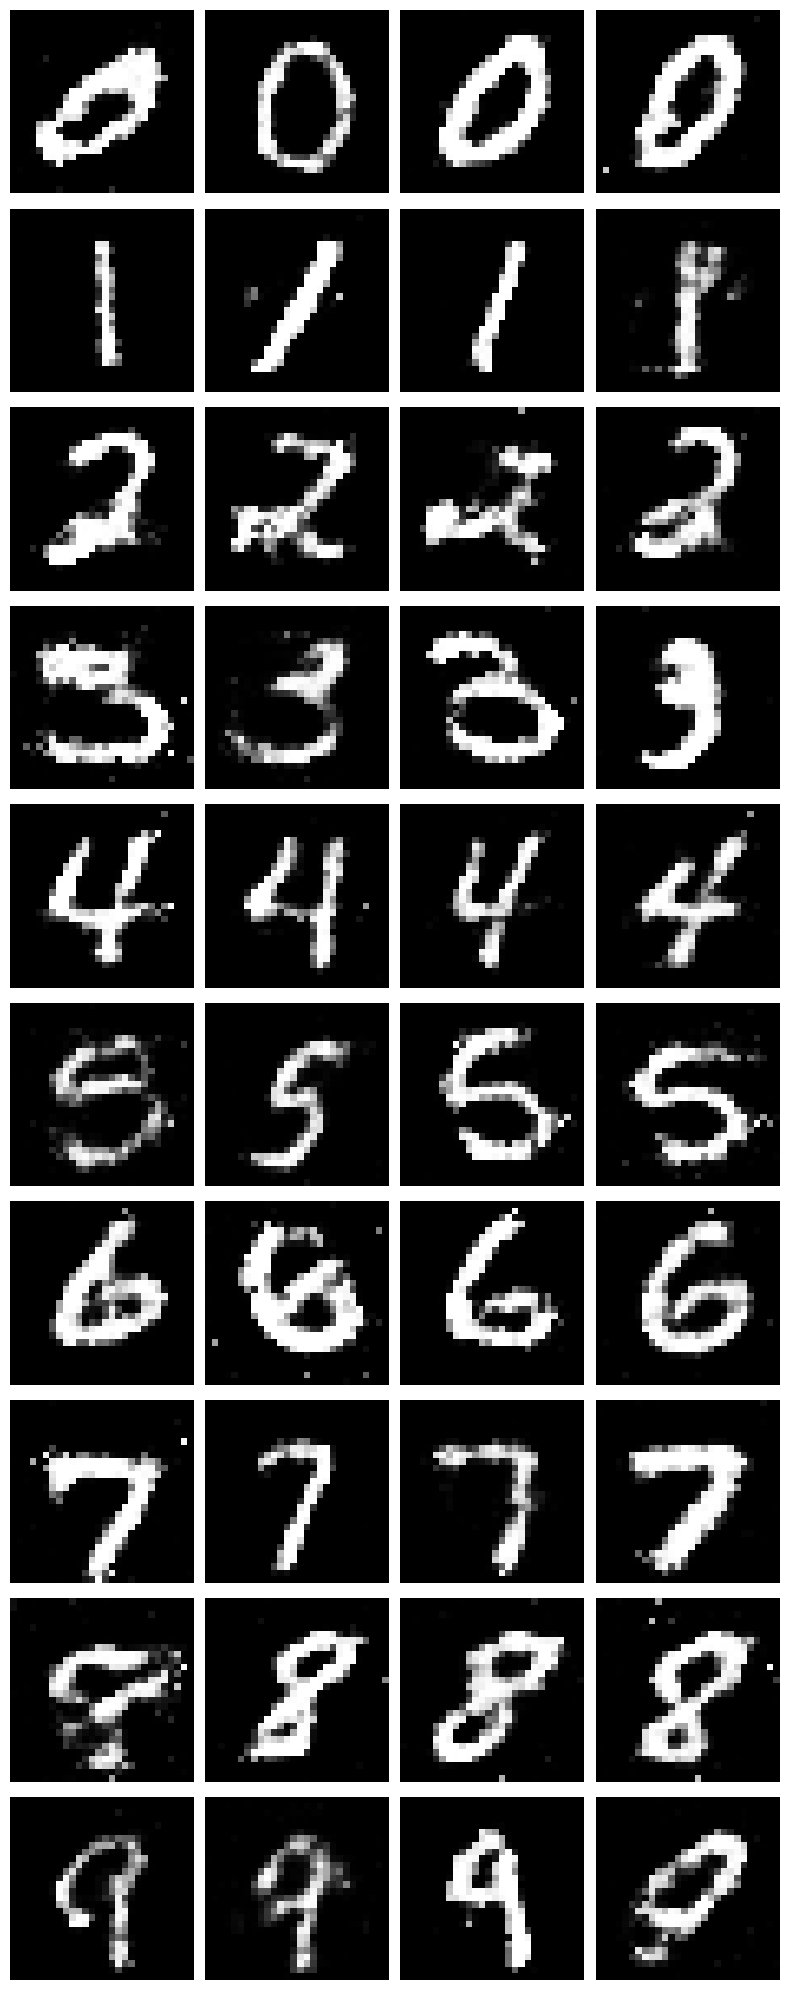

Epoch [31/50] Batch [0/938] Loss D: 1.3610, Loss G: 0.7369
Epoch [31/50] Batch [100/938] Loss D: 1.4292, Loss G: 0.7601
Epoch [31/50] Batch [200/938] Loss D: 1.3715, Loss G: 0.8011
Epoch [31/50] Batch [300/938] Loss D: 1.3714, Loss G: 0.7239
Epoch [31/50] Batch [400/938] Loss D: 1.3880, Loss G: 0.7589
Epoch [31/50] Batch [500/938] Loss D: 1.3816, Loss G: 0.7817
Epoch [31/50] Batch [600/938] Loss D: 1.3377, Loss G: 0.7341
Epoch [31/50] Batch [700/938] Loss D: 1.3223, Loss G: 0.7147
Epoch [31/50] Batch [800/938] Loss D: 1.3718, Loss G: 0.7285
Epoch [31/50] Batch [900/938] Loss D: 1.3661, Loss G: 0.7592


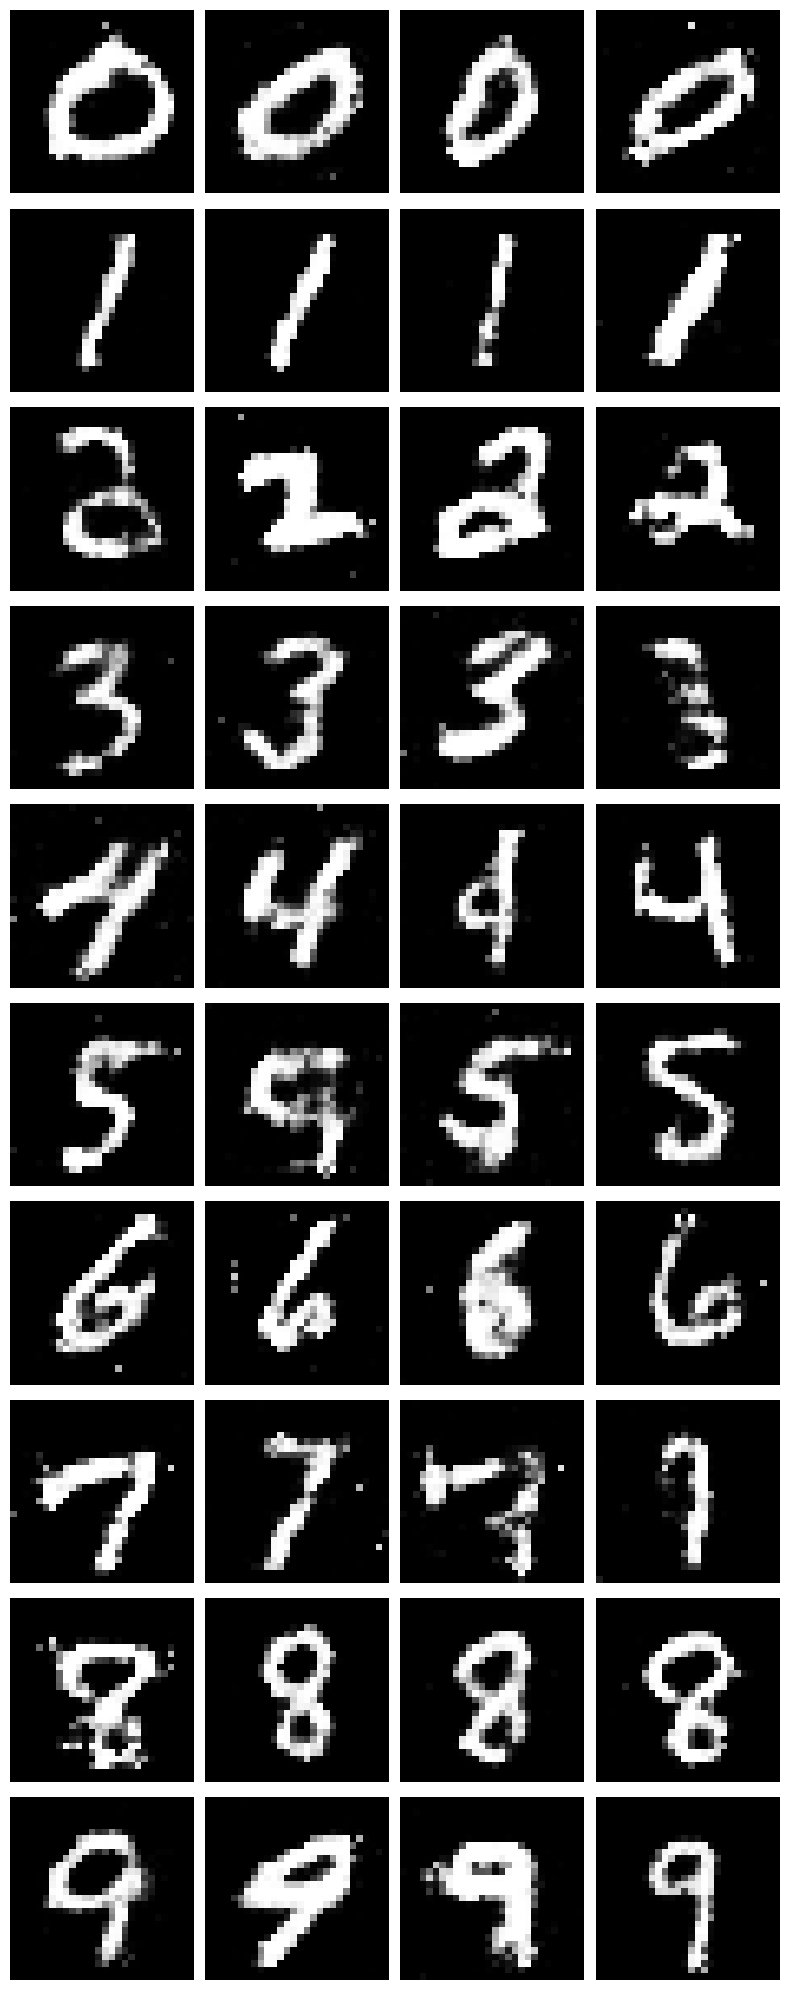

Epoch [32/50] Batch [0/938] Loss D: 1.3756, Loss G: 0.7665
Epoch [32/50] Batch [100/938] Loss D: 1.3731, Loss G: 0.7282
Epoch [32/50] Batch [200/938] Loss D: 1.3700, Loss G: 0.7614
Epoch [32/50] Batch [300/938] Loss D: 1.3628, Loss G: 0.7981
Epoch [32/50] Batch [400/938] Loss D: 1.3399, Loss G: 0.7267
Epoch [32/50] Batch [500/938] Loss D: 1.3309, Loss G: 0.7471
Epoch [32/50] Batch [600/938] Loss D: 1.3149, Loss G: 0.7057
Epoch [32/50] Batch [700/938] Loss D: 1.3769, Loss G: 0.7417
Epoch [32/50] Batch [800/938] Loss D: 1.3315, Loss G: 0.7539
Epoch [32/50] Batch [900/938] Loss D: 1.3644, Loss G: 0.7307


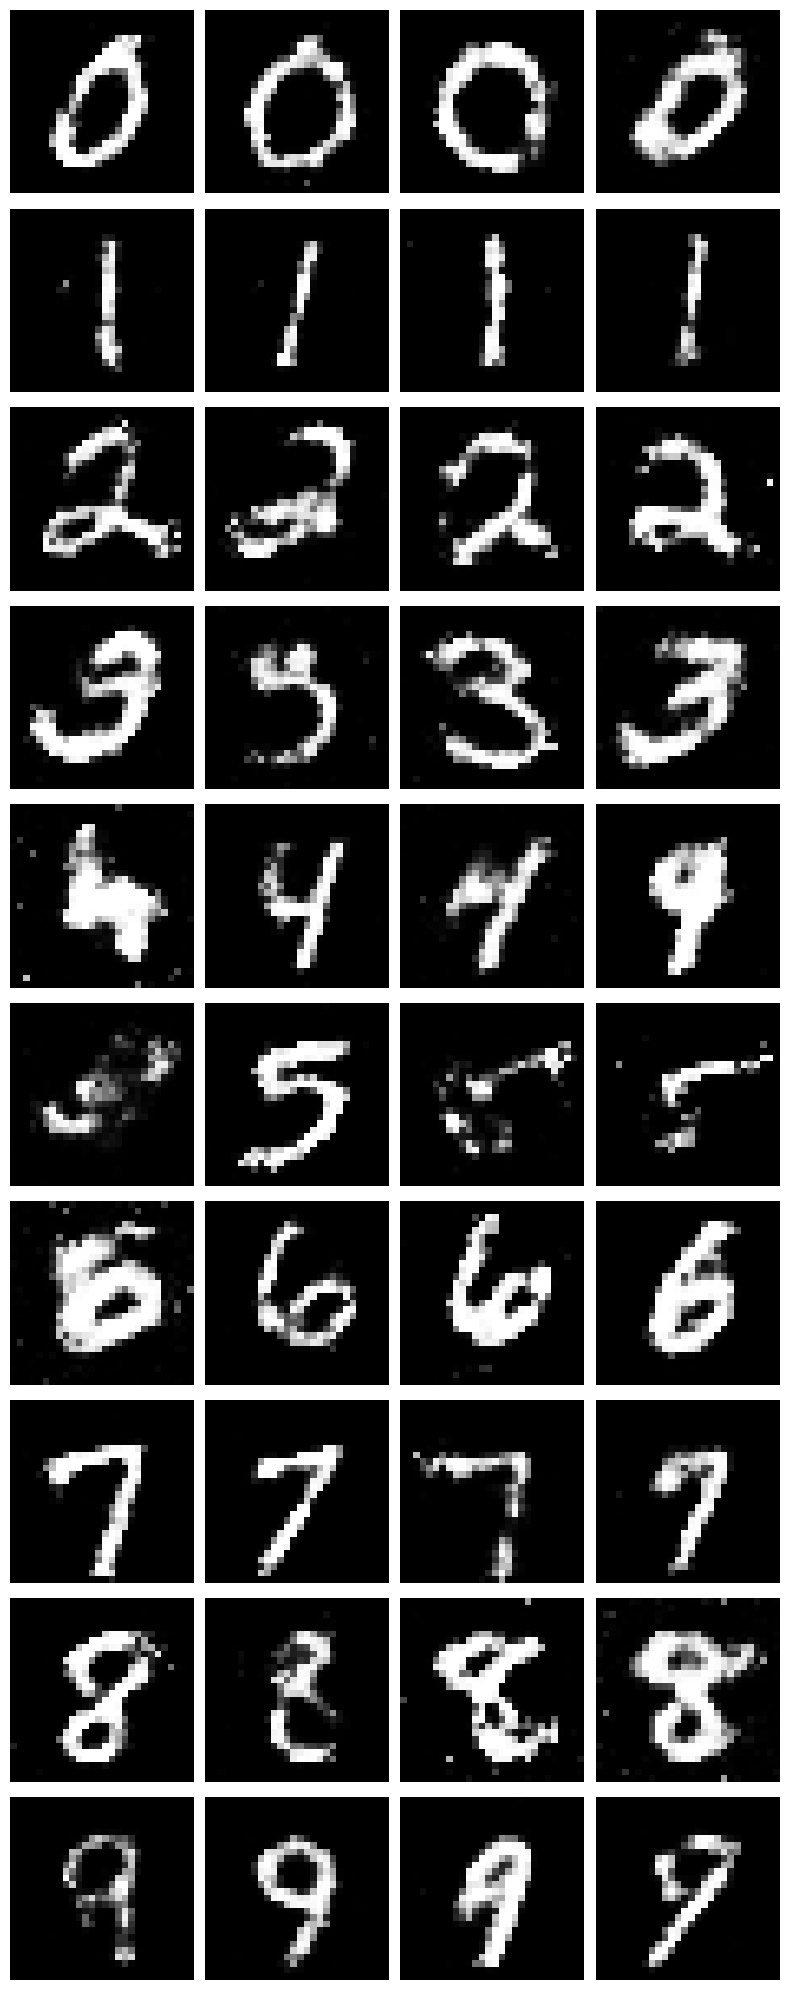

Epoch [33/50] Batch [0/938] Loss D: 1.3669, Loss G: 0.7539
Epoch [33/50] Batch [100/938] Loss D: 1.3365, Loss G: 0.7328
Epoch [33/50] Batch [200/938] Loss D: 1.3757, Loss G: 0.7903
Epoch [33/50] Batch [300/938] Loss D: 1.3838, Loss G: 0.7665
Epoch [33/50] Batch [400/938] Loss D: 1.3801, Loss G: 0.7769
Epoch [33/50] Batch [500/938] Loss D: 1.3138, Loss G: 0.7509
Epoch [33/50] Batch [600/938] Loss D: 1.3954, Loss G: 0.8656
Epoch [33/50] Batch [700/938] Loss D: 1.3754, Loss G: 0.7838
Epoch [33/50] Batch [800/938] Loss D: 1.3728, Loss G: 0.7691
Epoch [33/50] Batch [900/938] Loss D: 1.3699, Loss G: 0.6499


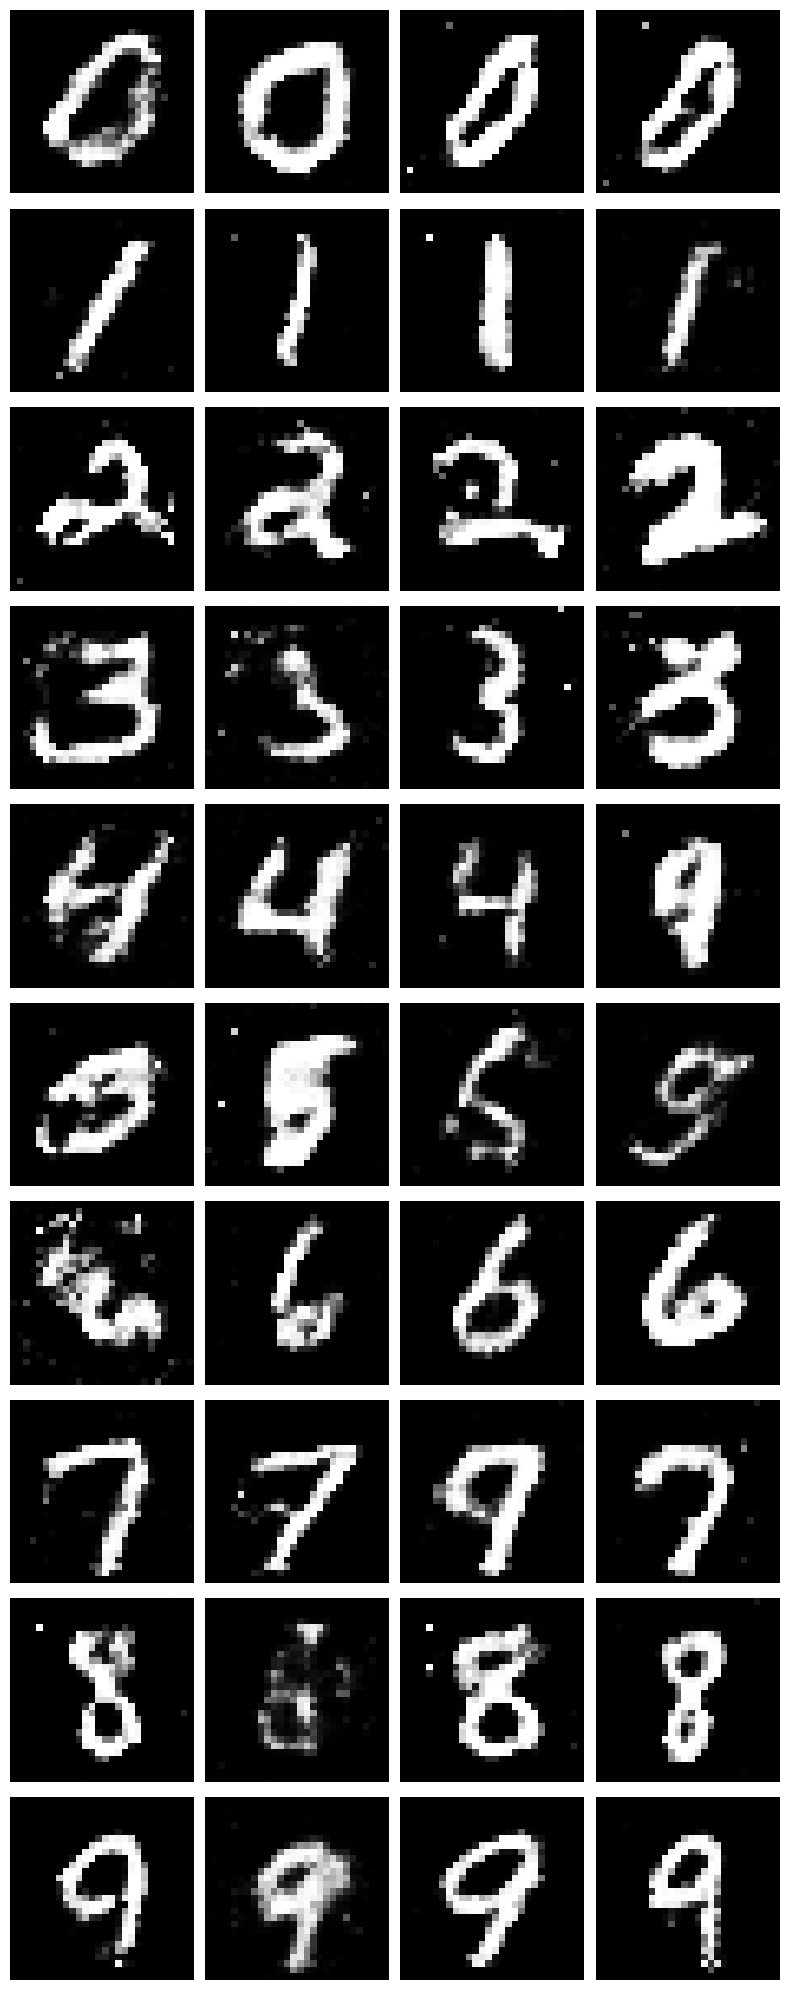

Epoch [34/50] Batch [0/938] Loss D: 1.3459, Loss G: 0.7486
Epoch [34/50] Batch [100/938] Loss D: 1.3701, Loss G: 0.7198
Epoch [34/50] Batch [200/938] Loss D: 1.2915, Loss G: 0.7170
Epoch [34/50] Batch [300/938] Loss D: 1.3749, Loss G: 0.7413
Epoch [34/50] Batch [400/938] Loss D: 1.3446, Loss G: 0.7883
Epoch [34/50] Batch [500/938] Loss D: 1.3585, Loss G: 0.7769
Epoch [34/50] Batch [600/938] Loss D: 1.3550, Loss G: 0.7861
Epoch [34/50] Batch [700/938] Loss D: 1.4049, Loss G: 0.7769
Epoch [34/50] Batch [800/938] Loss D: 1.4295, Loss G: 0.7202
Epoch [34/50] Batch [900/938] Loss D: 1.3563, Loss G: 0.7507


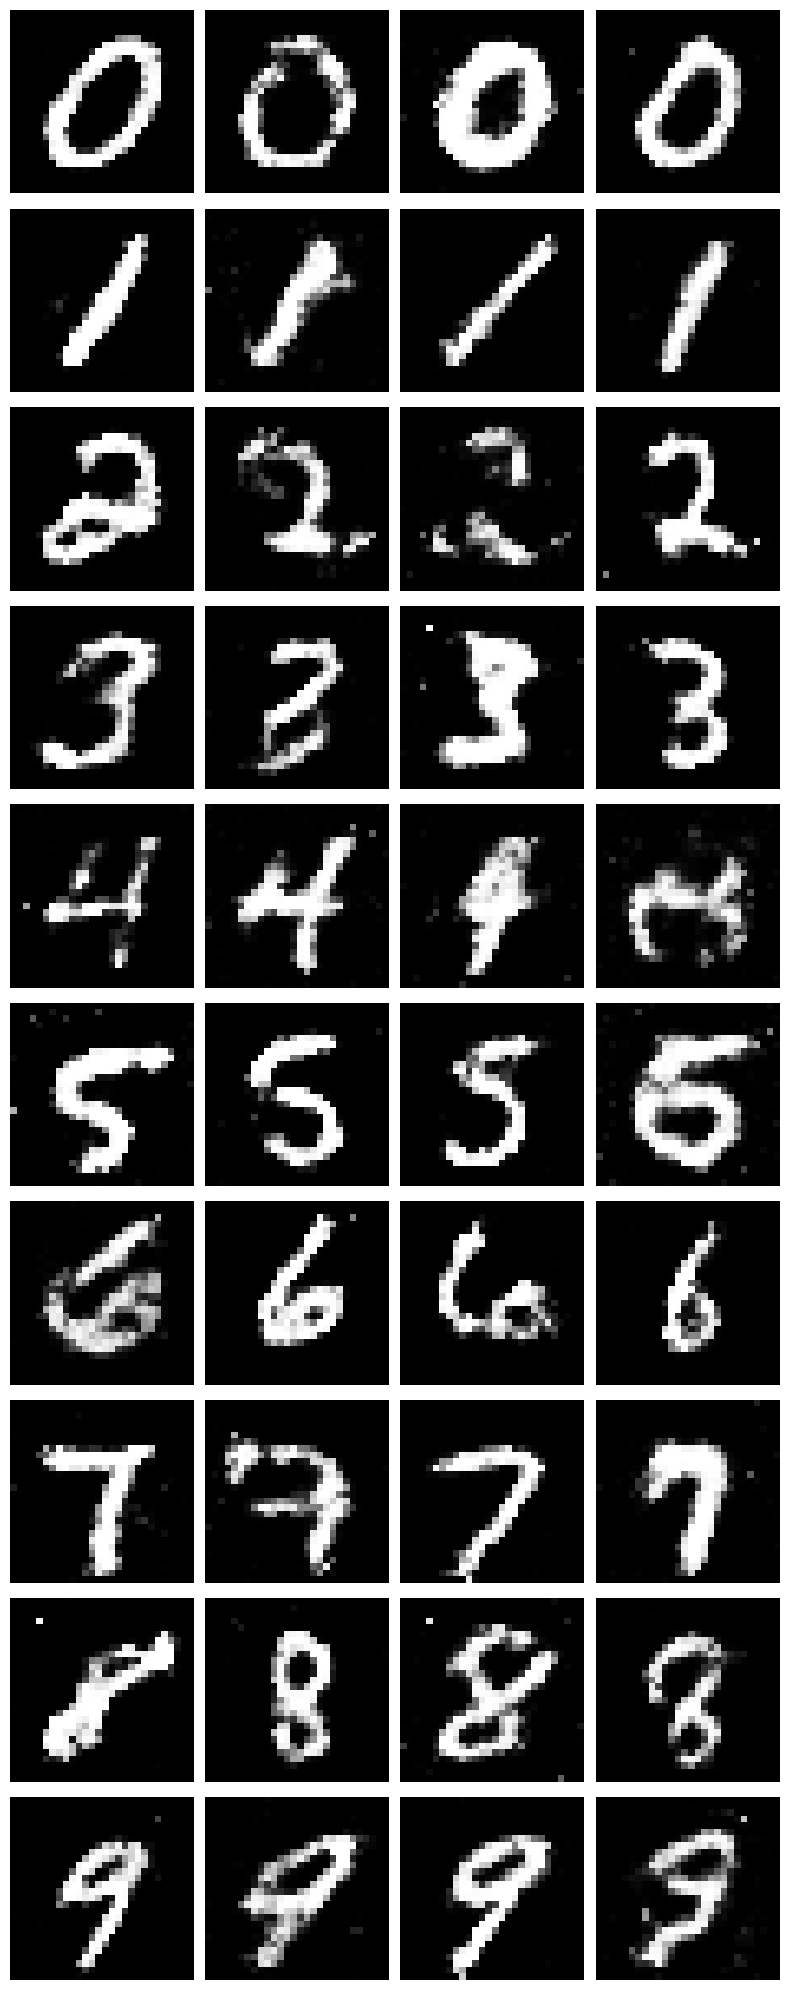

Epoch [35/50] Batch [0/938] Loss D: 1.3711, Loss G: 0.7573
Epoch [35/50] Batch [100/938] Loss D: 1.3716, Loss G: 0.7249
Epoch [35/50] Batch [200/938] Loss D: 1.3741, Loss G: 0.6878
Epoch [35/50] Batch [300/938] Loss D: 1.3631, Loss G: 0.6905
Epoch [35/50] Batch [400/938] Loss D: 1.3641, Loss G: 0.7294
Epoch [35/50] Batch [500/938] Loss D: 1.3313, Loss G: 0.8396
Epoch [35/50] Batch [600/938] Loss D: 1.3524, Loss G: 0.7311
Epoch [35/50] Batch [700/938] Loss D: 1.4055, Loss G: 0.7300
Epoch [35/50] Batch [800/938] Loss D: 1.3208, Loss G: 0.7372
Epoch [35/50] Batch [900/938] Loss D: 1.4091, Loss G: 0.7060


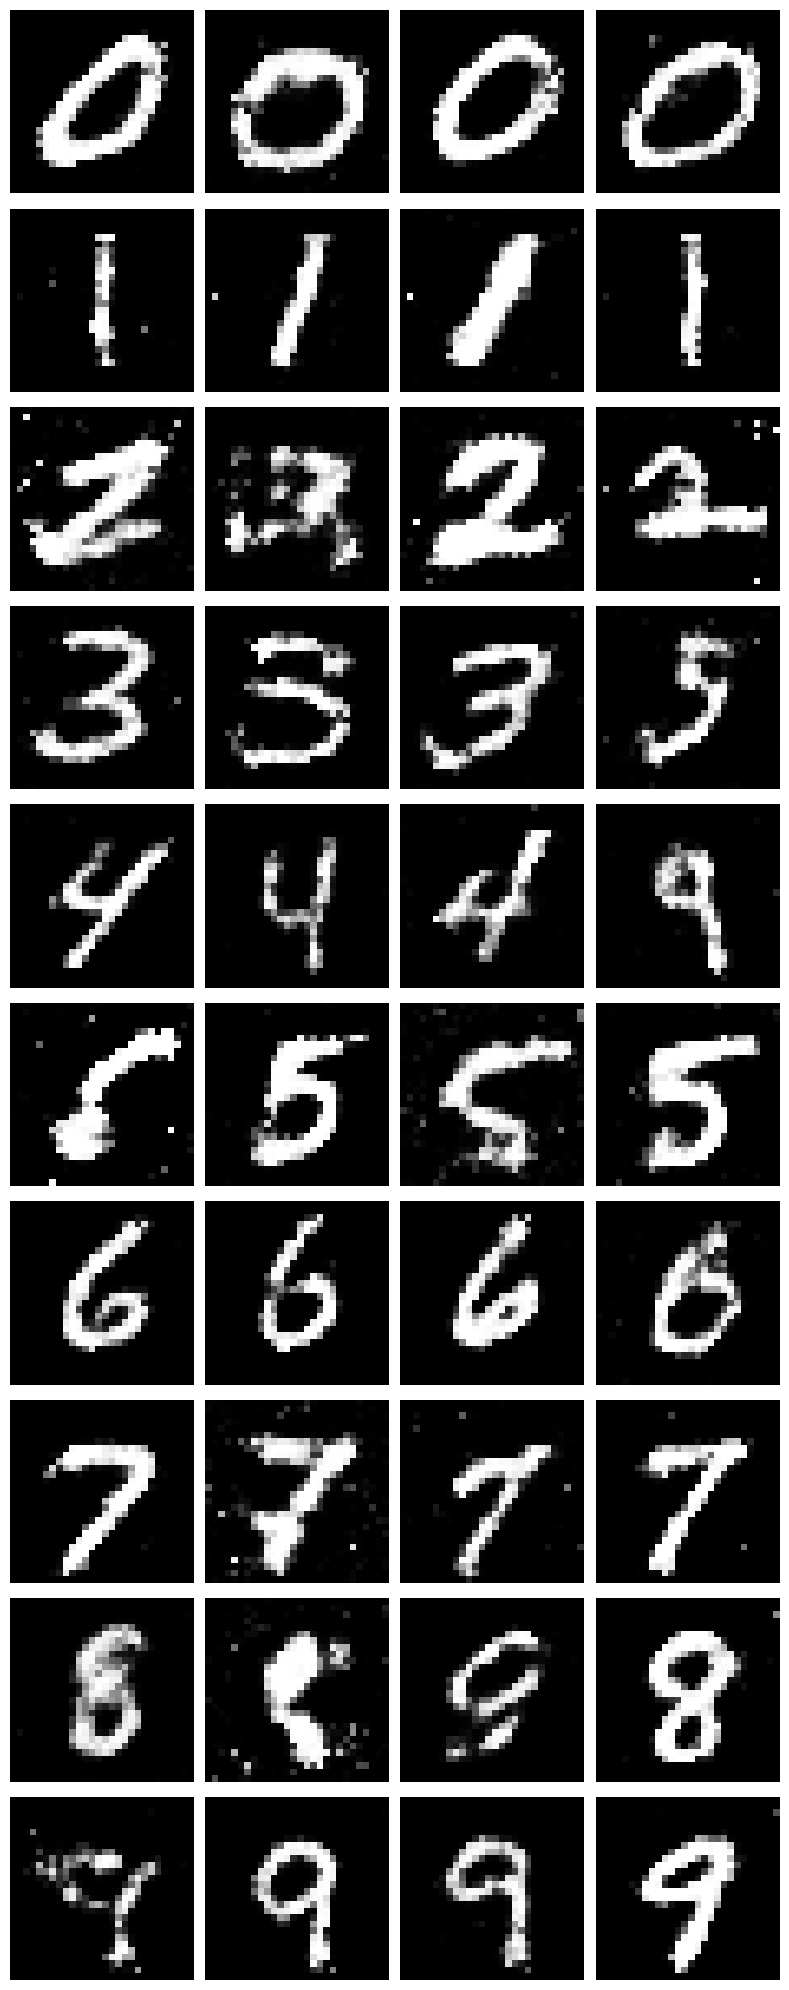

Epoch [36/50] Batch [0/938] Loss D: 1.3803, Loss G: 0.7607
Epoch [36/50] Batch [100/938] Loss D: 1.3319, Loss G: 0.7424
Epoch [36/50] Batch [200/938] Loss D: 1.3291, Loss G: 0.7432
Epoch [36/50] Batch [300/938] Loss D: 1.3546, Loss G: 0.7603
Epoch [36/50] Batch [400/938] Loss D: 1.4016, Loss G: 0.6893
Epoch [36/50] Batch [500/938] Loss D: 1.3253, Loss G: 0.7363
Epoch [36/50] Batch [600/938] Loss D: 1.3501, Loss G: 0.7757
Epoch [36/50] Batch [700/938] Loss D: 1.3580, Loss G: 0.6953
Epoch [36/50] Batch [800/938] Loss D: 1.3853, Loss G: 0.7830
Epoch [36/50] Batch [900/938] Loss D: 1.4239, Loss G: 0.7973


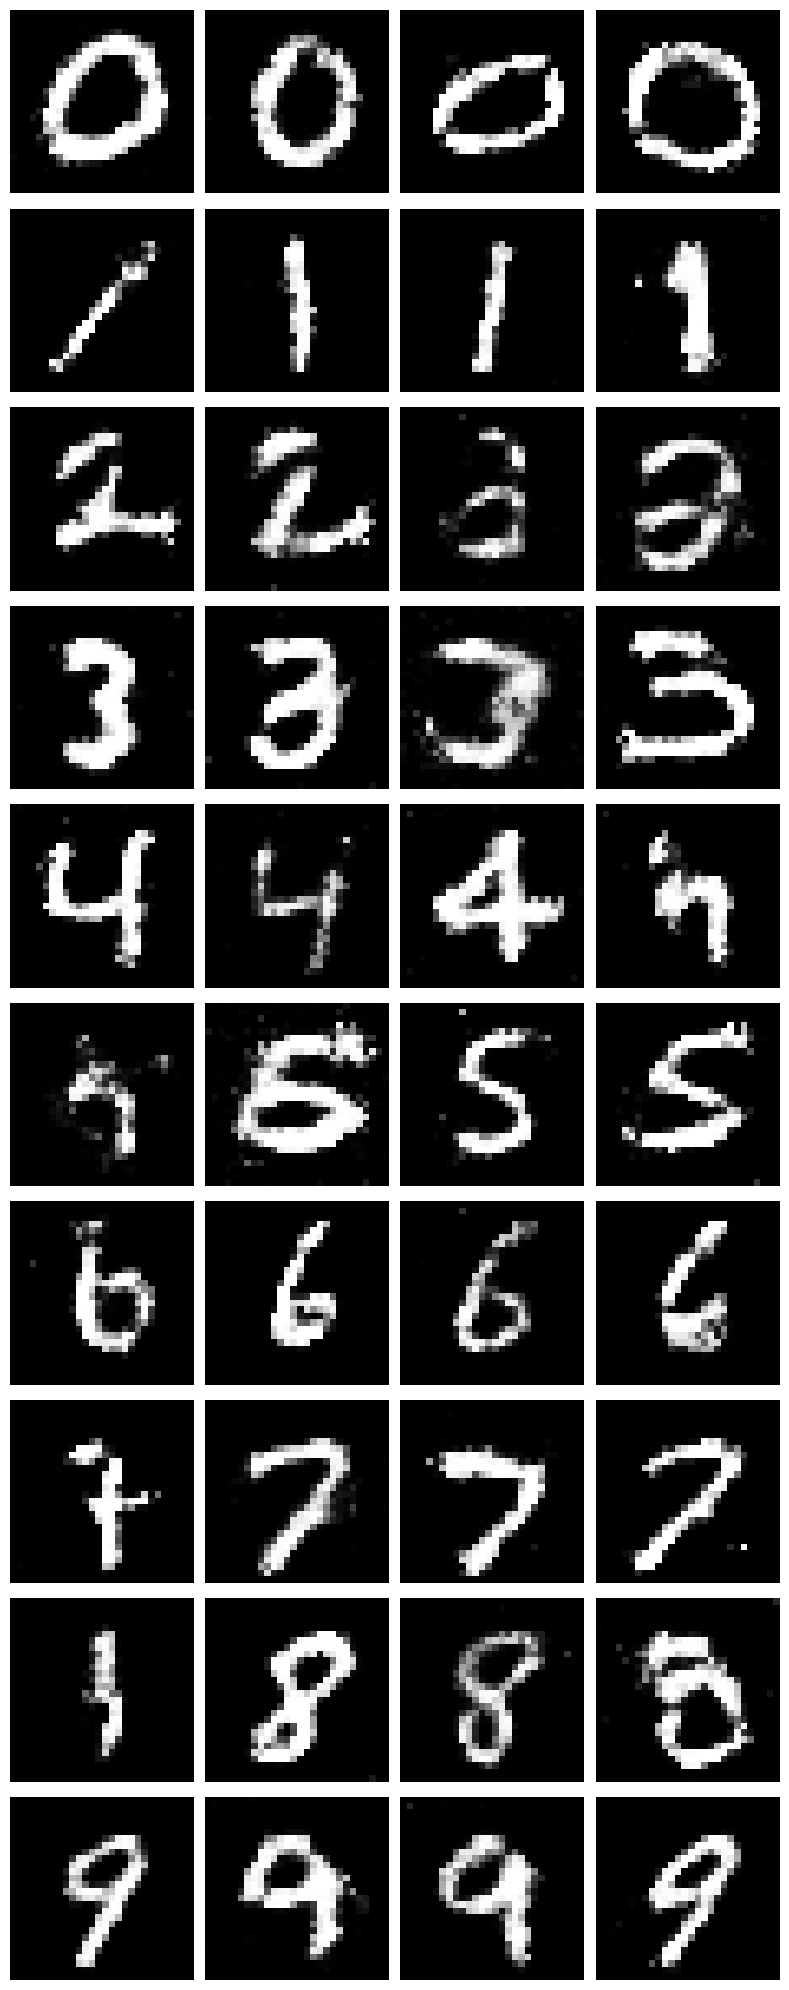

Epoch [37/50] Batch [0/938] Loss D: 1.3368, Loss G: 0.7134
Epoch [37/50] Batch [100/938] Loss D: 1.3218, Loss G: 0.7418
Epoch [37/50] Batch [200/938] Loss D: 1.3451, Loss G: 0.6927
Epoch [37/50] Batch [300/938] Loss D: 1.3639, Loss G: 0.7650
Epoch [37/50] Batch [400/938] Loss D: 1.3632, Loss G: 0.7645
Epoch [37/50] Batch [500/938] Loss D: 1.3571, Loss G: 0.7436
Epoch [37/50] Batch [600/938] Loss D: 1.3496, Loss G: 0.7243
Epoch [37/50] Batch [700/938] Loss D: 1.3983, Loss G: 0.6854
Epoch [37/50] Batch [800/938] Loss D: 1.3066, Loss G: 0.7436
Epoch [37/50] Batch [900/938] Loss D: 1.4114, Loss G: 0.6595


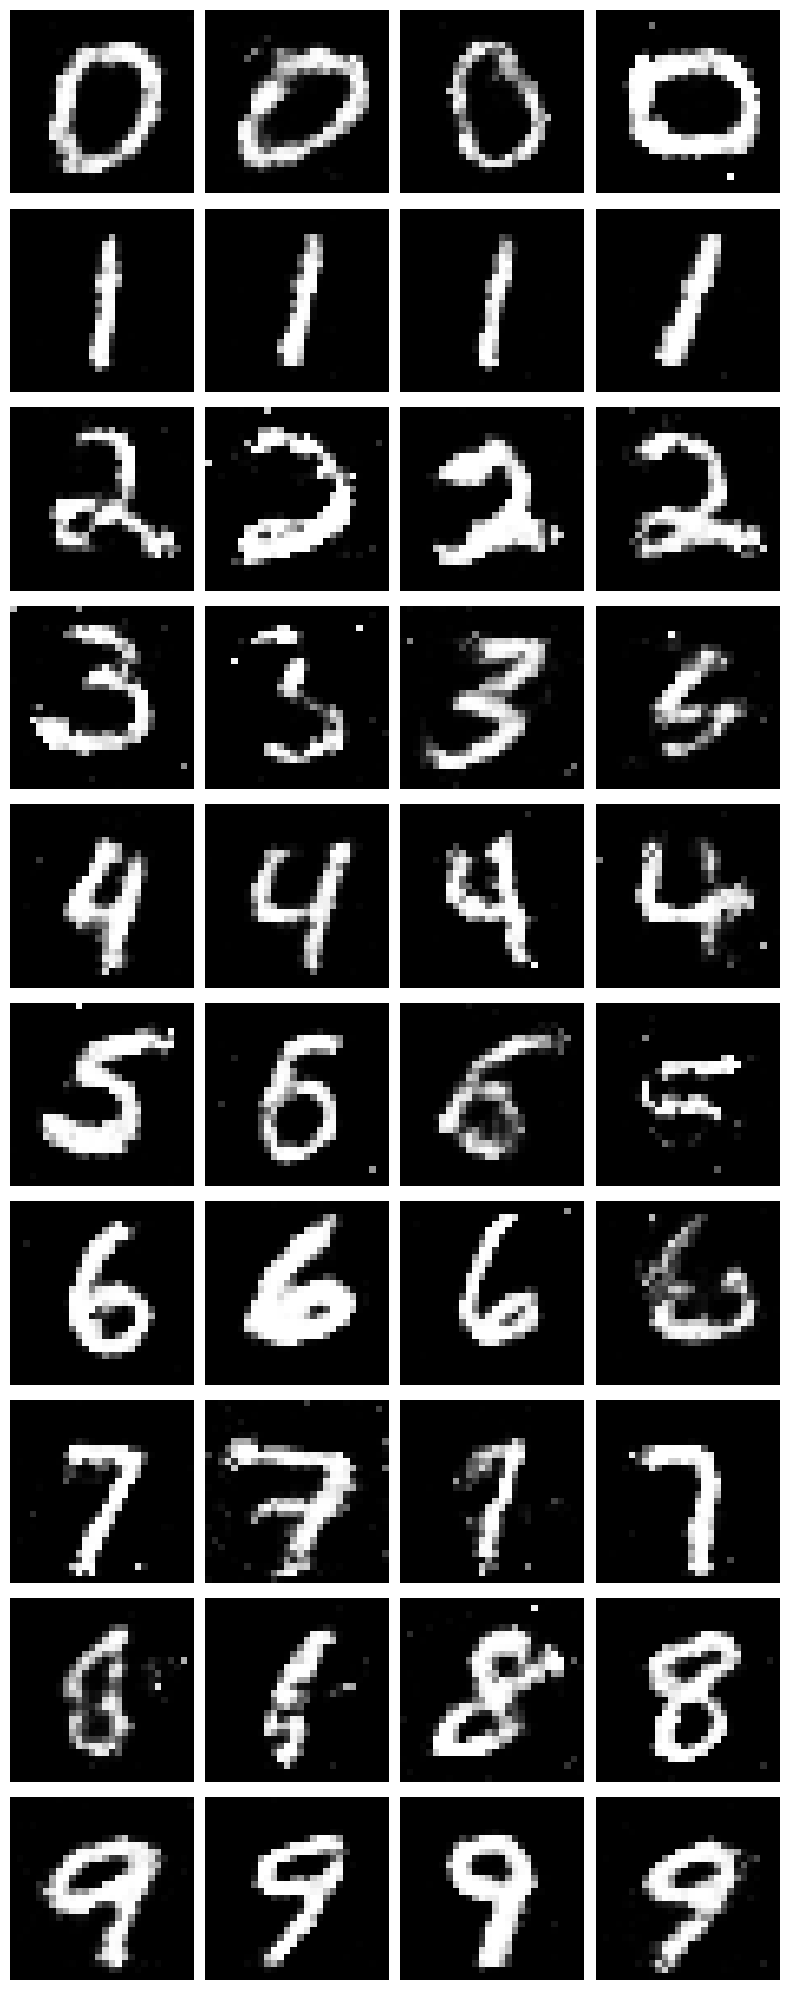

Epoch [38/50] Batch [0/938] Loss D: 1.3341, Loss G: 0.7149
Epoch [38/50] Batch [100/938] Loss D: 1.3632, Loss G: 0.7242
Epoch [38/50] Batch [200/938] Loss D: 1.3988, Loss G: 0.7877
Epoch [38/50] Batch [300/938] Loss D: 1.3382, Loss G: 0.7087
Epoch [38/50] Batch [400/938] Loss D: 1.4035, Loss G: 0.7621
Epoch [38/50] Batch [500/938] Loss D: 1.3547, Loss G: 0.6835
Epoch [38/50] Batch [600/938] Loss D: 1.3313, Loss G: 0.7201
Epoch [38/50] Batch [700/938] Loss D: 1.3323, Loss G: 0.7296
Epoch [38/50] Batch [800/938] Loss D: 1.3235, Loss G: 0.7591
Epoch [38/50] Batch [900/938] Loss D: 1.3682, Loss G: 0.7057


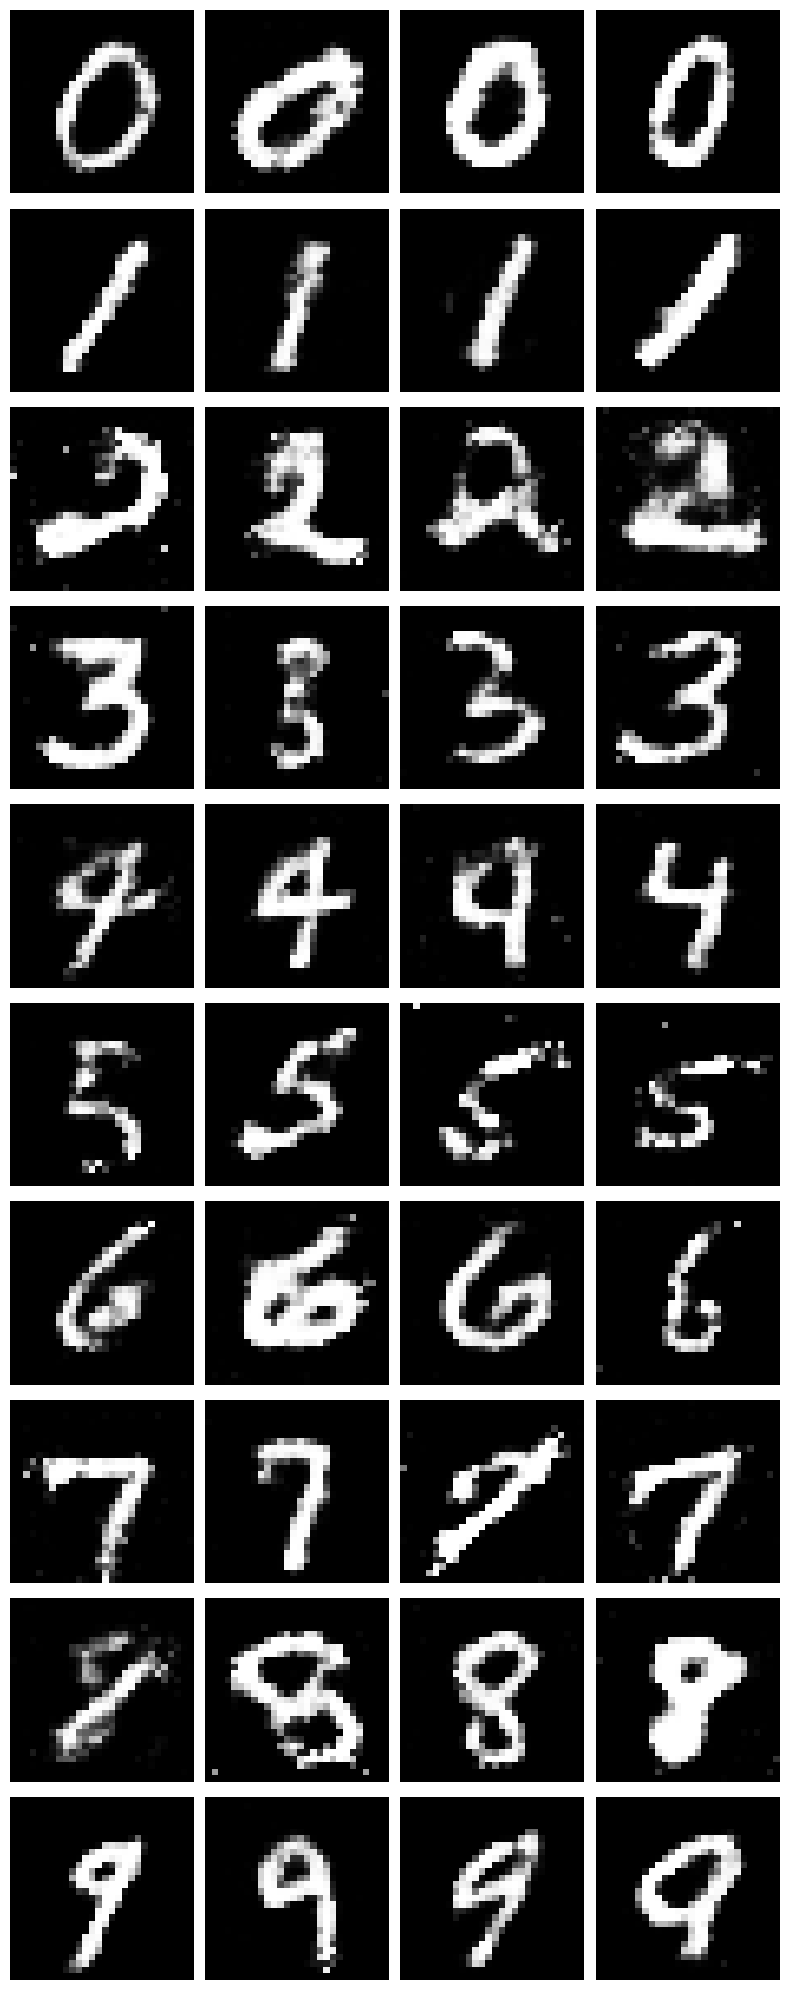

Epoch [39/50] Batch [0/938] Loss D: 1.3913, Loss G: 0.7765
Epoch [39/50] Batch [100/938] Loss D: 1.3648, Loss G: 0.7244
Epoch [39/50] Batch [200/938] Loss D: 1.3417, Loss G: 0.7303
Epoch [39/50] Batch [300/938] Loss D: 1.4151, Loss G: 0.7268
Epoch [39/50] Batch [400/938] Loss D: 1.3657, Loss G: 0.7383
Epoch [39/50] Batch [500/938] Loss D: 1.3606, Loss G: 0.7455
Epoch [39/50] Batch [600/938] Loss D: 1.3459, Loss G: 0.6694
Epoch [39/50] Batch [700/938] Loss D: 1.3364, Loss G: 0.7472
Epoch [39/50] Batch [800/938] Loss D: 1.4148, Loss G: 0.7815
Epoch [39/50] Batch [900/938] Loss D: 1.4032, Loss G: 0.7497


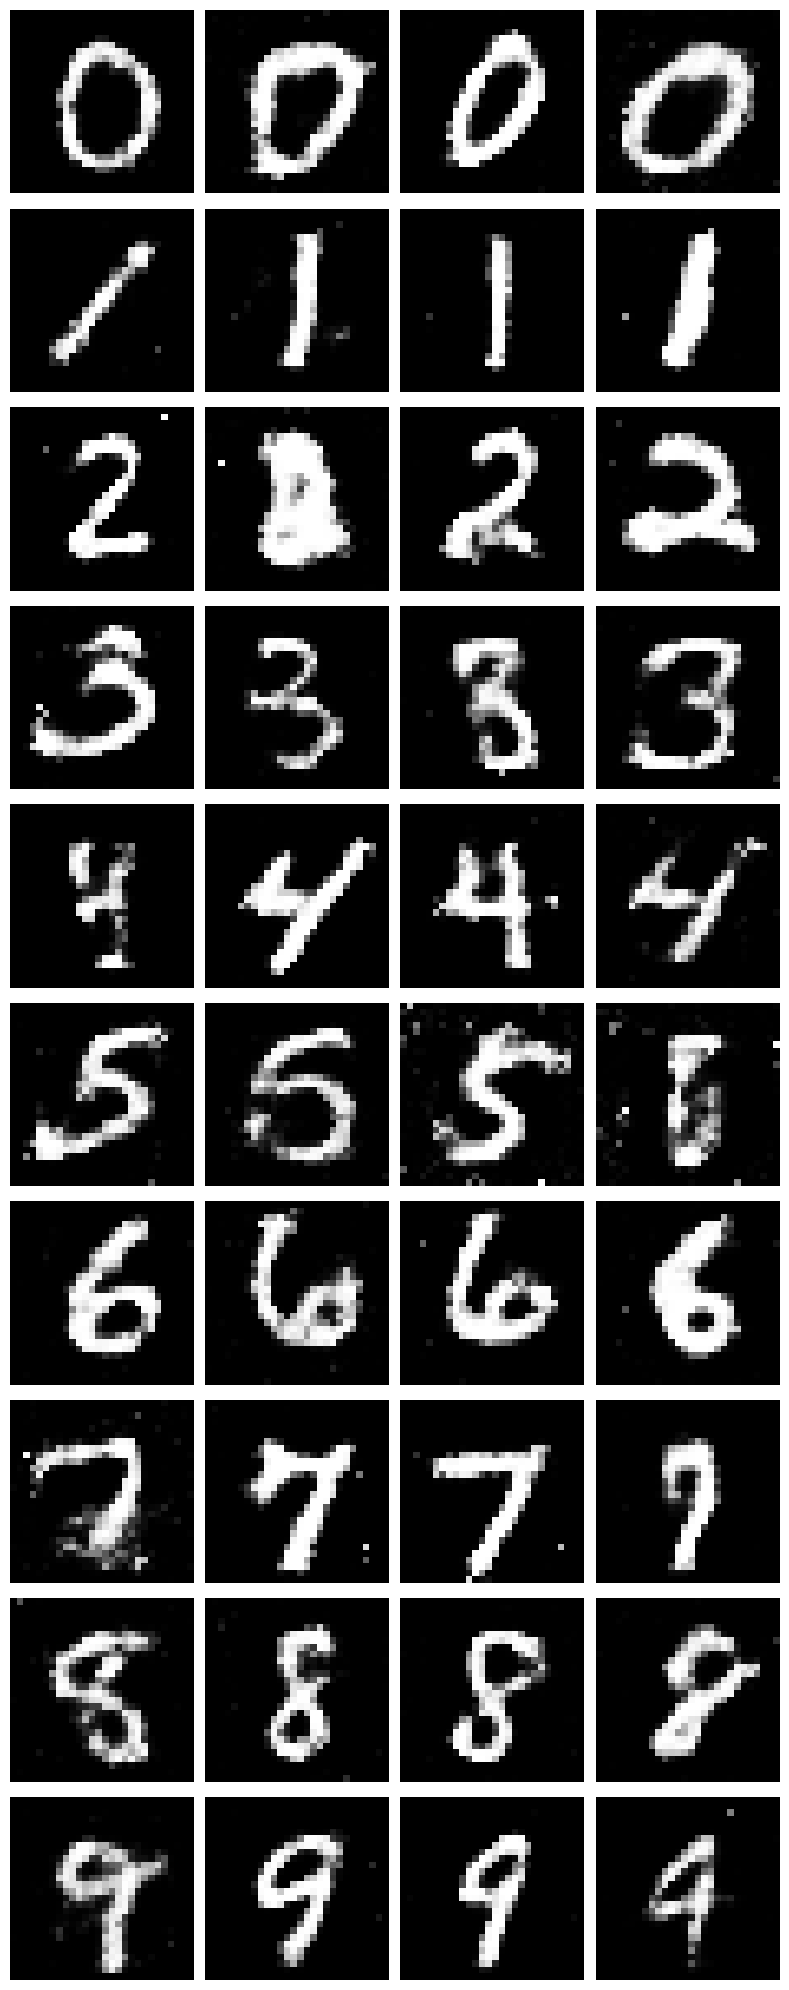

Epoch [40/50] Batch [0/938] Loss D: 1.2979, Loss G: 0.7731
Epoch [40/50] Batch [100/938] Loss D: 1.4018, Loss G: 0.7232
Epoch [40/50] Batch [200/938] Loss D: 1.4032, Loss G: 0.8459
Epoch [40/50] Batch [300/938] Loss D: 1.3305, Loss G: 0.7851
Epoch [40/50] Batch [400/938] Loss D: 1.2904, Loss G: 0.7000
Epoch [40/50] Batch [500/938] Loss D: 1.3258, Loss G: 0.7263
Epoch [40/50] Batch [600/938] Loss D: 1.3075, Loss G: 0.6137
Epoch [40/50] Batch [700/938] Loss D: 1.4201, Loss G: 0.6904
Epoch [40/50] Batch [800/938] Loss D: 1.3445, Loss G: 0.7375
Epoch [40/50] Batch [900/938] Loss D: 1.4274, Loss G: 0.6341


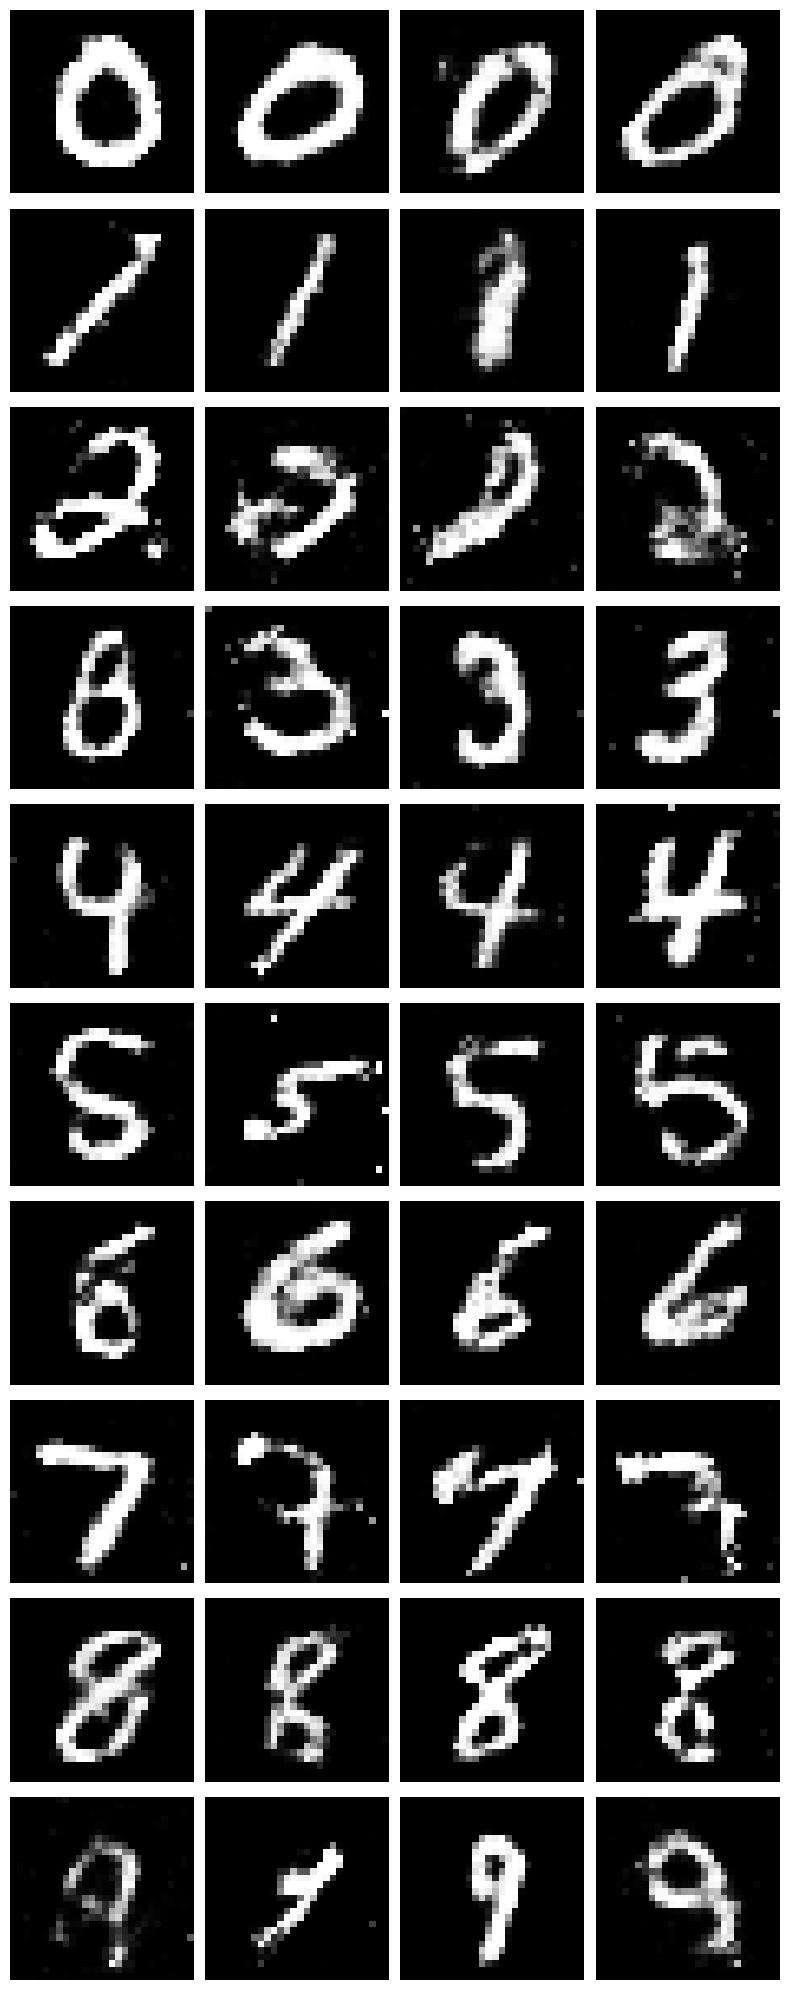

Epoch [41/50] Batch [0/938] Loss D: 1.3837, Loss G: 0.7707
Epoch [41/50] Batch [100/938] Loss D: 1.3628, Loss G: 0.7365
Epoch [41/50] Batch [200/938] Loss D: 1.3650, Loss G: 0.7296
Epoch [41/50] Batch [300/938] Loss D: 1.3606, Loss G: 0.7681
Epoch [41/50] Batch [400/938] Loss D: 1.3534, Loss G: 0.6690
Epoch [41/50] Batch [500/938] Loss D: 1.3317, Loss G: 0.7473
Epoch [41/50] Batch [600/938] Loss D: 1.3973, Loss G: 0.7468
Epoch [41/50] Batch [700/938] Loss D: 1.3495, Loss G: 0.7146
Epoch [41/50] Batch [800/938] Loss D: 1.3500, Loss G: 0.7431
Epoch [41/50] Batch [900/938] Loss D: 1.3780, Loss G: 0.6855


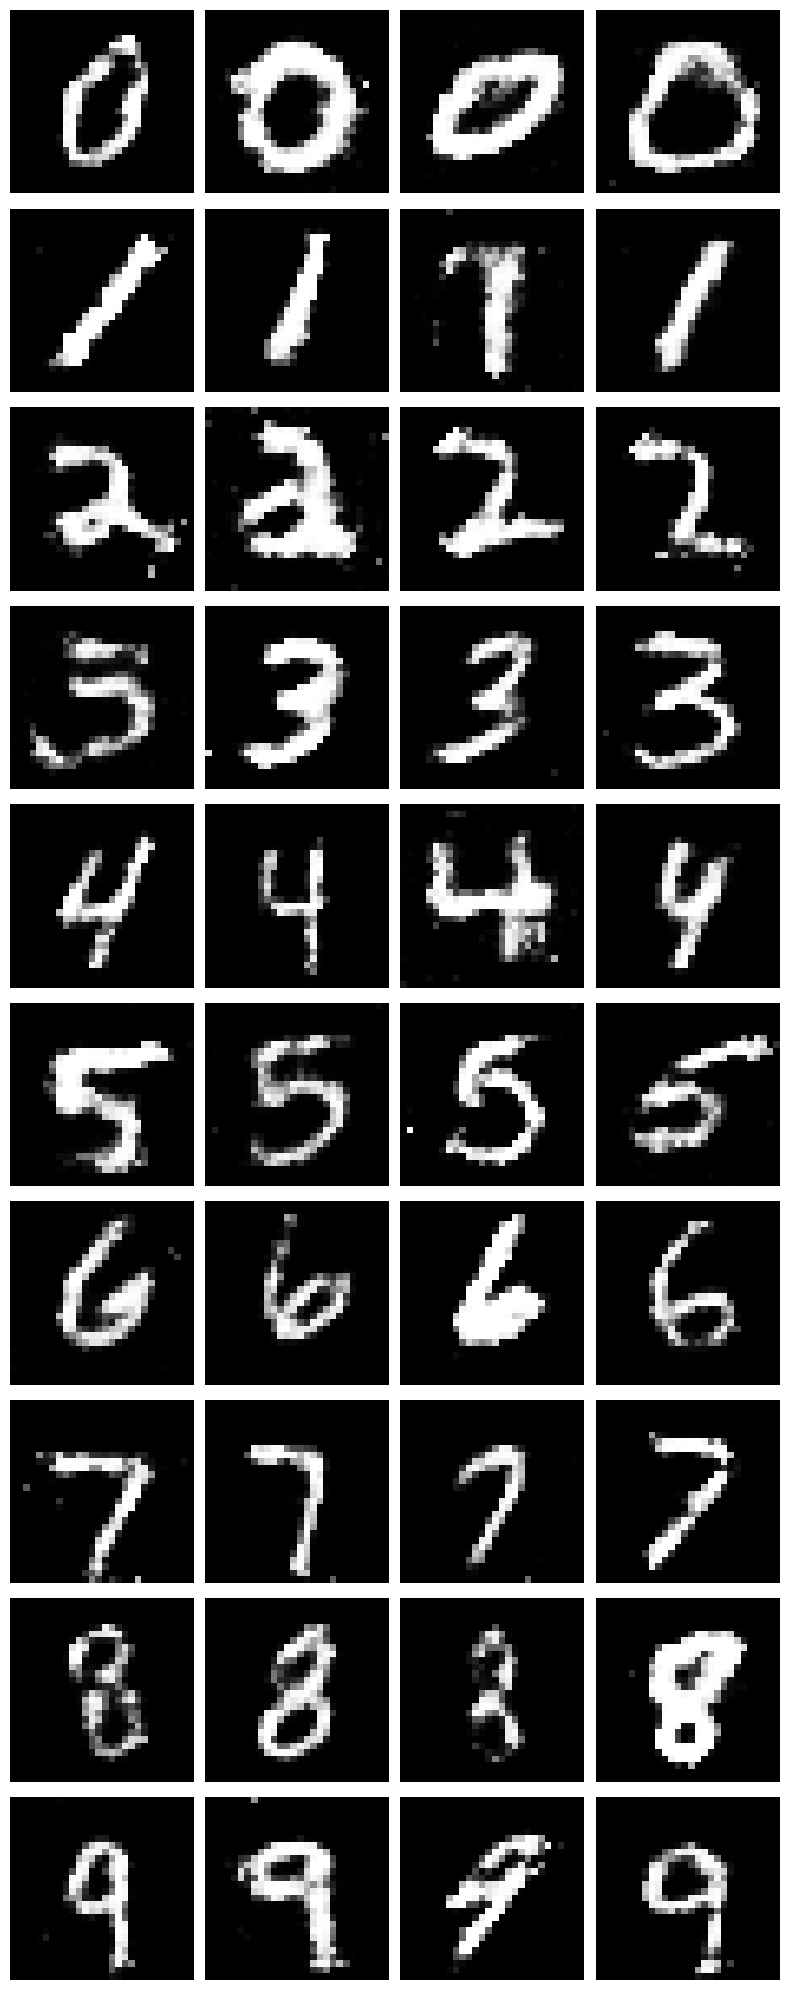

Epoch [42/50] Batch [0/938] Loss D: 1.3637, Loss G: 0.7042
Epoch [42/50] Batch [100/938] Loss D: 1.3368, Loss G: 0.7232
Epoch [42/50] Batch [200/938] Loss D: 1.3352, Loss G: 0.7273
Epoch [42/50] Batch [300/938] Loss D: 1.4051, Loss G: 0.7328
Epoch [42/50] Batch [400/938] Loss D: 1.3090, Loss G: 0.6594
Epoch [42/50] Batch [500/938] Loss D: 1.3698, Loss G: 0.7511
Epoch [42/50] Batch [600/938] Loss D: 1.4016, Loss G: 0.8151
Epoch [42/50] Batch [700/938] Loss D: 1.3461, Loss G: 0.7409
Epoch [42/50] Batch [800/938] Loss D: 1.3654, Loss G: 0.6331
Epoch [42/50] Batch [900/938] Loss D: 1.3563, Loss G: 0.6553


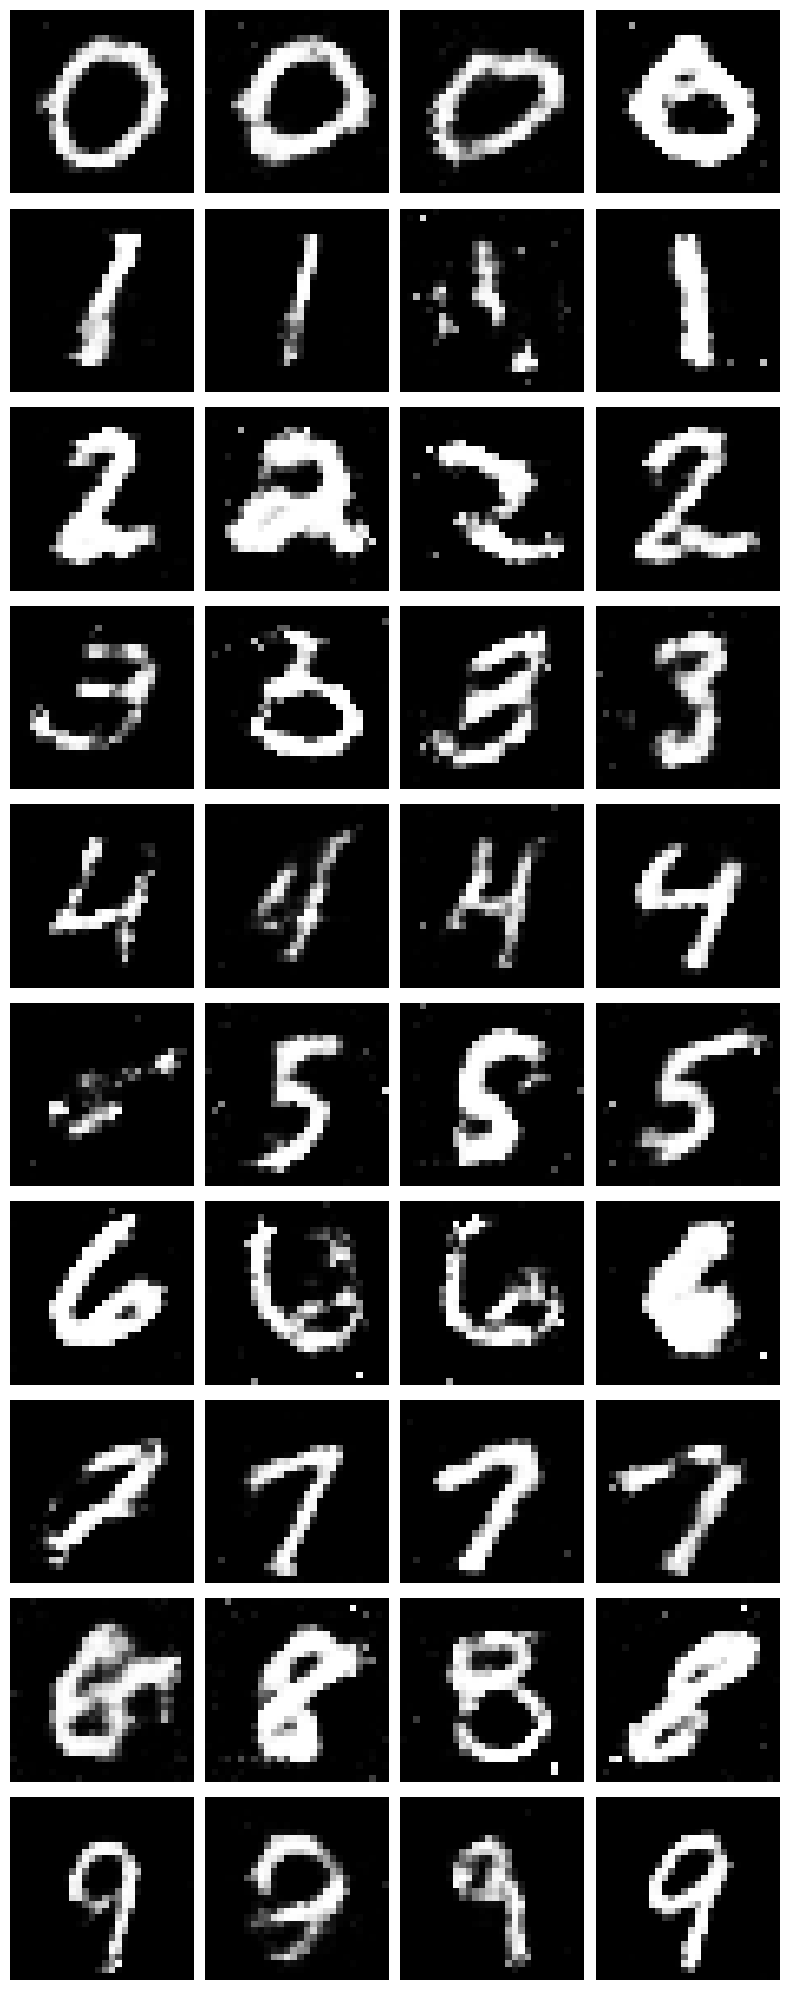

Epoch [43/50] Batch [0/938] Loss D: 1.3782, Loss G: 0.7336
Epoch [43/50] Batch [100/938] Loss D: 1.3711, Loss G: 0.7533
Epoch [43/50] Batch [200/938] Loss D: 1.4058, Loss G: 0.7144
Epoch [43/50] Batch [300/938] Loss D: 1.4336, Loss G: 0.7418
Epoch [43/50] Batch [400/938] Loss D: 1.3820, Loss G: 0.7842
Epoch [43/50] Batch [500/938] Loss D: 1.3792, Loss G: 0.7445
Epoch [43/50] Batch [600/938] Loss D: 1.3538, Loss G: 0.8016
Epoch [43/50] Batch [700/938] Loss D: 1.3307, Loss G: 0.7007
Epoch [43/50] Batch [800/938] Loss D: 1.3036, Loss G: 0.7057
Epoch [43/50] Batch [900/938] Loss D: 1.3427, Loss G: 0.7911


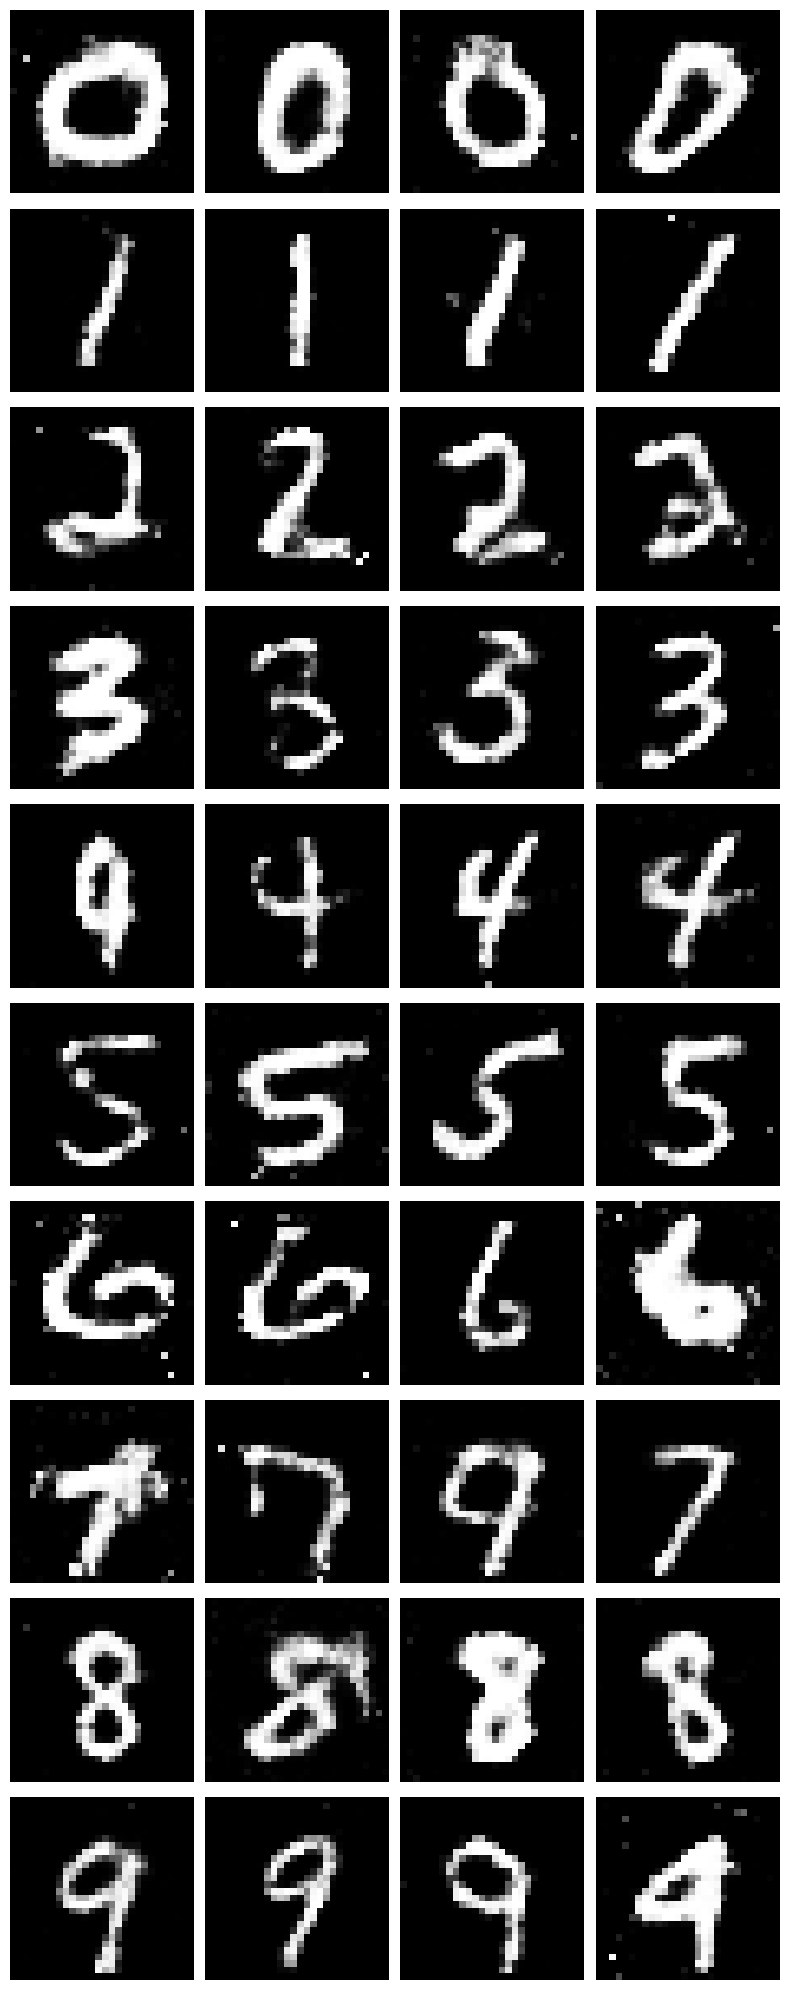

Epoch [44/50] Batch [0/938] Loss D: 1.3922, Loss G: 0.6764
Epoch [44/50] Batch [100/938] Loss D: 1.3725, Loss G: 0.7479
Epoch [44/50] Batch [200/938] Loss D: 1.3514, Loss G: 0.8025
Epoch [44/50] Batch [300/938] Loss D: 1.3560, Loss G: 0.6987
Epoch [44/50] Batch [400/938] Loss D: 1.3583, Loss G: 0.7866
Epoch [44/50] Batch [500/938] Loss D: 1.3875, Loss G: 0.7997
Epoch [44/50] Batch [600/938] Loss D: 1.4000, Loss G: 0.6806
Epoch [44/50] Batch [700/938] Loss D: 1.3415, Loss G: 0.7132
Epoch [44/50] Batch [800/938] Loss D: 1.3671, Loss G: 0.7118
Epoch [44/50] Batch [900/938] Loss D: 1.3836, Loss G: 0.7415


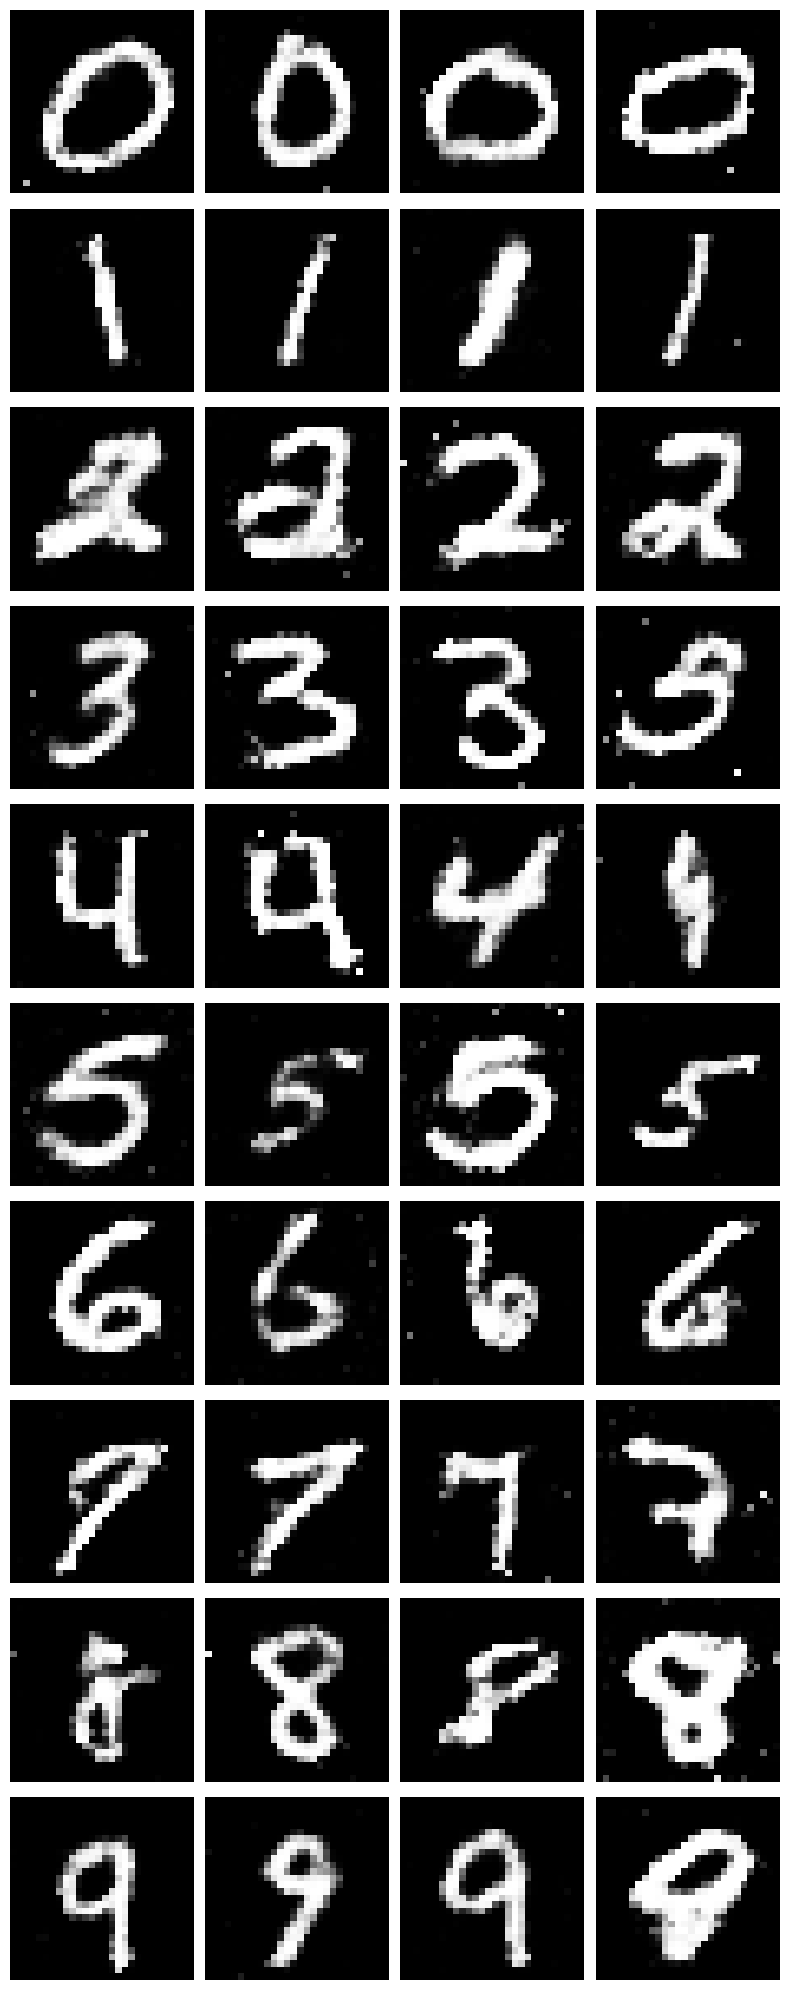

Epoch [45/50] Batch [0/938] Loss D: 1.3588, Loss G: 0.7094
Epoch [45/50] Batch [100/938] Loss D: 1.3588, Loss G: 0.6894
Epoch [45/50] Batch [200/938] Loss D: 1.3787, Loss G: 0.8019
Epoch [45/50] Batch [300/938] Loss D: 1.3055, Loss G: 0.7215
Epoch [45/50] Batch [400/938] Loss D: 1.4339, Loss G: 0.8004
Epoch [45/50] Batch [500/938] Loss D: 1.3413, Loss G: 0.7170
Epoch [45/50] Batch [600/938] Loss D: 1.3665, Loss G: 0.7479
Epoch [45/50] Batch [700/938] Loss D: 1.3963, Loss G: 0.9004
Epoch [45/50] Batch [800/938] Loss D: 1.3508, Loss G: 0.7652
Epoch [45/50] Batch [900/938] Loss D: 1.3309, Loss G: 0.7638


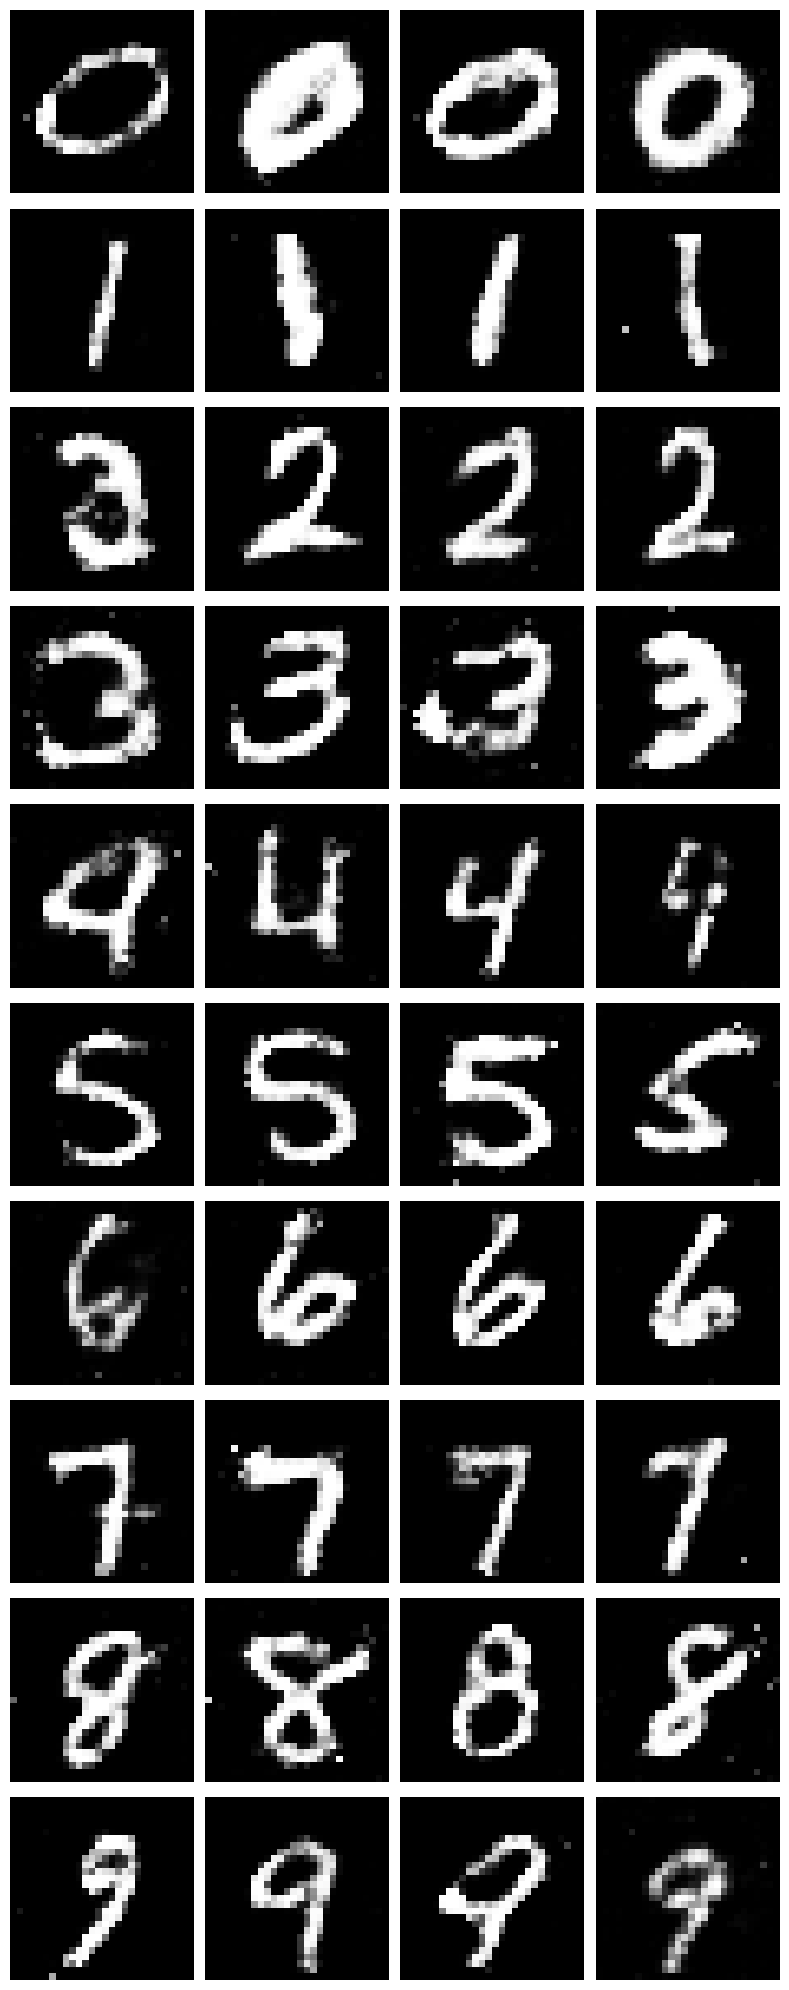

Epoch [46/50] Batch [0/938] Loss D: 1.3981, Loss G: 0.7561
Epoch [46/50] Batch [100/938] Loss D: 1.3387, Loss G: 0.6898
Epoch [46/50] Batch [200/938] Loss D: 1.3706, Loss G: 0.6757
Epoch [46/50] Batch [300/938] Loss D: 1.3369, Loss G: 0.7340
Epoch [46/50] Batch [400/938] Loss D: 1.3406, Loss G: 0.8061
Epoch [46/50] Batch [500/938] Loss D: 1.3793, Loss G: 0.7431
Epoch [46/50] Batch [600/938] Loss D: 1.3660, Loss G: 0.7720
Epoch [46/50] Batch [700/938] Loss D: 1.3629, Loss G: 0.7183
Epoch [46/50] Batch [800/938] Loss D: 1.3798, Loss G: 0.7161
Epoch [46/50] Batch [900/938] Loss D: 1.3991, Loss G: 0.7330


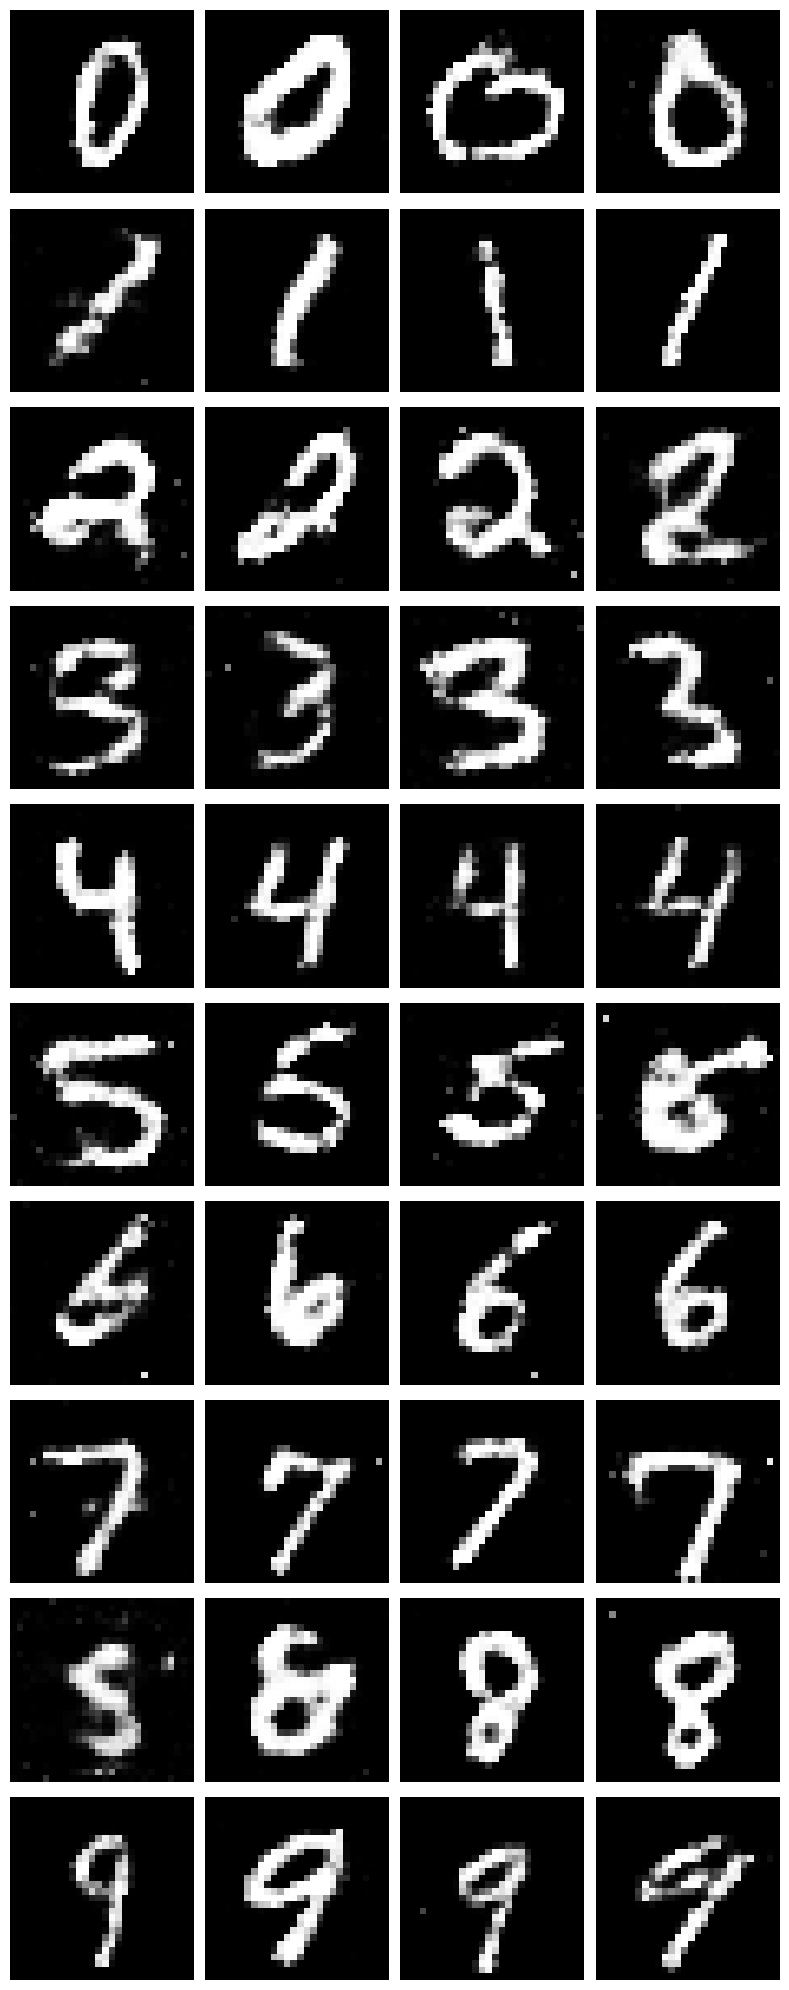

Epoch [47/50] Batch [0/938] Loss D: 1.3681, Loss G: 0.7840
Epoch [47/50] Batch [100/938] Loss D: 1.3632, Loss G: 0.6642
Epoch [47/50] Batch [200/938] Loss D: 1.3759, Loss G: 0.7434
Epoch [47/50] Batch [300/938] Loss D: 1.3840, Loss G: 0.7553
Epoch [47/50] Batch [400/938] Loss D: 1.3757, Loss G: 0.8004
Epoch [47/50] Batch [500/938] Loss D: 1.3234, Loss G: 0.7153
Epoch [47/50] Batch [600/938] Loss D: 1.3484, Loss G: 0.7834
Epoch [47/50] Batch [700/938] Loss D: 1.3198, Loss G: 0.7129
Epoch [47/50] Batch [800/938] Loss D: 1.3360, Loss G: 0.7693
Epoch [47/50] Batch [900/938] Loss D: 1.3881, Loss G: 0.8656


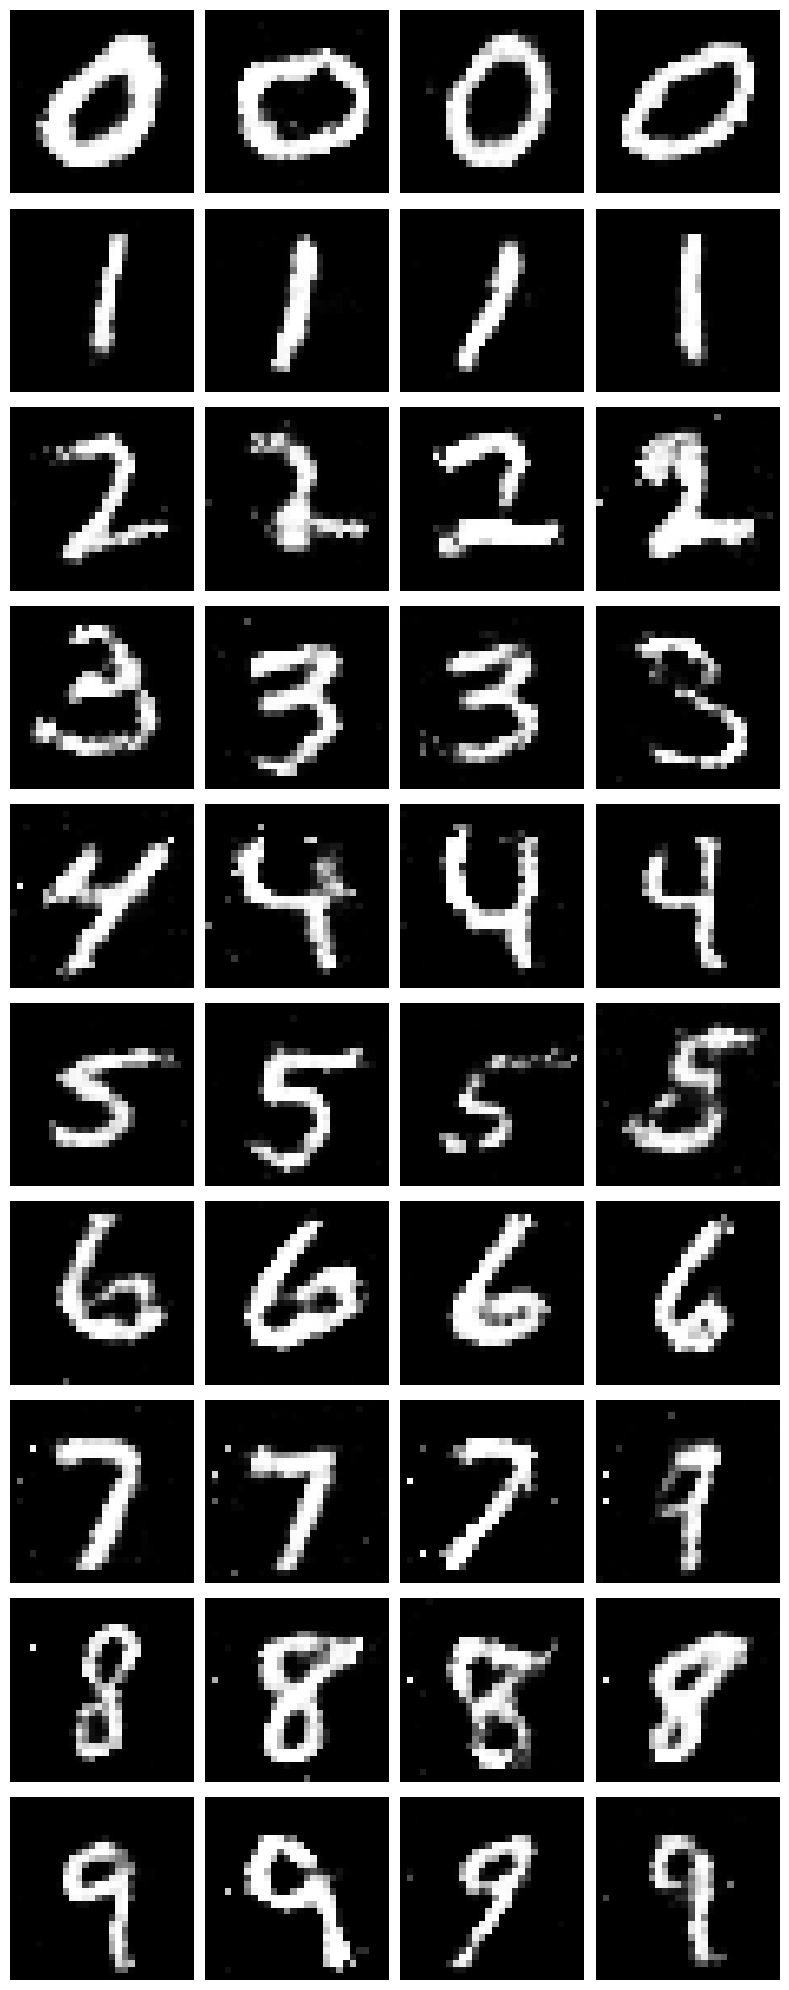

Epoch [48/50] Batch [0/938] Loss D: 1.3559, Loss G: 0.8059
Epoch [48/50] Batch [100/938] Loss D: 1.3966, Loss G: 0.8181
Epoch [48/50] Batch [200/938] Loss D: 1.3920, Loss G: 0.7290
Epoch [48/50] Batch [300/938] Loss D: 1.3172, Loss G: 0.7687
Epoch [48/50] Batch [400/938] Loss D: 1.3599, Loss G: 0.7618
Epoch [48/50] Batch [500/938] Loss D: 1.3412, Loss G: 0.7423
Epoch [48/50] Batch [600/938] Loss D: 1.3638, Loss G: 0.6980
Epoch [48/50] Batch [700/938] Loss D: 1.3604, Loss G: 0.7191
Epoch [48/50] Batch [800/938] Loss D: 1.3754, Loss G: 0.6613
Epoch [48/50] Batch [900/938] Loss D: 1.3861, Loss G: 0.8049


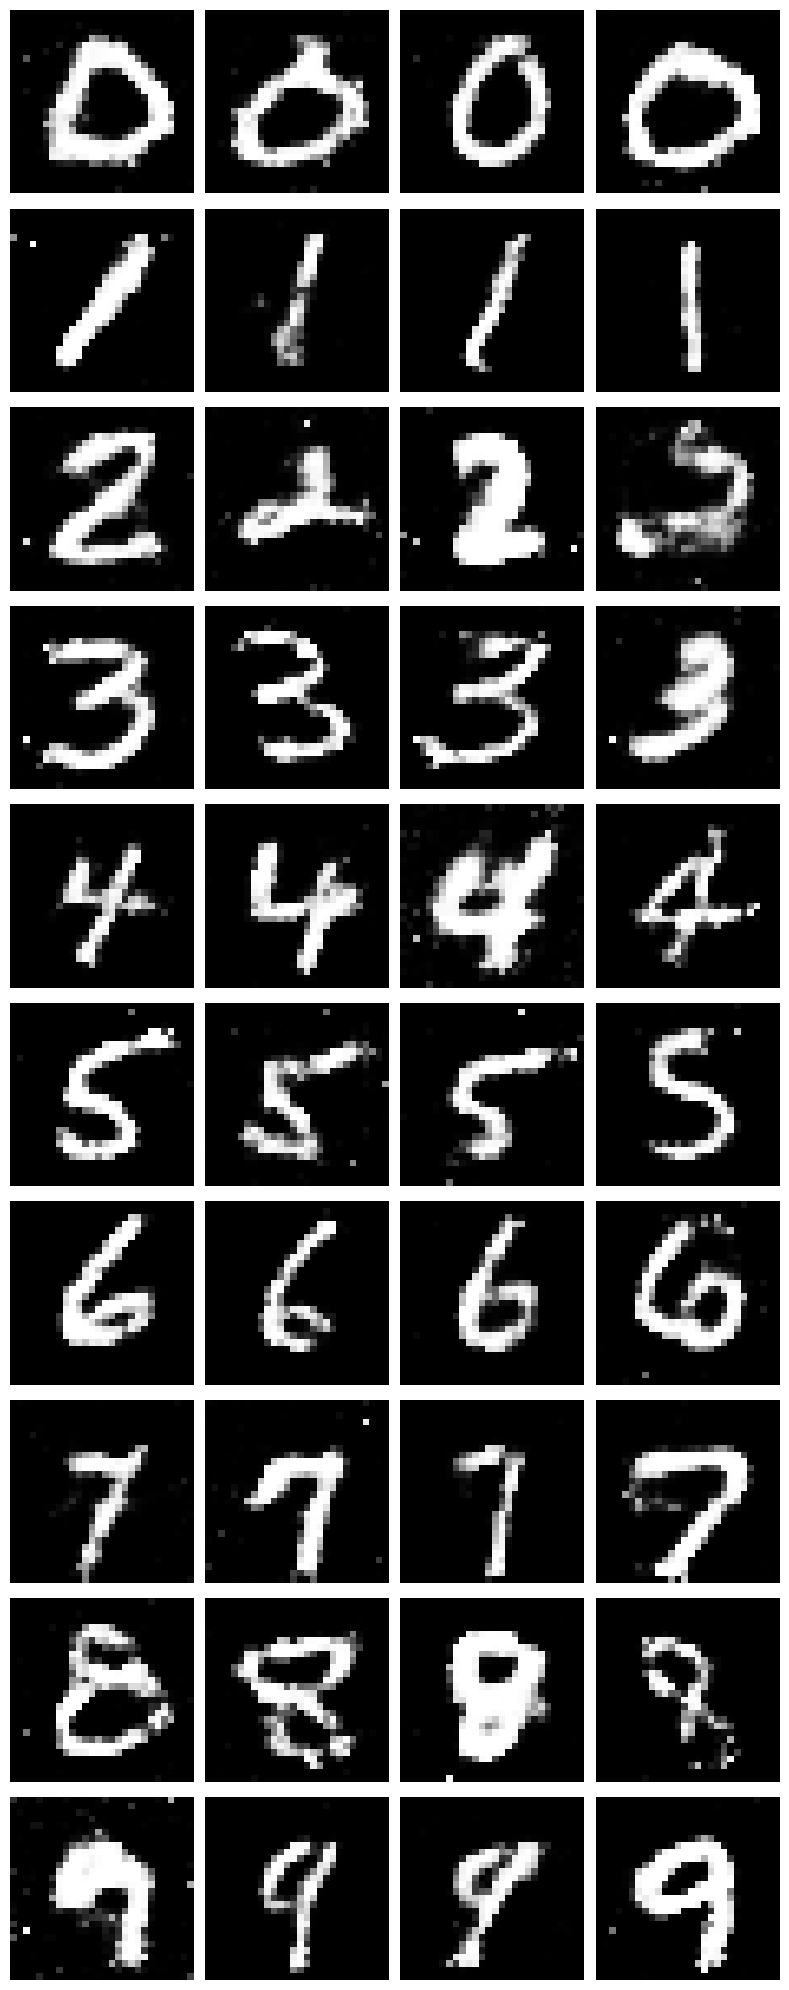

Epoch [49/50] Batch [0/938] Loss D: 1.3621, Loss G: 0.7414
Epoch [49/50] Batch [100/938] Loss D: 1.3455, Loss G: 0.7872
Epoch [49/50] Batch [200/938] Loss D: 1.2954, Loss G: 0.6809
Epoch [49/50] Batch [300/938] Loss D: 1.3254, Loss G: 0.7097
Epoch [49/50] Batch [400/938] Loss D: 1.3050, Loss G: 0.7342
Epoch [49/50] Batch [500/938] Loss D: 1.3517, Loss G: 0.6686
Epoch [49/50] Batch [600/938] Loss D: 1.3398, Loss G: 0.7775
Epoch [49/50] Batch [700/938] Loss D: 1.3354, Loss G: 0.7332
Epoch [49/50] Batch [800/938] Loss D: 1.3050, Loss G: 0.7220
Epoch [49/50] Batch [900/938] Loss D: 1.3277, Loss G: 0.7105


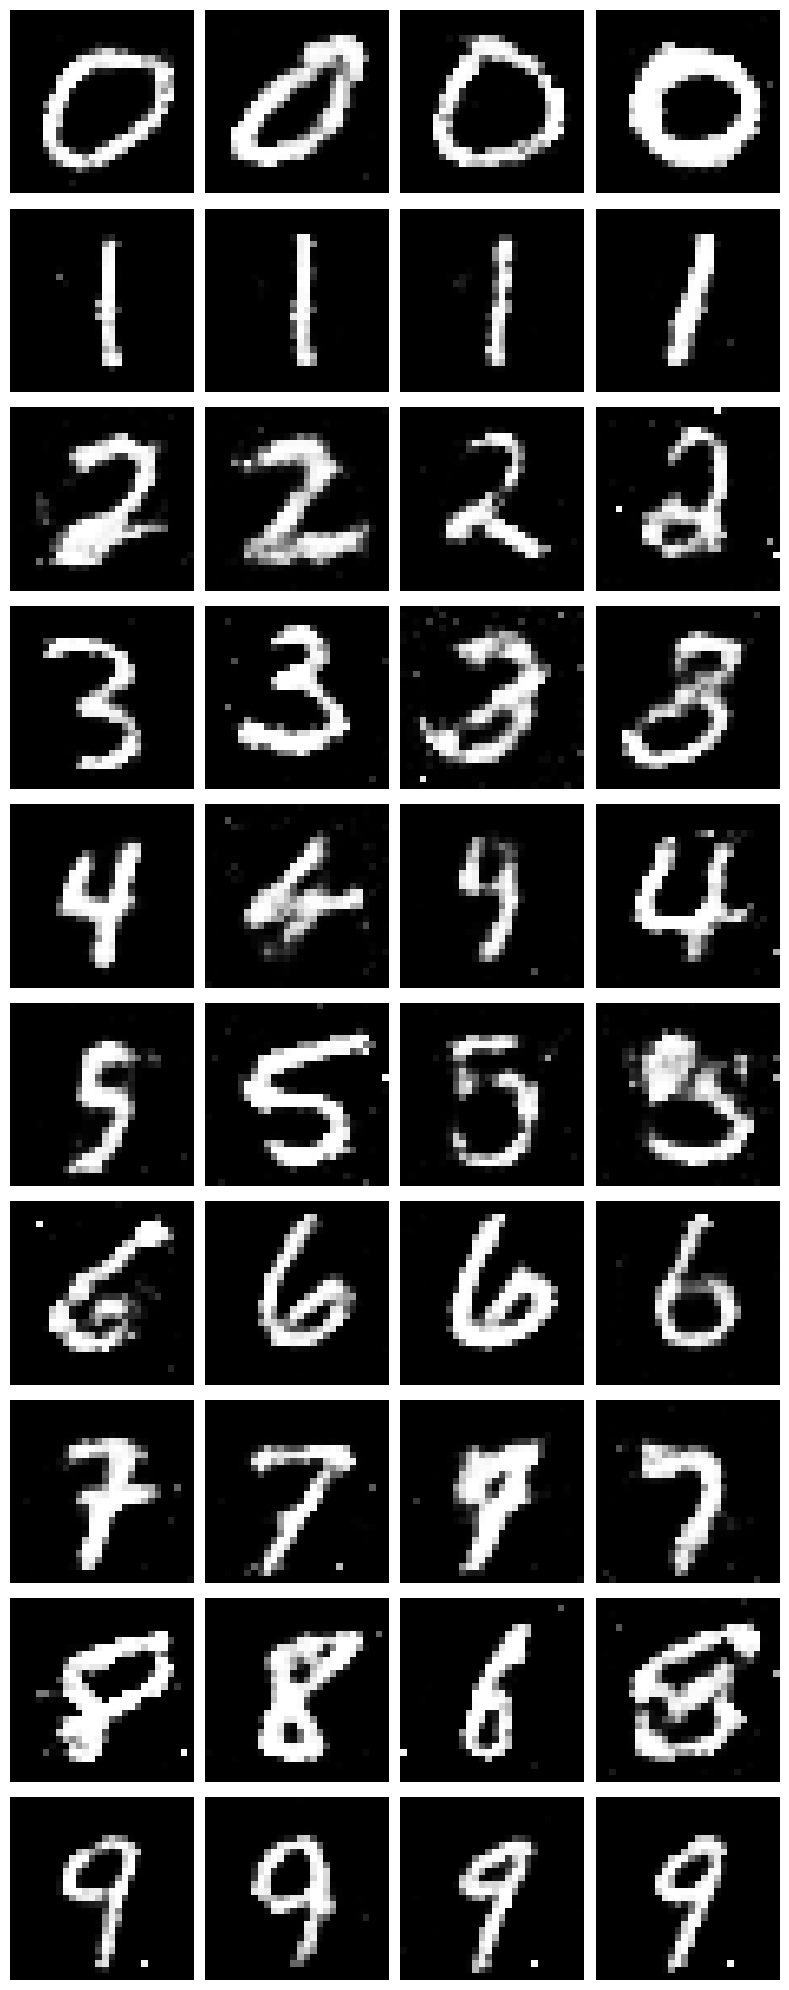

Epoch [50/50] Batch [0/938] Loss D: 1.3858, Loss G: 0.7330
Epoch [50/50] Batch [100/938] Loss D: 1.4443, Loss G: 0.8419
Epoch [50/50] Batch [200/938] Loss D: 1.3847, Loss G: 0.7203
Epoch [50/50] Batch [300/938] Loss D: 1.3776, Loss G: 0.7247
Epoch [50/50] Batch [400/938] Loss D: 1.3345, Loss G: 0.8287
Epoch [50/50] Batch [500/938] Loss D: 1.3888, Loss G: 0.7906
Epoch [50/50] Batch [600/938] Loss D: 1.3816, Loss G: 0.7447
Epoch [50/50] Batch [700/938] Loss D: 1.3618, Loss G: 0.6842
Epoch [50/50] Batch [800/938] Loss D: 1.3914, Loss G: 0.7221
Epoch [50/50] Batch [900/938] Loss D: 1.3512, Loss G: 0.8655


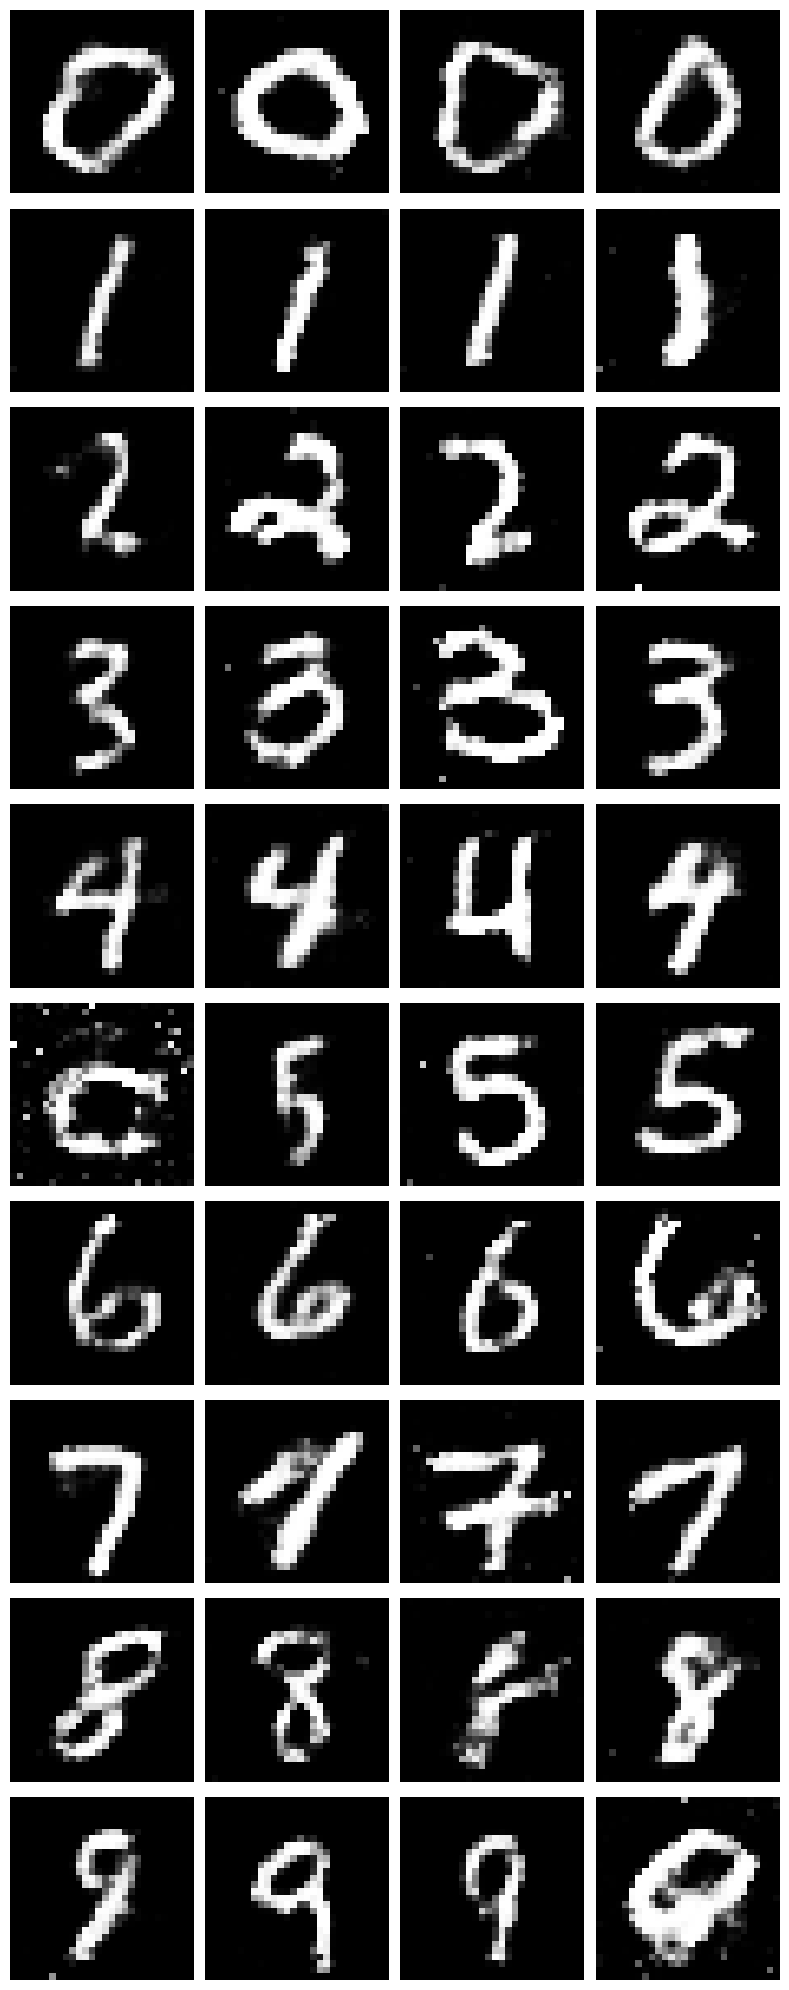

In [7]:
# Training loop
last_model_path = "last.pt"
best_model_path = "best.pt"
best_loss = float("inf")

for epoch in range(epochs):
    g_loss_epoch = 0.0
    for i, (imgs, labels) in enumerate(dataloader):
        imgs, labels = imgs.to(device), labels.to(device)
        batch_size = imgs.size(0)

        # Prepare labels
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator
        optimizer_D.zero_grad()
        z = torch.randn(batch_size, latent_dim).to(device)
        gen_labels = torch.randint(0, n_classes, (batch_size,)).to(device)
        gen_imgs = generator(z, gen_labels).detach()

        real_loss = adversarial_loss(discriminator(imgs, labels), real_labels)
        fake_loss = adversarial_loss(discriminator(gen_imgs, gen_labels), fake_labels)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(batch_size, latent_dim).to(device)
        gen_labels = torch.randint(0, n_classes, (batch_size,)).to(device)
        gen_imgs = generator(z, gen_labels)

        g_loss = adversarial_loss(discriminator(gen_imgs, gen_labels), real_labels)
        g_loss.backward()
        optimizer_G.step()
        g_loss_epoch += g_loss.item()

        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] Batch [{i}/{len(dataloader)}] "
                  f"Loss D: {d_loss.item():.4f}, Loss G: {g_loss.item():.4f}")
    g_loss_epoch /= len(dataloader)
    if best_loss > g_loss_epoch:
        best_loss = g_loss_epoch
        torch.save(generator.state_dict(), best_model_path)
    torch.save(generator.state_dict(), last_model_path)

    # Visualize generated images after each epoch
    visualize_generated_images(generator, latent_dim, n_classes, device, epoch + 1)

## **Visualization**
Display generated images for specific conditions to assess the performance of the cGAN.

<ipython-input-8-fcd6eb6194f8>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_generator.load_state_dict(torch.load(best_model_path))
<ipython-input-8-fcd6eb6194f8>:6:

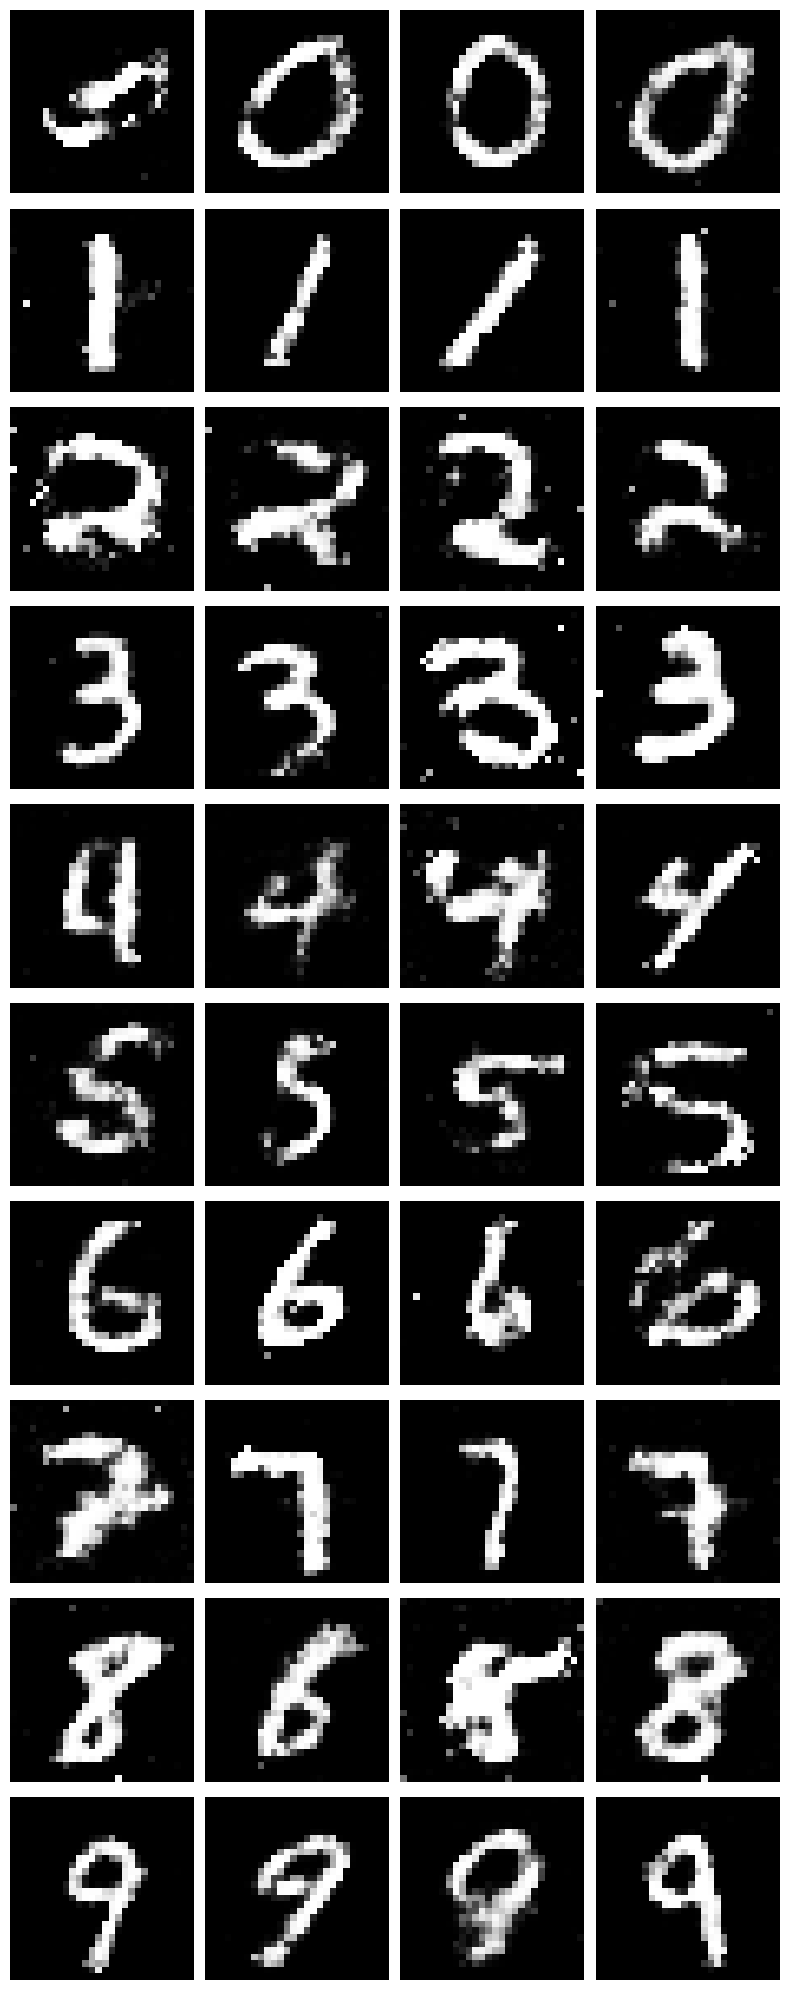

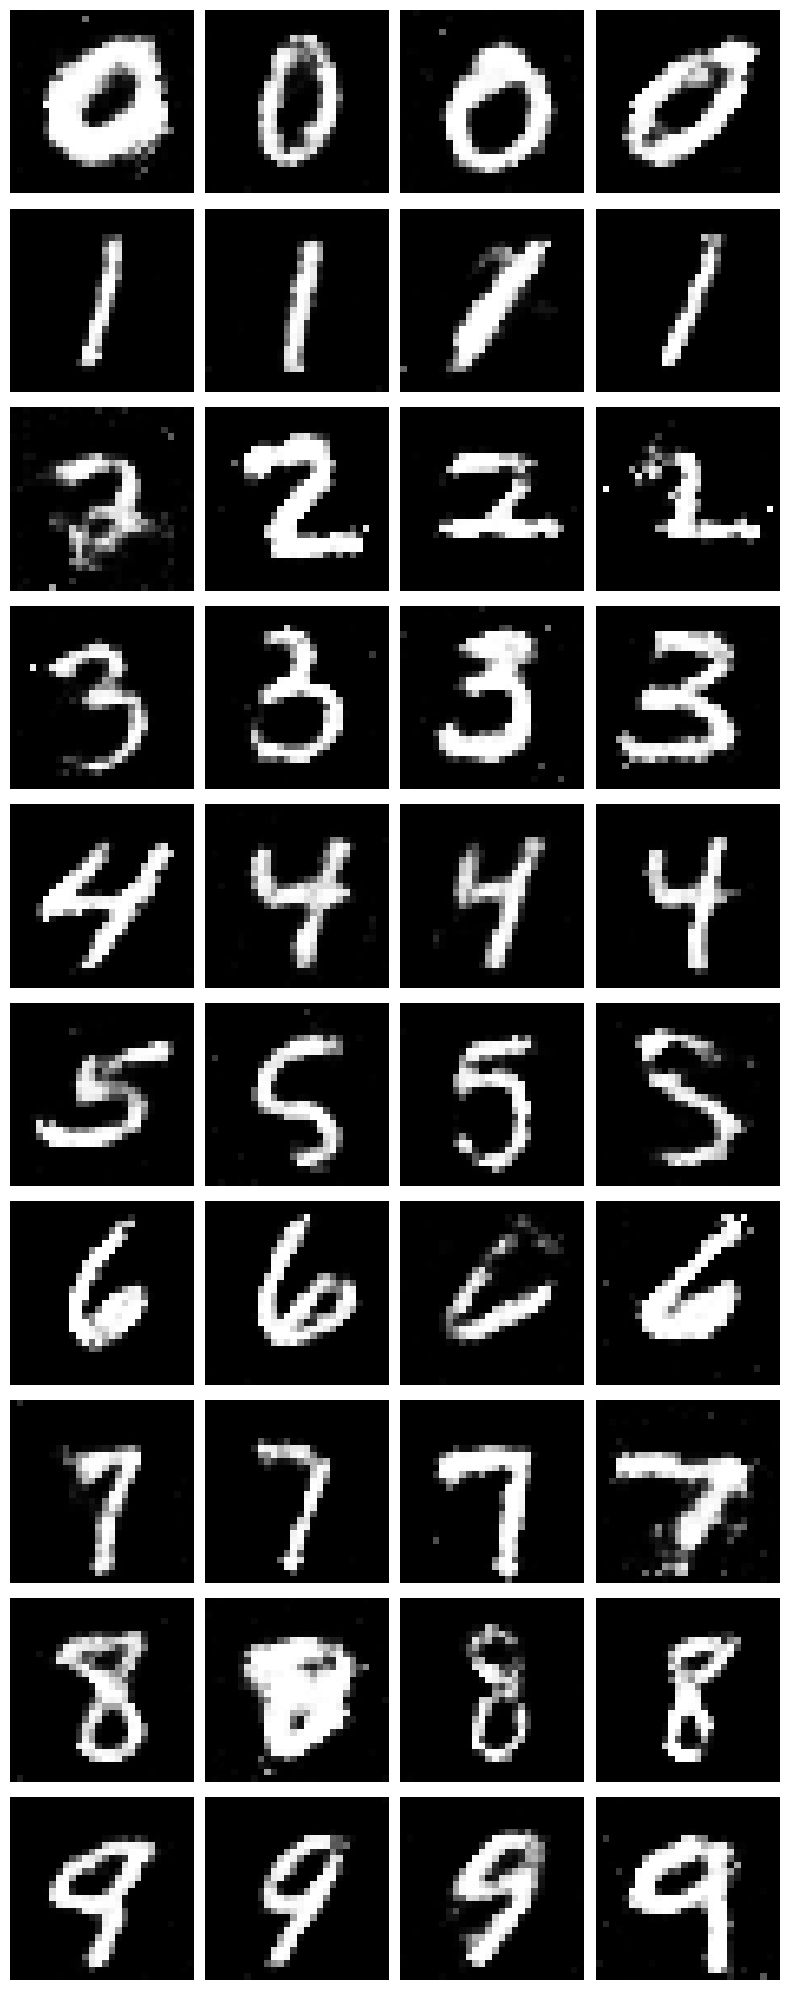

In [8]:
best_generator = ConditionalGenerator(latent_dim, n_classes, img_size, channels).to(device)
best_generator.load_state_dict(torch.load(best_model_path))
best_generator.eval()

last_generator = ConditionalGenerator(latent_dim, n_classes, img_size, channels).to(device)
last_generator.load_state_dict(torch.load(last_model_path))
last_generator.eval()

visualize_generated_images(best_generator, latent_dim, n_classes, device, "best")
visualize_generated_images(last_generator, latent_dim, n_classes, device, "last")